<a href="https://colab.research.google.com/github/arpadikuma/Colab_Projects/blob/main/ZTM_TF_DEV_2023_exercises3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises in Time Series Forecasting

### Preparations

In [ ]:
import os
import sys
import pathlib
import random
import datetime
import time
from copy import deepcopy

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

print(tf.__version__)

2.13.0


In [ ]:
if 'google.colab' in sys.modules:
    print("This Notebook is running in Google Colab\n")
    local = False
    if os.path.isdir("/content/drive/MyDrive/TF_sources"):
        print("Connected to Google Drive through Google Colab\n")
        runtime = 3
        %cd /content/drive/MyDrive/TF_sources
        %ls
else:
    print("This Notebook is connected to a local runtime\n")
    local = True
    if os.path.isdir("C:\\Users\\ikuma\\OneDrive\\python\\datascience\\ZTM_Tensorflow\\NLP_TF"):
        print("Connected to native Windows Jupyter runtime\n")
        runtime = 1
        %cd C:\Users\ikuma\OneDrive\python\datascience\ZTM_Tensorflow\
        %ls
    elif os.path.isdir("/tf_gpu/ZTM_Tensorflow/"):
        print("Connected to WSL2 Docker Jupyter runtime\n")
        runtime = 2
        %cd /tf_gpu/ZTM_Tensorflow/
        %ls
    else:
        print(".")

This Notebook is connected to a local runtime

Connected to WSL2 Docker Jupyter runtime

/tf_gpu/ZTM_Tensorflow
07_food_vision_milestone_project1.ipynb*  NLP_TF/         effiNetB0_10p/
101_food_classes_10_percent/              Time_Series/    helper_functions.py*
10_food_classes_10_percent/               __pycache__/    model_checkpoints/
10_food_classes_all_data/                 cameras/        saved_models/
10p_finetune/                             catboost_info/  tensorboard_data/
10p_finetune_30l/                         custom/         yolo/


In [ ]:
%cd Time_Series/

/tf_gpu/ZTM_Tensorflow/Time_Series


In [ ]:
print("GPU is available!" if tf.config.list_logical_devices("GPU") else "No GPU available!")

GPU is available!


2023-07-28 03:30:08.748452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 03:30:08.872265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 03:30:08.873064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 03:30:08.900977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 03:30:08.901660: I tensorflow/compile

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-baf5dce6-0fe5-ba5d-4d76-c637e82706ec)


## Time Series Forecasting On MSFT Stock - non ZTM/Youtube Tutorial

### Set Param, Load Data, Explore Data

In [ ]:
WINDOW = 5

In [ ]:
df_msft = pd.read_csv('MSFT.csv')
df_msft.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.060524  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062686   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063767   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.062145    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.061065    47894400

In [ ]:
df_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9410 entries, 0 to 9409
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9410 non-null   object 
 1   Open       9410 non-null   float64
 2   High       9410 non-null   float64
 3   Low        9410 non-null   float64
 4   Close      9410 non-null   float64
 5   Adj Close  9410 non-null   float64
 6   Volume     9410 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 514.7+ KB


In [ ]:
df_msft = df_msft[["Date", "Close"]]
df_msft.head()

Date     Close
0  1986-03-13  0.097222
1  1986-03-14  0.100694
2  1986-03-17  0.102431
3  1986-03-18  0.099826
4  1986-03-19  0.098090

### Prep Data

In [ ]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df_msft["Date"] = df_msft["Date"].apply(str_to_datetime)
df_msft['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9405   2023-07-10
9406   2023-07-11
9407   2023-07-12
9408   2023-07-13
9409   2023-07-14
Name: Date, Length: 9410, dtype: datetime64[ns]

In [ ]:
df_msft.index = df_msft.pop('Date')
df_msft

Close
Date                  
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
...                ...
2023-07-10  331.829987
2023-07-11  332.470001
2023-07-12  337.200012
2023-07-13  342.660004
2023-07-14  345.239990

[9410 rows x 1 columns]

In [ ]:
df_msft.head(20)

Close
Date                
1986-03-13  0.097222
1986-03-14  0.100694
1986-03-17  0.102431
1986-03-18  0.099826
1986-03-19  0.098090
1986-03-20  0.095486
1986-03-21  0.092882
1986-03-24  0.090278
1986-03-25  0.092014
1986-03-26  0.094618
1986-03-27  0.096354
1986-03-31  0.095486
1986-04-01  0.094618
1986-04-02  0.095486
1986-04-03  0.096354
1986-04-04  0.096354
1986-04-07  0.094618
1986-04-08  0.095486
1986-04-09  0.097222
1986-04-10  0.098090

### Plot Data

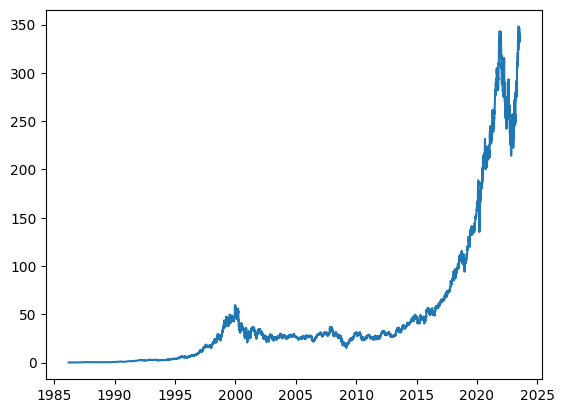

In [ ]:
plt.plot(df_msft.index, df_msft["Close"])

### Define Functions

#### Function To Convert DF To Windowed DF

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=WINDOW):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X_list, y_list = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f"Error: Window of size {n} is too large for date {target_date}")
            return

        values = df_subset['Close'].to_numpy()
        X, y = values[:-1], values[-1]

        dates.append(target_date)
        X_list.append(X)
        y_list.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])

        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['target_date'] = dates

    X_list = np.array(X_list)
    for i in range(0, n):
        X_list[:, i]
        ret_df[f'target_{n-i}'] = X_list[:, i]

    ret_df['target'] = y_list

    return ret_df

In [ ]:
# start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df_msft, '1986-03-20', '2023-07-14')
windowed_df

target_date    target_5    target_4    target_3    target_2    target_1  \
0     1986-03-20    0.097222    0.100694    0.102431    0.099826    0.098090   
1     1986-03-21    0.100694    0.102431    0.099826    0.098090    0.095486   
2     1986-03-24    0.102431    0.099826    0.098090    0.095486    0.092882   
3     1986-03-25    0.099826    0.098090    0.095486    0.092882    0.090278   
4     1986-03-26    0.098090    0.095486    0.092882    0.090278    0.092014   
...          ...         ...         ...         ...         ...         ...   
9400  2023-07-10  340.540009  337.989990  338.149994  341.269989  337.220001   
9401  2023-07-11  337.989990  338.149994  341.269989  337.220001  331.829987   
9402  2023-07-12  338.149994  341.269989  337.220001  331.829987  332.470001   
9403  2023-07-13  341.269989  337.220001  331.829987  332.470001  337.200012   
9404  2023-07-14  337.220001  331.829987  332.470001  337.200012  342.660004   

          target  
0       0.095486  
1       0.092882  
2       0.090278  
3       0.092014  
4       0.094618  
...          ...  
9400  331.829987  
9401  332.470001  
9402  337.200012  
9403  342.660004  
9404  345.239990  

[9405 rows x 7 columns]

#### Function To Create X & y Datasets

In [ ]:
def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    y = df_as_np[:, -1]

    return dates, X.astype(np.float32), y.astype(np.float32)

In [ ]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((9405,), (9405, 5, 1), (9405,))

#### Split Train/Val/Test

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

#### Visualize Train/Val/Test

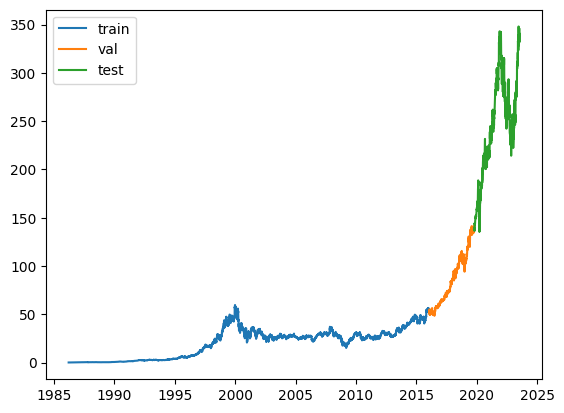

In [ ]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['train', 'val', 'test'])

### Create & Compile Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential([layers.Input((WINDOW,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)
                    ], name="lstm_msft")

model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.001),
              metrics=['mse', 'mae'])

2023-07-17 00:15:18.629393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:15:18.633571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:15:18.635610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Model Training

In [ ]:
history_msft = model.fit(X_train,
                         y_train,
                         validation_data=(X_val, y_val),
                         epochs=100)

Epoch 1/100


2023-07-17 00:15:22.753324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:15:22.758312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:15:22.763701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

233/236 [============================>.] - ETA: 0s - loss: 105.9740 - mse: 105.9740 - mae: 4.2309

2023-07-17 00:15:34.303440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:15:34.305247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:15:34.307535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

236/236 [==============================] - 12s 11ms/step - loss: 105.0203 - mse: 105.0203 - mae: 4.1963 - val_loss: 2467.4126 - val_mse: 2467.4126 - val_mae: 37.4721
Epoch 2/100
236/236 [==============================] - 2s 9ms/step - loss: 0.3759 - mse: 0.3759 - mae: 0.3570 - val_loss: 2218.3213 - val_mse: 2218.3213 - val_mae: 34.8243
Epoch 3/100
236/236 [==============================] - 2s 9ms/step - loss: 0.3356 - mse: 0.3356 - mae: 0.3394 - val_loss: 2087.3899 - val_mse: 2087.3899 - val_mae: 33.5682
Epoch 4/100
236/236 [==============================] - 2s 9ms/step - loss: 0.3335 - mse: 0.3335 - mae: 0.3378 - val_loss: 1957.8064 - val_mse: 1957.8064 - val_mae: 32.1228
Epoch 5/100
236/236 [==============================] - 2s 10ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0.3441 - val_loss: 1860.3590 - val_mse: 1860.3590 - val_mae: 31.4371
Epoch 6/100
236/236 [==============================] - 2s 10ms/step - loss: 0.3279 - mse: 0.3279 - mae: 0.3366 - val_loss: 1837.0854 - val_mse: 1

### Visualize Results

 17/236 [=>............................] - ETA: 0s  

2023-07-17 00:49:18.873429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:49:18.876246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:49:18.878109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

236/236 [==============================] - 1s 3ms/step


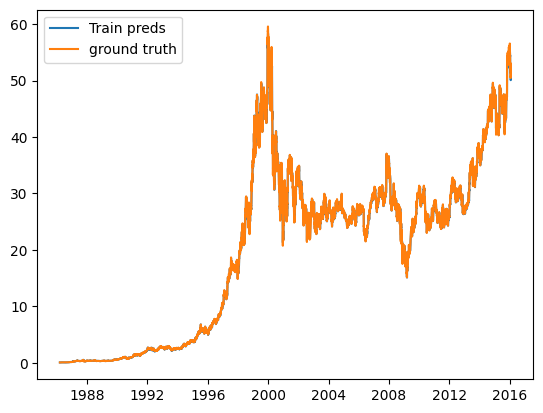

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(["Train preds", "ground truth"])

30/30 [==============================] - 0s 3ms/step


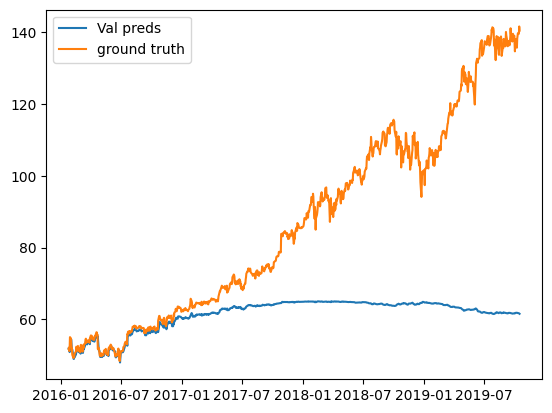

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(["Val preds", "ground truth"])

30/30 [==============================] - 0s 4ms/step


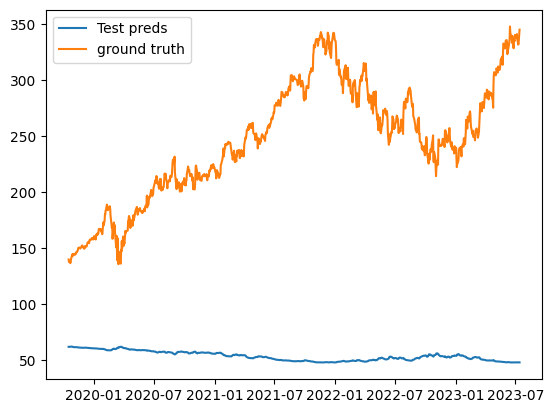

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(["Test preds", "ground truth"])

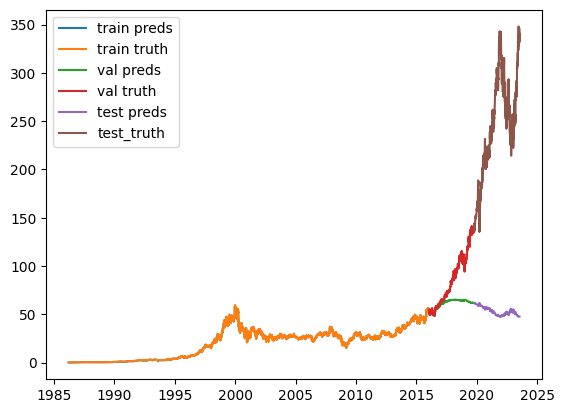

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['train preds', 'train truth', 'val preds', 'val truth', 'test preds', 'test_truth'])

### Retraining on smaller dataset

In [ ]:
win_df = df_to_windowed_df(df_msft, "2021-03-25", "2023-07-14")
win_df

target_date    target_5    target_4    target_3    target_2    target_1  \
0    2021-03-25  230.720001  230.350006  235.990005  237.580002  235.460007   
1    2021-03-26  230.350006  235.990005  237.580002  235.460007  232.339996   
2    2021-03-29  235.990005  237.580002  235.460007  232.339996  236.479996   
3    2021-03-30  237.580002  235.460007  232.339996  236.479996  235.240005   
4    2021-03-31  235.460007  232.339996  236.479996  235.240005  231.850006   
..          ...         ...         ...         ...         ...         ...   
575  2023-07-10  340.540009  337.989990  338.149994  341.269989  337.220001   
576  2023-07-11  337.989990  338.149994  341.269989  337.220001  331.829987   
577  2023-07-12  338.149994  341.269989  337.220001  331.829987  332.470001   
578  2023-07-13  341.269989  337.220001  331.829987  332.470001  337.200012   
579  2023-07-14  337.220001  331.829987  332.470001  337.200012  342.660004   

         target  
0    232.339996  
1    236.479996  
2    235.240005  
3    231.850006  
4    235.770004  
..          ...  
575  331.829987  
576  332.470001  
577  337.200012  
578  342.660004  
579  345.239990  

[580 rows x 7 columns]

In [ ]:
dates, X, y = windowed_df_to_date_X_y(win_df)
dates.shape, X.shape, y.shape

((580,), (580, 5, 1), (580,))

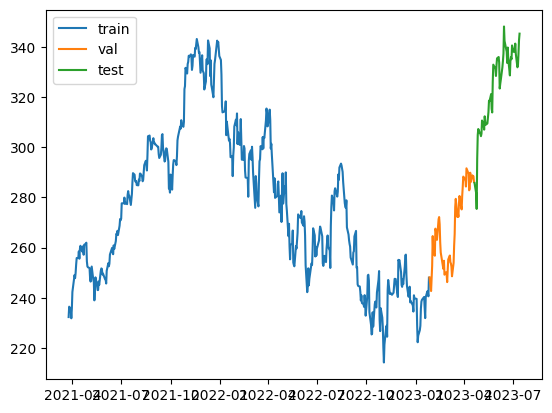

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['train', 'val', 'test'])

### Model Creation

In [ ]:
model = Sequential([
    layers.Input((WINDOW,1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
], name='lstm_msft_2')

2023-07-17 00:49:28.267000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:49:28.268600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:49:28.270503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Model Compiling

In [ ]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mae']
              )

### Model Training

In [ ]:
history_msft_2 = model.fit(X_train, y_train,
                           validation_data=(X_val, y_val),
                           epochs=100)

Epoch 1/100


2023-07-17 00:49:34.479323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:49:34.481614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:49:34.483298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 3s 36ms/step - loss: 76835.2656 - mae: 275.4933 - val_loss: 71491.2344 - val_mae: 266.9759
Epoch 2/100
 1/15 [=>............................] - ETA: 0s - loss: 71932.6719 - mae: 267.0710

2023-07-17 00:49:37.010152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:49:37.011877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:49:37.013467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 0s 11ms/step - loss: 76305.6406 - mae: 274.5321 - val_loss: 70862.8828 - val_mae: 265.7964
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 75463.4219 - mae: 272.9934 - val_loss: 69811.9453 - val_mae: 263.8120
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 74125.9922 - mae: 270.5339 - val_loss: 68020.0703 - val_mae: 260.3930
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 71410.9531 - mae: 265.4391 - val_loss: 64049.6992 - val_mae: 252.6551
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 66747.0391 - mae: 256.4856 - val_loss: 58920.2500 - val_mae: 242.2894
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 60326.9531 - mae: 243.7039 - val_loss: 51566.6133 - val_mae: 226.6082
Epoch 8/100
15/15 [==============================] - 0s 11ms/step - loss: 51841.6133 - mae: 225.5806 - val_loss: 42326.6094 - val_mae: 205.2108
Epoc

### Visualizing New Results

 1/15 [=>............................] - ETA: 4s

2023-07-17 00:50:03.406055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:50:03.409186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:50:03.410795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 4ms/step


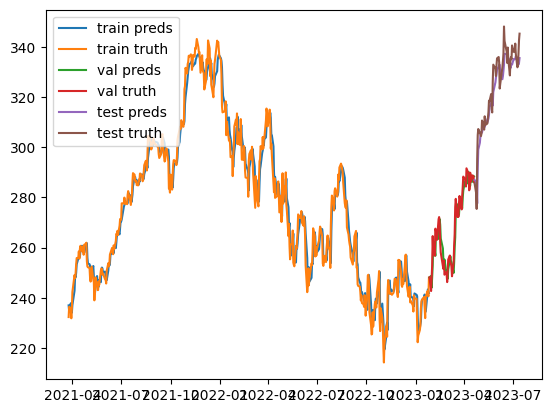

In [ ]:
train_preds = model.predict(X_train).flatten()
val_preds = model.predict(X_val).flatten()
test_preds = model.predict(X_test).flatten()

plt.plot(dates_train, train_preds)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_preds)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_preds)
plt.plot(dates_test, y_test)
plt.legend(['train preds', 'train truth', 'val preds', 'val truth', 'test preds', 'test truth'])

In [ ]:
from copy import deepcopy

In [ ]:
model.predict([X_train[-WINDOW]]).flatten(), X_train[-2]

1/1 [==============================] - 0s 340ms/step


2023-07-17 00:50:13.356543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 00:50:13.358135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 00:50:13.359647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(array([283.2094 , 283.2365 , 283.27798, 283.10483, 282.9459 ],
       dtype=float32),
 array([[235.81],
        [231.93],
        [240.22],
        [242.58],
        [242.04]], dtype=float32))

### Recursive Prediction

In [ ]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

counter = 0

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window = np.concatenate([last_window[1:], [next_prediction]])

    # print(last_window)
    # print(f"{target_date} prediction: {next_prediction}")
    # print(recursive_predictions)

### Visualizing Recursive Prediction

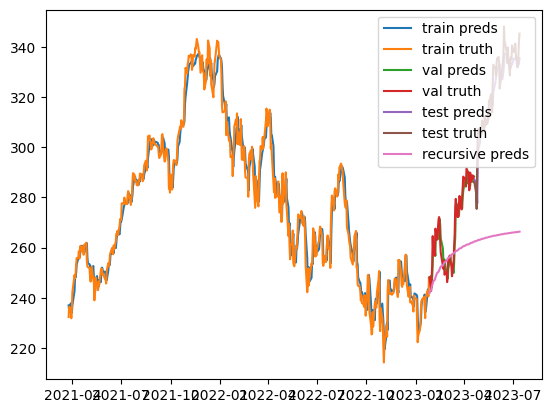

In [ ]:
plt.plot(dates_train, train_preds)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_preds)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_preds)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['train preds',
            'train truth',
            'val preds',
            'val truth',
            'test preds',
            'test truth',
            'recursive preds'])

## ZTM Exercises

## Tasks

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
 - Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
 - You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".
3. For most of our models we used `WINDOW_SIZE=7`, but is there a better window size?
 - Setup a series of experiments to find whether or not there's a better window size.
 - For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for `model_1` using `tf.keras.preprocessing.timeseries_dataset_from_array()` and retrain `model_1` using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
 - Are there any other features you think you could add?
 - If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes.
    * Try out one of the extra algorithms listed in the modelling experiments part such as:
        - Facebook's Kats library - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
        -  LinkedIn's Greykite library

### 1. Scaling Data For Univariate/Multivariate Forecasting

Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

Combining with #2 using most recent BTC data

#### Data Preparation

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-21 17:20:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.1s    

2023-07-21 17:20:30 (1.19 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
df = pd.read_csv('BTC_USD.csv',
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

                Volume  
Date                    
2014-09-17  21056800.0  
2014-09-18  34483200.0  
2014-09-19  37919700.0  
2014-09-20  36863600.0  
2014-09-21  26580100.0

#### Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3228 entries, 2014-09-17 to 2023-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3227 non-null   float64
 1   High       3227 non-null   float64
 2   Low        3227 non-null   float64
 3   Close      3227 non-null   float64
 4   Adj Close  3227 non-null   float64
 5   Volume     3227 non-null   float64
dtypes: float64(6)
memory usage: 176.5 KB


In [ ]:
len(df)

3228

In [ ]:
# cutting [-2] because that date has no values
# df = df[:-2]

#### Data Edits

In [ ]:
btc_prices = pd.DataFrame(df['Close']).rename(columns={'Close':'Price'})
btc_prices.head()

Price
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014

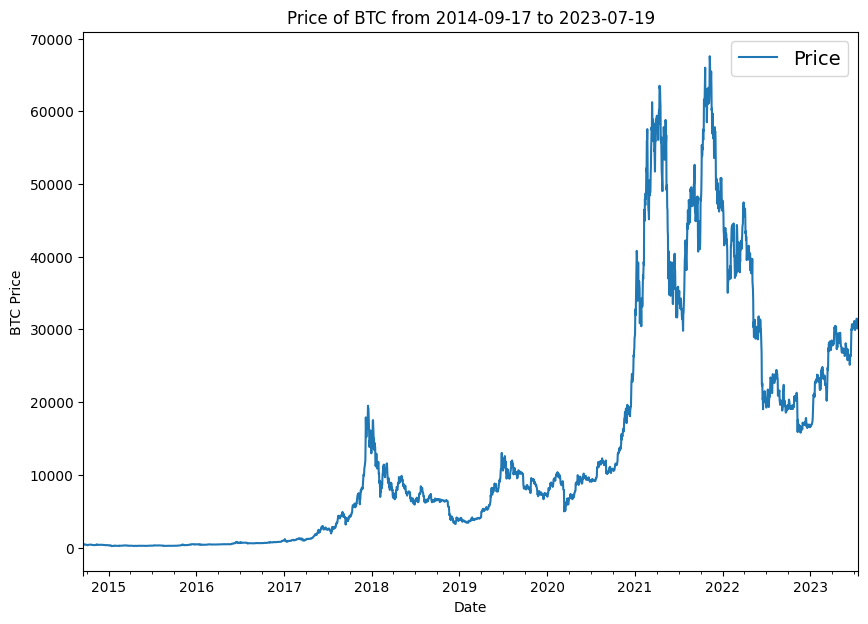

In [ ]:
btc_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of BTC from 2014-09-17 to 2023-07-19")
plt.legend(fontsize=14);

In [ ]:
timesteps = btc_prices.index.to_numpy()
prices = btc_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

#### Scaling Data

In [ ]:
scaler = MinMaxScaler()

In [ ]:
np.expand_dims(prices, axis=1)

array([[  457.334015],
       [  424.440002],
       [  394.79599 ],
       ...,
       [30145.888672],
       [         nan],
       [29893.376953]])

In [ ]:
prices_scaled = scaler.fit_transform(np.expand_dims(prices, axis=1))
prices_scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.44470029],
       [       nan],
       [0.4409532 ]])

In [ ]:
prices_scaled = np.squeeze(prices_scaled)

#### Splitting The Data

In [ ]:
split_size = int(0.8 * len(prices))

X_train, y_train, y_train_scaled = timesteps[:split_size], prices[:split_size], prices_scaled[:split_size]
X_test, y_test, y_test_scaled = timesteps[split_size:], prices[split_size:], prices_scaled[split_size:]

len(X_train), len(y_train), len(y_train_scaled), len(X_test), len(y_test), len(y_test_scaled)

(2582, 2582, 2582, 646, 646, 646)

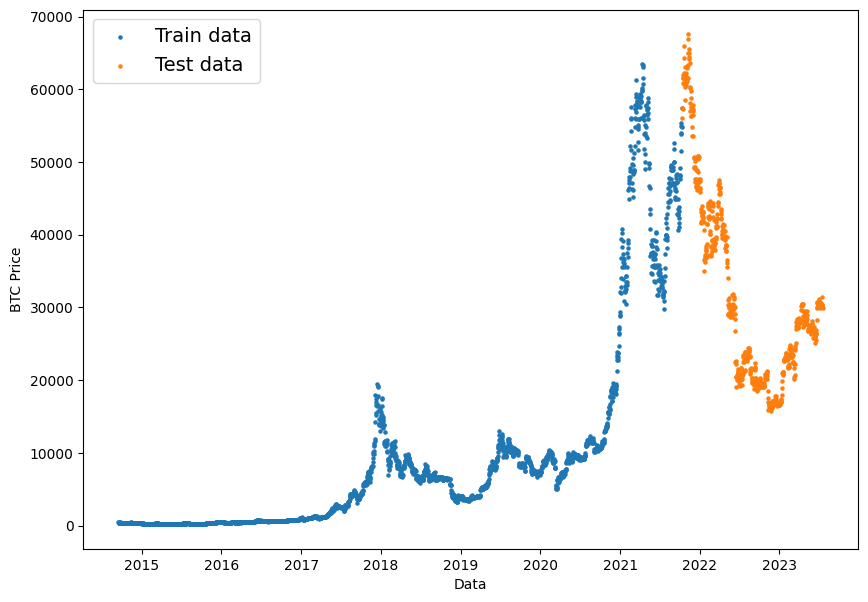

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Data')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

#### Defining Necessary Functions

In [ ]:
# function to plot time series data
def plot_time_series(dates, values, format='.', start=0, end=None, label=None):
    """
    plots timesteps (a series of points in time) against values (a series of values across time).

    Parameters
    ----------
    dates   :   array of dates
    values  :   array of values across time
    format  :   style of plot, default "."
    start   :   where to start the plot (setting a value will index from start of dates & values)
    end     :   where to end the plot (setting a value will index from end of dates & values)
    label   :   label to show on plot of values
    """
    # plot the series
    plt.plot(dates[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC Price')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implements MASE (assuming no seasonality of data)
    """
    # calculate the MAE
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # find MAE of naive forecast
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

# evaluation function
def evaluate_preds(y_true, y_pred):
    # make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

def make_preds(model, input_data, scaled=False):
    forecast = model.predict(input_data)
    if scaled:
        forecast = scaler.inverse_transform(forecast)
    return tf.squeeze(forecast)

# function for a Model Checkpoint callback
def create_model_checkpoint(model_name, save_path="model_checkpoints"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

In [ ]:
plt.figure(figsize=(15, 10))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

NameError: ignored

<Figure size 1500x1000 with 0 Axes>

#### Windowing Data

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labeled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset

    e.g. if horizon==1
    Input: [1, 2, 3, 4, 5, 6]
    Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} --> label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] --> label: 8


In [ ]:
# create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential windows of window size.
    """
    # 1. create a window of WINDOW_SIZE (add horizon on the end for later labeling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    print(f"Window step:\n{window_step}")

    # 2. create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    print(f"Window indices:\n{window_indices[:3], window_indices[-3:], window_indices.shape}")

    # 3. index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indices]

    # 4. get the labeled windows
    windows, labels = get_labeled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
[[0 1 2 3 4 5 6 7]]
Window indices:
(array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]]), array([[3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225],
       [3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226],
       [3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227]]), (3221, 8))


(3221, 3221)

In [ ]:
full_windows_scaled, full_labels_scaled = make_windows(prices_scaled, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows_scaled), len(full_labels_scaled)

Window step:
[[0 1 2 3 4 5 6 7]]
Window indices:
(array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]]), array([[3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225],
       [3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226],
       [3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227]]), (3221, 8))


(3221, 3221)

In [ ]:
# view the fist 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} --> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] --> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] --> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] --> Label: [404.424988]


In [ ]:
# view the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [30414.470703 30620.951172 30391.646484 31476.048828 30334.068359
 30295.806641 30249.132813] -> Label: [30145.888672]
Window: [30620.951172 30391.646484 31476.048828 30334.068359 30295.806641
 30249.132813 30145.888672] -> Label: [nan]
Window: [30391.646484 31476.048828 30334.068359 30295.806641 30249.132813
 30145.888672          nan] -> Label: [29893.376953]


In [ ]:
def split_train_test(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test datasets
    """
    split_size = int(len(windows) * (1-test_split)) # will default to 80% train / 20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = split_train_test(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2576, 2576, 645, 645)

In [ ]:
full_windows.shape, full_labels.shape, full_windows_scaled.shape, full_labels_scaled.shape

((3221, 7), (3221, 1), (3221, 7), (3221, 1))

In [ ]:
train_windows[:5].shape, train_labels[:5].shape

((5, 7), (5, 1))

In [ ]:
train_windows_scaled, test_windows_scaled, train_labels_scaled, test_labels_scaled = split_train_test(full_windows_scaled, full_labels_scaled)
len(train_windows_scaled), len(train_labels_scaled), len(test_windows_scaled), len(test_labels_scaled)

(2576, 2576, 645, 645)

In [ ]:
train_windows_scaled[:5].shape, train_labels_scaled[:5].shape

((5, 7), (5, 1))

In [ ]:
# check to see if same (accounting for horizon and window_size)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

#### Create Callbacks

In [ ]:
# function for a Model Checkpoint callback
def create_model_checkpoint(model_name, save_path="model_checkpoints"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

#### Recreating model_1

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

In [ ]:
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [ ]:
history_1 = model_1.fit(train_windows_scaled, train_labels_scaled,
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100


2023-07-21 01:54:44.864841: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f18d40383c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 01:54:44.865060: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-07-21 01:54:44.899769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 01:54:45.409738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-21 01:54:45.858675: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 4s 17ms/step - loss: 0.0573 - mae: 0.0573 - val_loss: nan - val_mae: nan
Epoch 2/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: nan - val_mae: nan
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0090 - mae: 0.0090 - val_loss: nan - val_mae: nan
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0078 - val_loss: nan - val_mae: nan
Epoch 5/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0080 - mae: 0.0080 - val_loss: nan - val_mae: nan
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0074 - mae: 0.0074 - val_loss: nan - val_mae: nan
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0075 - mae: 0.0075 - val_loss: nan - val_mae: nan
Epoch 8/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0068 - mae: 0.0068 - val_loss: nan - val_mae: nan
Epoch 9/100

#### Evaluating model_1

In [ ]:
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: nan - mae: nan      


[nan, nan]

In [ ]:
model_1_loaded_scaled = tf.keras.models.load_model("model_checkpoints/model_1_dense")
model_1_loaded_scaled.evaluate(test_windows_scaled, test_labels_scaled)

21/21 [==============================] - 0s 3ms/step - loss: nan - mae: nan  


[nan, nan]

In [ ]:
model_1_loaded_scaled.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: nan - mae: nan      


[nan, nan]

In [ ]:
model_1_loaded = tf.keras.models.load_model("model_checkpoints/model_1_dense")

In [ ]:
model_1_loaded.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 3ms/step - loss: nan - mae: nan      


[nan, nan]

In [ ]:
model_1_preds = make_preds(model_1_loaded, test_windows)
len(model_1_preds), model_1_preds[:10]

21/21 [==============================] - 0s 2ms/step


(645,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([56311.785, 57175.297, 57389.914, 60958.816, 61083.934, 61519.16 ,
        62100.523, 63962.234, 65776.13 , 62798.727], dtype=float32)>)

In [ ]:
model_1_preds_scaled = make_preds(model_1_loaded_scaled, test_windows_scaled, scaled=True)
len(model_1_preds_scaled), model_1_preds_scaled[:10]

21/21 [==============================] - 0s 2ms/step


(645,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([56507.055, 57372.36 , 57586.973, 61156.676, 61293.74 , 61715.598,
        62298.03 , 64160.137, 65973.94 , 62994.63 ], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_1_preds)
model_1_results

{'mae': nan, 'mse': nan, 'rmse': nan, 'mape': nan, 'mase': nan}

In [ ]:
model_1_results_scaled = evaluate_preds(tf.squeeze(test_labels),
                                          model_1_preds_scaled)
model_1_results_scaled

{'mae': nan, 'mse': nan, 'rmse': nan, 'mape': nan, 'mase': nan}

Compared with the results of model_1 with the unscaled data, this seems to be performing significantly worse.

> {'mae': 568.95123,<br>
 'mape': 2.5448983,<br>
 'mase': 0.9994897,<br>
 'mse': 1171744.0,<br>
 'rmse': 1082.4713}

#### Creating Multivariate Dataset

- Block Reward : Start Date
- 50	    : 3 January 2009 (2009-01-03)
- 25    	: 28 November 2012
- 12.5	    : 9 July 2016
- 6.25  	: 11 May 2020
- 3.125	    : TBA (expected 2024)
- 1.5625	: TBA (expected 2028)


In [ ]:
# block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# get date indices for when to add in the different block dates
block_reward_2_days = (block_reward_3_datetime - btc_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - btc_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2063)

In [ ]:
# add block_reward column to df copy
btc_prices_block = btc_prices.copy()
btc_prices_block["block_reward"] = None

# set values of block_reward column
btc_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
btc_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
btc_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
btc_prices_block.head()

Price block_reward
Date                               
2014-09-17  457.334015           25
2014-09-18  424.440002           25
2014-09-19  394.795990           25
2014-09-20  408.903992           25
2014-09-21  398.821014           25

In [ ]:
btc_prices_block['BR_scaled'] = scaler.fit_transform(np.expand_dims(btc_prices_block['block_reward'], axis=1))
btc_prices_block['pr_scaled'] = scaler.fit_transform(np.expand_dims(btc_prices_block['Price'], axis=1))

In [ ]:
btc_prices_block["block_reward"].value_counts()

block_reward
12.5    1402
6.25    1165
25       661
Name: count, dtype: int64

In [ ]:
btc_prices_block

Price block_reward  BR_scaled  pr_scaled
Date                                                       
2014-09-17    457.334015           25        1.0   0.004144
2014-09-18    424.440002           25        1.0   0.003655
2014-09-19    394.795990           25        1.0   0.003216
2014-09-20    408.903992           25        1.0   0.003425
2014-09-21    398.821014           25        1.0   0.003275
...                  ...          ...        ...        ...
2023-07-15  30295.806641         6.25        0.0   0.446925
2023-07-16  30249.132813         6.25        0.0   0.446232
2023-07-17  30145.888672         6.25        0.0   0.444700
2023-07-18           NaN         6.25        0.0        NaN
2023-07-19  29893.376953         6.25        0.0   0.440953

[3228 rows x 4 columns]

<Axes: xlabel='Date'>

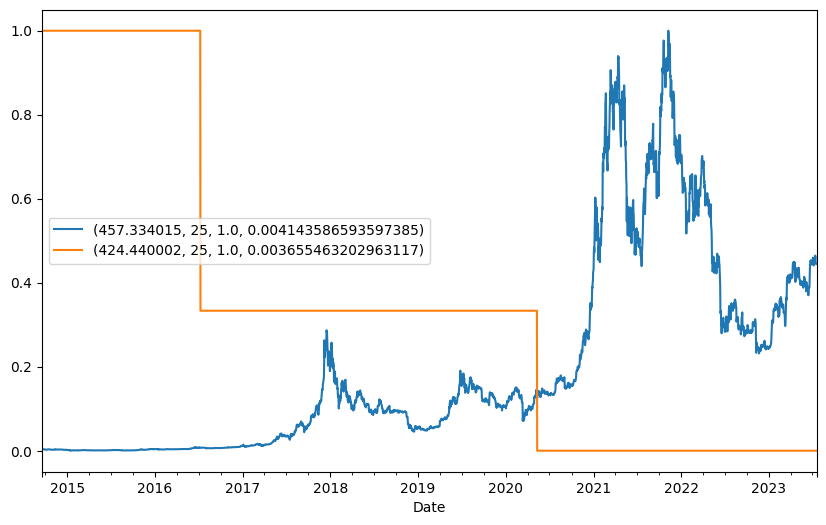

In [ ]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_price_block_df = pd.DataFrame(minmax_scale(btc_prices_block[["Price", "block_reward"]]),
                                     columns=btc_prices_block[:2],
                                     index=btc_prices_block.index)
scaled_price_block_df.plot(figsize=(10,6))

In [ ]:
# make a copy of the btc historical data with block reward
btc_windowed = btc_prices_block.copy()
btc_windowed = btc_windowed.drop(["BR_scaled", "pr_scaled"], axis=1)
# add windowed columns
for i in range(WINDOW_SIZE):    # shift values for each step in WINDOW_SIZE
    btc_windowed[f"Price+{i+1}"] = btc_windowed["Price"].shift(periods=i+1)
btc_windowed.head(10)

Price block_reward     Price+1     Price+2     Price+3  \
Date                                                                      
2014-09-17  457.334015           25         NaN         NaN         NaN   
2014-09-18  424.440002           25  457.334015         NaN         NaN   
2014-09-19  394.795990           25  424.440002  457.334015         NaN   
2014-09-20  408.903992           25  394.795990  424.440002  457.334015   
2014-09-21  398.821014           25  408.903992  394.795990  424.440002   
2014-09-22  402.152008           25  398.821014  408.903992  394.795990   
2014-09-23  435.790985           25  402.152008  398.821014  408.903992   
2014-09-24  423.204987           25  435.790985  402.152008  398.821014   
2014-09-25  411.574005           25  423.204987  435.790985  402.152008   
2014-09-26  404.424988           25  411.574005  423.204987  435.790985   

               Price+4     Price+5     Price+6     Price+7  
Date                                                        
2014-09-17         NaN         NaN         NaN         NaN  
2014-09-18         NaN         NaN         NaN         NaN  
2014-09-19         NaN         NaN         NaN         NaN  
2014-09-20         NaN         NaN         NaN         NaN  
2014-09-21  457.334015         NaN         NaN         NaN  
2014-09-22  424.440002  457.334015         NaN         NaN  
2014-09-23  394.795990  424.440002  457.334015         NaN  
2014-09-24  408.903992  394.795990  424.440002  457.334015  
2014-09-25  398.821014  408.903992  394.795990  424.440002  
2014-09-26  402.152008  398.821014  408.903992  394.795990

In [ ]:
btc_windowed_scaled = btc_prices_block.copy()
btc_windowed_scaled = btc_windowed_scaled.drop(["block_reward", "Price"], axis=1)

for i in range(WINDOW_SIZE):
    btc_windowed_scaled[f"pr_scaled+{i+1}"] = btc_windowed_scaled['pr_scaled'].shift(periods=i+1)
btc_windowed_scaled.head()

BR_scaled  pr_scaled  pr_scaled+1  pr_scaled+2  pr_scaled+3  \
Date                                                                      
2014-09-17        1.0   0.004144          NaN          NaN          NaN   
2014-09-18        1.0   0.003655     0.004144          NaN          NaN   
2014-09-19        1.0   0.003216     0.003655     0.004144          NaN   
2014-09-20        1.0   0.003425     0.003216     0.003655     0.004144   
2014-09-21        1.0   0.003275     0.003425     0.003216     0.003655   

            pr_scaled+4  pr_scaled+5  pr_scaled+6  pr_scaled+7  
Date                                                            
2014-09-17          NaN          NaN          NaN          NaN  
2014-09-18          NaN          NaN          NaN          NaN  
2014-09-19          NaN          NaN          NaN          NaN  
2014-09-20          NaN          NaN          NaN          NaN  
2014-09-21     0.004144          NaN          NaN          NaN

In [ ]:
# create X & y, remove NaN and convert to float32
X = btc_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = btc_windowed.dropna()["Price"].astype(np.float32)
X.head()

block_reward     Price+1     Price+2     Price+3     Price+4  \
Date                                                                       
2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   

               Price+5     Price+6     Price+7  
Date                                            
2014-09-24  394.795990  424.440002  457.334015  
2014-09-25  408.903992  394.795990  424.440002  
2014-09-26  398.821014  408.903992  394.795990  
2014-09-27  402.152008  398.821014  408.903992  
2014-09-28  435.790985  402.152008  398.821014

In [ ]:
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Price, dtype: float32

In [ ]:
X_scaled = btc_windowed_scaled.dropna().drop("pr_scaled", axis=1).astype(np.float32)
y_scaled = btc_windowed_scaled.dropna()["pr_scaled"].astype(np.float32)
X_scaled.head()

BR_scaled  pr_scaled+1  pr_scaled+2  pr_scaled+3  pr_scaled+4  \
Date                                                                        
2014-09-24        1.0     0.003824     0.003325     0.003275     0.003425   
2014-09-25        1.0     0.003637     0.003824     0.003325     0.003275   
2014-09-26        1.0     0.003465     0.003637     0.003824     0.003325   
2014-09-27        1.0     0.003358     0.003465     0.003637     0.003824   
2014-09-28        1.0     0.003286     0.003358     0.003465     0.003637   

            pr_scaled+5  pr_scaled+6  pr_scaled+7  
Date                                               
2014-09-24     0.003216     0.003655     0.004144  
2014-09-25     0.003425     0.003216     0.003655  
2014-09-26     0.003275     0.003425     0.003216  
2014-09-27     0.003325     0.003275     0.003425  
2014-09-28     0.003824     0.003325     0.003275

In [ ]:
y_scaled.head()

Date
2014-09-24    0.003637
2014-09-25    0.003465
2014-09-26    0.003358
2014-09-27    0.003286
2014-09-28    0.002954
Name: pr_scaled, dtype: float32

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train, X_scaled_train, y_scaled_train = X[:split_size], y[:split_size], X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test, X_scaled_test, y_scaled_test =  X[split_size:], y[split_size:], X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test), len(X_scaled_train), len(y_scaled_train), len(X_scaled_test), len(y_scaled_test)

(2575, 2575, 644, 644, 2575, 2575, 644, 644)

In [ ]:
X_train.head()

block_reward     Price+1     Price+2     Price+3     Price+4  \
Date                                                                       
2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   

               Price+5     Price+6     Price+7  
Date                                            
2014-09-24  394.795990  424.440002  457.334015  
2014-09-25  408.903992  394.795990  424.440002  
2014-09-26  398.821014  408.903992  394.795990  
2014-09-27  402.152008  398.821014  408.903992  
2014-09-28  435.790985  402.152008  398.821014

#### Recreating model_6

In [ ]:
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

In [ ]:
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

In [ ]:
history_6 = model_6.fit(X_scaled_train,
                        y_scaled_train,
                        epochs=100,
                        batch_size=128,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0257 - mae: 0.0257 - mse: 0.0026INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 2s 46ms/step - loss: 0.0224 - mae: 0.0224 - mse: 0.0021 - val_loss: 2015.7224 - val_mae: 2015.7224 - val_mse: 6807654.0000
Epoch 2/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0101 - mae: 0.0101 - mse: 4.1196e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 40ms/step - loss: 0.0106 - mae: 0.0106 - mse: 4.0738e-04 - val_loss: 1091.3364 - val_mae: 1091.3364 - val_mse: 2529857.2500
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0095 - mae: 0.0095 - mse: 2.9799e-04 - val_loss: 1369.0060 - val_mae: 1369.0060 - val_mse: 3558421.0000
Epoch 4/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0088 - mae: 0.0088 - mse: 2.6691e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 45ms/step - loss: 0.0088 - mae: 0.0088 - mse: 2.6618e-04 - val_loss: 989.3412 - val_mae: 989.3412 - val_mse: 2067199.6250
Epoch 5/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0078 - mae: 0.0078 - mse: 2.5117e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 45ms/step - loss: 0.0079 - mae: 0.0079 - mse: 2.3959e-04 - val_loss: 985.6609 - val_mae: 985.6609 - val_mse: 2078632.3750
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0077 - mae: 0.0077 - mse: 2.3395e-04 - val_loss: 1593.5012 - val_mae: 1593.5012 - val_mse: 3976267.2500
Epoch 7/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0076 - mae: 0.0076 - mse: 2.3342e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0072 - mae: 0.0072 - mse: 2.1405e-04 - val_loss: 900.7347 - val_mae: 900.7347 - val_mse: 1772366.2500
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0071 - mae: 0.0071 - mse: 1.9615e-04 - val_loss: 1042.0844 - val_mae: 1042.0844 - val_mse: 2026814.0000
Epoch 9/100
21/21 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0067 - mse: 1.7163e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 41ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.7163e-04 - val_loss: 840.7788 - val_mae: 840.7788 - val_mse: 1535278.0000
Epoch 10/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0077 - mae: 0.0077 - mse: 1.8247e-04 - val_loss: 975.6092 - val_mae: 975.6092 - val_mse: 1821740.7500
Epoch 11/100
14/21 [===================>..........] - ETA: 0s - loss: 0.0085 - mae: 0.0085 - mse: 2.0779e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 40ms/step - loss: 0.0082 - mae: 0.0082 - mse: 2.0447e-04 - val_loss: 833.2889 - val_mae: 833.2889 - val_mse: 1531460.1250
Epoch 12/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0084 - mae: 0.0084 - mse: 2.4617e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 40ms/step - loss: 0.0081 - mae: 0.0081 - mse: 2.1646e-04 - val_loss: 803.3997 - val_mae: 803.3997 - val_mse: 1434338.3750
Epoch 13/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0065 - mae: 0.0065 - mse: 1.6628e-04 - val_loss: 898.4752 - val_mae: 898.4752 - val_mse: 1604315.8750
Epoch 14/100
17/21 [=======================>......] - ETA: 0s - loss: 0.0084 - mae: 0.0084 - mse: 2.2452e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 41ms/step - loss: 0.0085 - mae: 0.0085 - mse: 2.3238e-04 - val_loss: 800.5233 - val_mae: 800.5233 - val_mse: 1400244.1250
Epoch 15/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0069 - mae: 0.0069 - mse: 1.6630e-04 - val_loss: 1560.3068 - val_mae: 1560.3068 - val_mse: 3749093.0000
Epoch 16/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0066 - mae: 0.0066 - mse: 1.8061e-04 - val_loss: 1161.4834 - val_mae: 1161.4834 - val_mse: 2315709.5000
Epoch 17/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0058 - mae: 0.0058 - mse: 1.3900e-04 - val_loss: 820.3629 - val_mae: 820.3629 - val_mse: 1407934.2500
Epoch 18/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.7250e-04 - val_loss: 1159.7286 - val_mae: 1159.7286 - val_mse: 2296159.5000
Epoch 19/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.5641e-04 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0066 - mae: 0.0066 - mse: 1.7336e-04 - val_loss: 780.5107 - val_mae: 780.5107 - val_mse: 1377613.7500
Epoch 21/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.7404e-04 - val_loss: 806.9532 - val_mae: 806.9532 - val_mse: 1446252.3750
Epoch 22/100
17/21 [=======================>......] - ETA: 0s - loss: 0.0057 - mae: 0.0057 - mse: 1.5154e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0056 - mae: 0.0056 - mse: 1.4444e-04 - val_loss: 759.8222 - val_mae: 759.8222 - val_mse: 1330553.5000
Epoch 23/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0060 - mse: 1.5508e-04 - val_loss: 1343.8054 - val_mae: 1343.8054 - val_mse: 2892955.7500
Epoch 24/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0061 - mae: 0.0061 - mse: 1.3657e-04 - val_loss: 1098.8956 - val_mae: 1098.8956 - val_mse: 2125670.0000
Epoch 25/100
16/21 [=====================>........] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mse: 1.2435e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 40ms/step - loss: 0.0059 - mae: 0.0059 - mse: 1.3231e-04 - val_loss: 746.4930 - val_mae: 746.4930 - val_mse: 1252094.7500
Epoch 26/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.2790e-04 - val_loss: 931.5178 - val_mae: 931.5178 - val_mse: 1734637.5000
Epoch 27/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0070 - mae: 0.0070 - mse: 1.5005e-04 - val_loss: 838.4814 - val_mae: 838.4814 - val_mse: 1502283.7500
Epoch 28/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.4022e-04 - val_loss: 753.1831 - val_mae: 753.1831 - val_mse: 1247796.7500
Epoch 29/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0055 - mae: 0.0055 - mse: 1.2137e-04 - val_loss: 814.5411 - val_mae: 814.5411 - val_mse: 1368109.5000
Epoch 30/100
16/21 [=====================>........] - ETA: 0s - loss: 0.0070 - mae: 0.0070 - mse: 1.5192e-04INFO:tensor

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 38ms/step - loss: 0.0071 - mae: 0.0071 - mse: 1.4559e-04 - val_loss: 740.6380 - val_mae: 740.6380 - val_mse: 1272367.6250
Epoch 31/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0081 - mae: 0.0081 - mse: 1.9752e-04 - val_loss: 1263.5044 - val_mae: 1263.5044 - val_mse: 2589376.5000
Epoch 32/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0071 - mae: 0.0071 - mse: 1.5324e-04 - val_loss: 789.3502 - val_mae: 789.3502 - val_mse: 1311668.6250
Epoch 33/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.3938e-04 - val_loss: 759.7853 - val_mae: 759.7853 - val_mse: 1254601.8750
Epoch 34/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0059 - mae: 0.0059 - mse: 1.2943e-04 - val_loss: 1546.8652 - val_mae: 1546.8652 - val_mse: 3595851.2500
Epoch 35/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.7903e-04 - v

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 38ms/step - loss: 0.0063 - mae: 0.0063 - mse: 1.7445e-04 - val_loss: 707.7452 - val_mae: 707.7452 - val_mse: 1195338.8750
Epoch 38/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0058 - mae: 0.0058 - mse: 1.3007e-04 - val_loss: 832.7742 - val_mae: 832.7742 - val_mse: 1398075.3750
Epoch 39/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0061 - mae: 0.0061 - mse: 1.3626e-04 - val_loss: 1770.3141 - val_mae: 1770.3141 - val_mse: 4490710.5000
Epoch 40/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0060 - mae: 0.0060 - mse: 1.2650e-04 - val_loss: 781.2432 - val_mae: 781.2432 - val_mse: 1355108.0000
Epoch 41/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0066 - mae: 0.0066 - mse: 1.5135e-04 - val_loss: 811.2941 - val_mae: 811.2941 - val_mse: 1421289.8750
Epoch 42/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0065 - mae: 0.0065 - mse: 1.4844e-04 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0060 - mae: 0.0060 - mse: 1.2994e-04 - val_loss: 699.3773 - val_mae: 699.3773 - val_mse: 1162323.1250
Epoch 57/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0057 - mae: 0.0057 - mse: 1.3240e-04 - val_loss: 1583.0266 - val_mae: 1583.0266 - val_mse: 3711579.0000
Epoch 58/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.5968e-04 - val_loss: 1765.1553 - val_mae: 1765.1553 - val_mse: 4452543.5000
Epoch 59/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0049 - mae: 0.0049 - mse: 1.2032e-04 - val_loss: 776.6801 - val_mae: 776.6801 - val_mse: 1329053.8750
Epoch 60/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0064 - mae: 0.0064 - mse: 1.4117e-04 - val_loss: 790.6876 - val_mae: 790.6876 - val_mse: 1298738.1250
Epoch 61/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0058 - mae: 0.0058 - mse: 1.2680e-04 - va

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.2085e-04 - val_loss: 688.6346 - val_mae: 688.6346 - val_mse: 1138126.2500
Epoch 63/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.4829e-04 - val_loss: 733.2123 - val_mae: 733.2123 - val_mse: 1192295.6250
Epoch 64/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0057 - mae: 0.0057 - mse: 1.2062e-04 - val_loss: 1097.7612 - val_mae: 1097.7612 - val_mse: 2060271.1250
Epoch 65/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0055 - mse: 1.1992e-04 - val_loss: 1369.2029 - val_mae: 1369.2029 - val_mse: 2897740.2500
Epoch 66/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0048 - mae: 0.0048 - mse: 1.1052e-04 - val_loss: 705.0267 - val_mae: 705.0267 - val_mse: 1149527.0000
Epoch 67/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.2136e-04 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 40ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.2512e-04 - val_loss: 682.9753 - val_mae: 682.9753 - val_mse: 1122959.2500
Epoch 72/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0056 - mae: 0.0056 - mse: 1.3381e-04 - val_loss: 802.8380 - val_mae: 802.8380 - val_mse: 1318135.0000
Epoch 73/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0058 - mae: 0.0058 - mse: 1.4389e-04 - val_loss: 690.0524 - val_mae: 690.0524 - val_mse: 1134271.7500
Epoch 74/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.2378e-04 - val_loss: 1713.9490 - val_mae: 1713.9490 - val_mse: 4227399.0000
Epoch 75/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.3053e-04 - val_loss: 691.9568 - val_mae: 691.9568 - val_mse: 1130295.3750
Epoch 76/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0062 - mae: 0.0062 - mse: 1.4798e-04 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42bd040>, 139743810464704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42cf3d0>, 139743810464224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a42e0280>, 139743810463024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4271190>, 139743810462864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4281040>, 139743810463344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f18a4289f10>, 139743810462224), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 39ms/step - loss: 0.0053 - mae: 0.0053 - mse: 1.1932e-04 - val_loss: 682.0902 - val_mae: 682.0902 - val_mse: 1125082.6250
Epoch 80/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0050 - mae: 0.0050 - mse: 1.1767e-04 - val_loss: 1007.5484 - val_mae: 1007.5484 - val_mse: 1803269.3750
Epoch 81/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0050 - mae: 0.0050 - mse: 1.1616e-04 - val_loss: 1052.6687 - val_mae: 1052.6687 - val_mse: 1925798.1250
Epoch 82/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0050 - mae: 0.0050 - mse: 1.1451e-04 - val_loss: 1184.0627 - val_mae: 1184.0627 - val_mse: 2298943.5000
Epoch 83/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0054 - mae: 0.0054 - mse: 1.2266e-04 - val_loss: 1156.1271 - val_mae: 1156.1271 - val_mse: 2210829.5000
Epoch 84/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0052 - mae: 0.0052 - mse: 1.2105e

#### Evaluating model_6

In [ ]:
model_6.evaluate(X_test, y_test)

21/21 [==============================] - 0s 5ms/step - loss: 789.7672 - mae: 789.7672 - mse: 1306620.2500


[789.7671508789062, 789.7671508789062, 1306620.25]

In [ ]:
model_6_loaded = tf.keras.models.load_model("model_checkpoints/model_6_dense_multivariate")
model_6_loaded.evaluate(X_test, y_test)

21/21 [==============================] - 0s 4ms/step - loss: 1012.1311 - mae: 1012.1311 - mse: 1842144.0000


[1012.131103515625, 1012.131103515625, 1842144.0]

In [ ]:
model_6_loaded_scaled = tf.keras.models.load_model("model_checkpoints/model_6_dense_multivariate")
model_6_loaded_scaled.evaluate(X_scaled_test, y_scaled_test)

21/21 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0106 - mse: 2.6046e-04


[0.010621708817780018, 0.010621708817780018, 0.00026046085986308753]

In [ ]:
model_6_preds = make_preds(model_6_loaded, X_test)
len(model_6_preds), model_6_preds[:10]

21/21 [==============================] - 0s 2ms/step


(644,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([55815.43 , 55032.574, 56037.44 , 55963.37 , 59601.895, 59929.004,
        60469.125, 60658.7  , 62550.504, 64489.71 ], dtype=float32)>)

In [ ]:
model_6_preds_scaled = make_preds(model_6_loaded_scaled, X_scaled_test, scaled=True)
len(model_6_preds_scaled), model_6_preds_scaled[:10]

21/21 [==============================] - 0s 3ms/step


(644,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([56765.992, 55984.332, 56977.67 , 56909.016, 60556.3  , 60891.066,
        61410.168, 61598.125, 63502.39 , 65449.26 ], dtype=float32)>)

In [ ]:
model_6_preds_scaled2 = make_preds(model_6_loaded_scaled, X_test)
len(model_6_preds_scaled2), model_6_preds_scaled2[:10]

21/21 [==============================] - 0s 3ms/step


(644,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47371.79 , 45726.36 , 46838.977, 46558.324, 51841.19 , 51333.055,
        51198.17 , 51152.523, 53577.977, 55553.617], dtype=float32)>)

In [ ]:
model_6_results = evaluate_preds(tf.squeeze(y_test),
                                 model_6_preds)
model_6_results

{'mae': 1012.1312,
 'mse': 1842143.8,
 'rmse': 1357.256,
 'mape': 3.2287612,
 'mase': 1.4978464}

In [ ]:
model_6_results_scaled = evaluate_preds(tf.squeeze(scaler.inverse_transform(np.expand_dims(y_scaled_test, axis=1))),
                                        model_6_preds_scaled)
model_6_results_scaled

{'mae': 715.7835,
 'mse': 1182815.2,
 'rmse': 1087.5731,
 'mape': 2.2328136,
 'mase': 1.0592835}

### 3. Setup Series Of Experiments With Different Window Sizes

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
BATCH_SIZE = 128

#### Create Functions

##### helper functions

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implements MASE (assuming no seasonality of data)
    """
    # calculate the MAE
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # find MAE of naive forecast
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

# evaluation function
def evaluate_preds(y_true, y_pred):
    # make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

def make_preds(model, input_data, scaled=False):
    forecast = model.predict(input_data)
    if scaled:
        forecast = scaler.inverse_transform(forecast)
    return tf.squeeze(forecast)

# function for a Model Checkpoint callback
def create_model_checkpoint(model_name, save_path="model_checkpoints"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

##### run experiment function

In [ ]:
scaler = MinMaxScaler()

def run_experiments(df, target_col, window_size=WINDOW_SIZE, n=2,
                    horizon=HORIZON, model_name="model_dense_x",
                    scaled=0, save_dir="model_checkpoints",
                    epochs=100, metrics=["mse"], split=0.8,
                    loss="mae", lr=0.001, verbose=1, batch_size=BATCH_SIZE):
    """
    takes a list of window_sizes
    utilizes create_ts_datasets to create datasets for all window_sizes
    utilizes build_model to build a model for all window_sizes
    compiles the models
    fits the models with model_checkpoint
    loads the saved best model for evaluation
    creates a dictionary of results

    parameters:
    window_size_list
    n (for build_model)
    horizon
    model_name (for build_model)
    dataset (for create_ts_datasets)
    scaled (for create_ts_datasets - 0, 1, 2 - 2 for both)
    save_dir (for model_checkpoint)
    epochs
    metrics
    loss
    learning_rate
    verbose (for .fit())
    """

    data_dict = {}

    if scaled == 1:
        # create scaled datasets only
        Xtrain, Xtest, ytrain, ytest, train_dates, test_dates = create_ts_datasets(df=df, target_col=target_col, window_size=window_size, split=split, scaled=True)
        data_dict = {
            "data": f"ws_{winsize}_scaled",
            "Xtrain":Xtrain,
            "Xtest":Xtest,
            "ytrain":ytrain,
            "ytest":ytest
            }
    elif scaled == 0:
        # create unscaled datasets only
        Xtrain, Xtest, ytrain, ytest, train_dates, test_dates = create_ts_datasets(df=df, target_col=target_col, window_size=window_size, split=split, scaled=False)
        data_dict = {
            "data": f"ws_{winsize}_unscaled",
            "Xtrain":Xtrain,
            "Xtest":Xtest,
            "ytrain":ytrain,
            "ytest":ytest
            }

    print(f"{train_dates}\n{test_dates}")

    model_name=f"model_{data_dict['data']}"
    print(f"\n--------------------\nbuilding {model_name}\n--------------------\n")
    model = build_model(n=2, horizon=horizon, model_name=model_name)
    X_train, X_test, y_train, y_test = data_dict['Xtrain'], data_dict['Xtest'], data_dict['ytrain'], data_dict['ytest']

    print(f"model built, compiling {model_name} with loss: {loss} & metrics: {metrics} & learning_rate: {lr}")
    model.compile(loss=loss,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=metrics)

    print(f"\n--------------------\nmodel compiled, fitting commencing now...\n--------------------\n")
    start_time = time.time()

    print(f"scaled y_test shape before fitting: {y_test.shape}")

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        verbose=verbose,
                        callbacks=[create_model_checkpoint(model.name, save_path=save_dir)])
    print(f"\n--------------------\nmodel training is complete.\n--------------------\n")
    end_time = time.time()
    duration_sec = end_time - start_time
    duration_min = duration_sec//60
    rest_sec = duration_sec%60
    print(f"\n--------------------\nTotal training time was {duration_min} minutes and {rest_sec} seconds.\n--------------------\n")

    model_loaded = tf.keras.models.load_model(os.path.join(save_dir, model.name))


    # evaluation
    print(f"\n--------------------\nmodel is being evaluated\n--------------------\n")
    model_preds = make_preds(model_loaded, X_test, scaled=scaled)

    train_preds = model_loaded.predict(X_train).flatten()
    test_preds = model_loaded.predict(X_test).flatten()

    if scaled == True:
        print(f"scaled y_test shape before inverse_transform: {y_test.shape}")
        y_eval_test = scaler.inverse_transform(np.expand_dims(y_test, axis=1))
        print(f"scaled y_test shape after inverse_transform: {y_eval_test.shape}")
    else:
        y_eval_test = y_test

    print(f"""
    \n--------------------\n
    checking shapes:
    y_eval_test: {y_eval_test.shape}\n
    tf.squeeze(y_eval_test): {tf.squeeze(y_eval_test).shape}\n
    model_preds: {model_preds.shape}
    \n--------------------\n
    """)


    model_results = evaluate_preds(tf.squeeze(y_eval_test),
                                   model_preds)

    print(f"\n--------------------\nMAE: {model_results['mae']}\nMSE: {model_results['mse']}\nRMSE: {model_results['rmse']}\nMASE: {model_results['mase']}\nMAPE: {model_results['mape']}\n--------------------\n")

    result_dict = {
        "modelname":model.name,
        "model":model_loaded,
        "window size": window_size,
        "horizon": horizon,
        "history": history,
        "time taken": f"{duration_min}m {rest_sec}s",
        "total time": duration_sec,
        "mae": model_results['mae'],
        "mse": model_results['mse'],
        "rmse": model_results['rmse'],
        "mase": model_results['mase'],
        "mape": model_results['mape'],
        "train_dates": train_dates,
        "test_dates": test_dates,
        "train_preds": train_preds,
        "X_train": X_train,
        "y_train": y_train,
        "test_preds": test_preds,
        "X_test": X_test,
        "y_test": y_test,
        "layer_num": n,
        "lr": lr
    }
    return result_dict

##### build model function

In [ ]:
def build_model(n=2, horizon=HORIZON, model_name="model_dense_x", batch_size=BATCH_SIZE):
    """
    creates a model with n (default 2) Dense(128, activation="relu") layers
    and a Dense(horizon) layer.
    """
    model = tf.keras.Sequential(name=model_name)
    if n > 1:
        for _ in range(n):
            model.add(layers.Dense(batch_size, activation="relu"))
    else:
        model.add (layers.Dense(batch_size, activation="relu"))
    model.add(layers.Dense(horizon))

    return model

##### create TS datasets function

In [ ]:
def create_ts_datasets(df, target_col, window_size=WINDOW_SIZE, split=0.8, scaled=False):
    """
    creates and returns training & testing datasets for specified window_sizes
    """
    dfx = df.copy()
    for column in dfx.columns:
        if column != target_col:
            dfx = dfx.drop(column, axis=1)

    if scaled == True:
        print("\n--------------------\nScaling data\n--------------------\n")
        for column in dfx.columns:
            dfx[column] = scaler.fit_transform(np.expand_dims(df[column], axis=1))

    # add windowed columns
    print(f"\n--------------------\nCreating windowed columns\n--------------------\n")
    for i in range(window_size):    # shift values for each step in WINDOW_SIZE
        dfx[f"{target_col}+{i+1}"] = dfx[target_col].shift(periods=i+1)
    # dfx.head(10)

    print(f"\n--------------------\nCreating X & y data\n--------------------\n")
    X = dfx.dropna().drop(target_col, axis=1).astype(np.float32)
    y = dfx.dropna()[target_col].astype(np.float32)
    # \n--------------------\n
    print(f"\n--------------------\nsplitting into train/test datasets at ratio {split}\n--------------------\n")
    split_size = int(len(X) * split)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]

    # print(f"X_train.head(1): {X_train.head(1)}\nX_test.head(): {X_test.head(1)}")
    print(f"X_train {len(X_train)} rows: \n{X_train.head()} \n")
    print(f"y_train {len(y_train)} rows: \n{y_train.head()}\n\n********************\n")
    print(f"X_test {len(X_test)} rows: \n{X_test.head()}\n")
    print(f"y_test {len(y_test)} rows: \n{y_test.head()}")

    if len(X_train) == len(y_train) and len(X_test) == len(y_test):
        print(f"\n--------------------\nX_train: {len(X_train)} \ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}\n--------------------\n")
        return (X_train, X_test, y_train, y_test, X_train.index, X_test.index)
    else:
        print("\n--------------------\nlengths do not match, aborting!\n--------------------\n")
        return (None, None, None, None, None, None)

#### Run Experiments

In [ ]:
# winsize_list = [*range(2, 5)]

In [ ]:
winsize_list = [2, 3, 4, 5, 6]

In [ ]:
# winsize_list = [3, 4, 6, 7, 8, 9, 10]

In [ ]:
winsize_results = []
for winsize in winsize_list:
    for scaled in [0, 1]:
        winsize_results.append(run_experiments(df, target_col="Close", window_size=winsize, n=4, scaled=scaled, epochs=100, verbose=1))


--------------------
Creating windowed columns
--------------------


--------------------
Creating X & y data
--------------------


--------------------
splitting into train/test datasets at ratio 0.8
--------------------

X_train 2579 rows: 
               Close+1     Close+2
Date                              
2014-09-19  424.440002  457.334015
2014-09-20  394.795990  424.440002
2014-09-21  408.903992  394.795990
2014-09-22  398.821014  408.903992
2014-09-23  402.152008  398.821014 

y_train 2579 rows: 
Date
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
2014-09-22    402.152008
2014-09-23    435.790985
Name: Close, dtype: float32

********************

X_test 645 rows: 
                 Close+1       Close+2
Date                                  
2021-10-11  54771.578125  54968.222656
2021-10-12  57484.789062  54771.578125
2021-10-13  56041.058594  57484.789062
2021-10-14  57401.097656  56041.058594
2021-10-15  57321.523438  57401.097656

y_test 645 row

2023-07-28 03:34:00.364598: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x32ed7be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-28 03:34:00.364842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-07-28 03:34:00.431192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-28 03:34:00.774401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-28 03:34:01.181155: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/21 [========================>.....] - ETA: 0s - loss: 3532.1462 - mse: 62240852.0000 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 4s 57ms/step - loss: 3283.6238 - mse: 56130124.0000 - val_loss: 2570.3132 - val_mse: 9168028.0000
Epoch 2/100
19/21 [==========================>...] - ETA: 0s - loss: 532.9684 - mse: 1422249.8750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 35ms/step - loss: 522.5347 - mse: 1377994.5000 - val_loss: 796.0365 - val_mse: 1482934.0000
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: 360.3805 - mse: 709424.3750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 37ms/step - loss: 350.1735 - mse: 678415.9375 - val_loss: 777.7794 - val_mse: 1417780.2500
Epoch 4/100
12/21 [================>.............] - ETA: 0s - loss: 310.7339 - mse: 570246.9375INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 58ms/step - loss: 321.2310 - mse: 604684.6875 - val_loss: 764.8653 - val_mse: 1379056.7500
Epoch 5/100
20/21 [===========================>..] - ETA: 0s - loss: 306.7602 - mse: 559330.5000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 307.1934 - mse: 561494.8750 - val_loss: 729.1188 - val_mse: 1275315.7500
Epoch 6/100
11/21 [==============>...............] - ETA: 0s - loss: 299.8954 - mse: 520351.4062INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 299.4001 - mse: 539020.1250 - val_loss: 721.1306 - val_mse: 1215102.0000
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 305.2943 - mse: 548247.8125 - val_loss: 816.4502 - val_mse: 1456782.3750
Epoch 8/100
21/21 [==============================] - 0s 8ms/step - loss: 306.3712 - mse: 566174.5625 - val_loss: 743.3159 - val_mse: 1221713.6250
Epoch 9/100
21/21 [==============================] - 0s 8ms/step - loss: 298.6724 - mse: 538775.3750 - val_loss: 723.9227 - val_mse: 1231762.3750
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 295.4526 - mse: 520932.6562 - val_loss: 755.9872 - val_mse: 1230305.8750
Epoch 11/100
21/21 [==============================] - 0s 8ms/step - loss: 304.0241 - mse: 561914.6875 - val_loss: 730.2448 - val_mse: 1185278.0000
Epoch 12/100
21/21 [==============================] - 0s 8ms/step - loss: 319.5063 - mse: 599698.6875 - val_loss: 752.0555 - val_mse:

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 291.8428 - mse: 520427.9375 - val_loss: 680.5173 - val_mse: 1126596.3750
Epoch 14/100
21/21 [==============================] - 0s 6ms/step - loss: 293.9984 - mse: 517074.3438 - val_loss: 968.5245 - val_mse: 1691319.0000
Epoch 15/100
21/21 [==============================] - 0s 7ms/step - loss: 312.5587 - mse: 555591.3125 - val_loss: 897.8971 - val_mse: 1621850.2500
Epoch 16/100
21/21 [==============================] - 0s 7ms/step - loss: 298.9565 - mse: 525545.6875 - val_loss: 689.6000 - val_mse: 1122824.3750
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 295.5346 - mse: 529172.8125 - val_loss: 682.3535 - val_mse: 1125122.2500
Epoch 18/100
21/21 [==============================] - 0s 7ms/step - loss: 285.5925 - mse: 506277.2812 - val_loss: 714.4985 - val_mse: 1154783.8750
Epoch 19/100
21/21 [==============================] - 0s 8ms/step - loss: 301.3761 - mse: 535585.6250 - val_loss: 683.4352 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 282.7859 - mse: 493873.0938 - val_loss: 678.4427 - val_mse: 1110378.7500
Epoch 23/100
11/21 [==============>...............] - ETA: 0s - loss: 281.1134 - mse: 480002.5312INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 291.5414 - mse: 517500.5312 - val_loss: 677.8026 - val_mse: 1113480.3750
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 286.8293 - mse: 509869.7500 - val_loss: 700.0676 - val_mse: 1161580.5000
Epoch 25/100
21/21 [==============================] - 0s 7ms/step - loss: 289.3595 - mse: 508925.4688 - val_loss: 729.6657 - val_mse: 1225057.7500
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 292.6119 - mse: 525274.2500 - val_loss: 784.1097 - val_mse: 1272851.1250
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 287.8406 - mse: 508561.8750 - val_loss: 809.2410 - val_mse: 1406144.3750
Epoch 28/100
21/21 [==============================] - 0s 6ms/step - loss: 289.5645 - mse: 519501.5312 - val_loss: 680.6758 - val_mse: 1121440.8750
Epoch 29/100
21/21 [==============================] - 0s 6ms/step - loss: 295.3892 - mse: 538213.1250 - val_loss: 750.3961 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447a0a0>, 140302824957472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8447ac70>, 140302824895280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8444ef70>, 140302824618224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84422250>, 140302824618944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84403040>, 140302824636704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a84397040>, 140302824619904), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_unscaled/assets


21/21 [==============================] - 1s 28ms/step - loss: 292.9715 - mse: 506951.3125 - val_loss: 676.9446 - val_mse: 1108074.0000
Epoch 47/100
21/21 [==============================] - 0s 6ms/step - loss: 284.7242 - mse: 498743.0000 - val_loss: 854.5397 - val_mse: 1511659.2500
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 289.0970 - mse: 506674.7812 - val_loss: 679.1052 - val_mse: 1107593.0000
Epoch 49/100
21/21 [==============================] - 0s 8ms/step - loss: 285.6871 - mse: 495550.3750 - val_loss: 1254.9474 - val_mse: 2665811.5000
Epoch 50/100
21/21 [==============================] - 0s 7ms/step - loss: 322.1217 - mse: 579627.0625 - val_loss: 678.3474 - val_mse: 1113165.0000
Epoch 51/100
21/21 [==============================] - 0s 7ms/step - loss: 284.3176 - mse: 498828.4688 - val_loss: 767.2220 - val_mse: 1241531.8750
Epoch 52/100
21/21 [==============================] - 0s 7ms/step - loss: 307.8358 - mse: 553544.4375 - val_loss: 1015.3522 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 2s 34ms/step - loss: 0.0400 - mse: 0.0106 - val_loss: 0.0136 - val_mse: 4.0974e-04
Epoch 2/100
11/21 [==============>...............] - ETA: 0s - loss: 0.0085 - mse: 1.6560e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0078 - mse: 1.7881e-04 - val_loss: 0.0124 - val_mse: 3.5800e-04
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0060 - mse: 1.3871e-04 - val_loss: 0.0149 - val_mse: 4.2799e-04
Epoch 4/100
12/21 [================>.............] - ETA: 0s - loss: 0.0059 - mse: 1.5063e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 28ms/step - loss: 0.0054 - mse: 1.3717e-04 - val_loss: 0.0115 - val_mse: 3.0541e-04
Epoch 5/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.2380e-04 - val_loss: 0.0118 - val_mse: 3.0052e-04
Epoch 6/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0050 - mse: 1.2047e-04 - val_loss: 0.0152 - val_mse: 4.1876e-04
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.2696e-04 - val_loss: 0.0185 - val_mse: 5.6613e-04
Epoch 8/100
12/21 [================>.............] - ETA: 0s - loss: 0.0055 - mse: 1.4830e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0053 - mse: 1.3787e-04 - val_loss: 0.0115 - val_mse: 2.8290e-04
Epoch 9/100
15/21 [====================>.........] - ETA: 0s - loss: 0.0050 - mse: 1.2371e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 43ms/step - loss: 0.0050 - mse: 1.1930e-04 - val_loss: 0.0108 - val_mse: 2.7200e-04
Epoch 10/100
12/21 [================>.............] - ETA: 0s - loss: 0.0048 - mse: 1.1602e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0054 - mse: 1.2348e-04 - val_loss: 0.0108 - val_mse: 2.6782e-04
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.1888e-04 - val_loss: 0.0130 - val_mse: 3.3447e-04
Epoch 12/100
12/21 [================>.............] - ETA: 0s - loss: 0.0046 - mse: 1.0046e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0048 - mse: 1.1770e-04 - val_loss: 0.0105 - val_mse: 2.5811e-04
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0049 - mse: 1.1888e-04 - val_loss: 0.0105 - val_mse: 2.5542e-04
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2106e-04 - val_loss: 0.0114 - val_mse: 2.9579e-04
Epoch 15/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.2845e-04 - val_loss: 0.0109 - val_mse: 2.6897e-04
Epoch 16/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0057 - mse: 1.2559e-04 - val_loss: 0.0130 - val_mse: 3.4310e-04
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0058 - mse: 1.3101e-04 - val_loss: 0.0110 - val_mse: 2.6504e-04
Epoch 18/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1174e-04 - val_loss: 0.0107 - val_mse: 2.6361e-04
Epoch 19/100
19/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0046 - mse: 1.1440e-04 - val_loss: 0.0103 - val_mse: 2.5044e-04
Epoch 20/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0046 - mse: 1.1412e-04 - val_loss: 0.0118 - val_mse: 3.0358e-04
Epoch 21/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0055 - mse: 1.2605e-04 - val_loss: 0.0127 - val_mse: 3.1339e-04
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.2486e-04 - val_loss: 0.0125 - val_mse: 3.2003e-04
Epoch 23/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.2013e-04 - val_loss: 0.0104 - val_mse: 2.5201e-04
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.1641e-04 - val_loss: 0.0157 - val_mse: 4.3888e-04
Epoch 25/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0056 - mse: 1.2542e-04 - val_loss: 0.0106 - val_mse: 2.5284e-04
Epoch 26/100
21/21 [===========

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0046 - mse: 1.1385e-04 - val_loss: 0.0102 - val_mse: 2.4752e-04
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.1194e-04 - val_loss: 0.0102 - val_mse: 2.4867e-04
Epoch 29/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1297e-04 - val_loss: 0.0104 - val_mse: 2.4991e-04
Epoch 30/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1276e-04 - val_loss: 0.0128 - val_mse: 3.1905e-04
Epoch 31/100
12/21 [================>.............] - ETA: 0s - loss: 0.0045 - mse: 9.9986e-05INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0047 - mse: 1.1465e-04 - val_loss: 0.0102 - val_mse: 2.4539e-04
Epoch 32/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1076e-04 - val_loss: 0.0120 - val_mse: 2.9175e-04
Epoch 33/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1648e-04 - val_loss: 0.0119 - val_mse: 3.0002e-04
Epoch 34/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1417e-04 - val_loss: 0.0113 - val_mse: 2.8217e-04
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.2477e-04 - val_loss: 0.0107 - val_mse: 2.5868e-04
Epoch 36/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.2150e-04 - val_loss: 0.0108 - val_mse: 2.5757e-04
Epoch 37/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.1842e-04 - val_loss: 0.0126 - val_mse: 3.0850e-04
Epoch 38/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c532670>, 140302825161232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c53cbe0>, 140300146087696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484eb1c0>, 140300146088896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c770850>, 140300146089376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b485b2880>, 140300145616096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b48619b80>, 140300145616816), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_2_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0048 - mse: 1.2277e-04 - val_loss: 0.0102 - val_mse: 2.4603e-04
Epoch 87/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1400e-04 - val_loss: 0.0125 - val_mse: 3.1163e-04
Epoch 88/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.1281e-04 - val_loss: 0.0108 - val_mse: 2.5759e-04
Epoch 89/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1254e-04 - val_loss: 0.0111 - val_mse: 2.6859e-04
Epoch 90/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1374e-04 - val_loss: 0.0150 - val_mse: 3.9630e-04
Epoch 91/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1572e-04 - val_loss: 0.0134 - val_mse: 3.3630e-04
Epoch 92/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.1738e-04 - val_loss: 0.0138 - val_mse: 3.7837e-04
Epoch 93/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 2s 36ms/step - loss: 4007.6133 - mse: 79702416.0000 - val_loss: 4315.4497 - val_mse: 23716424.0000
Epoch 2/100
12/21 [================>.............] - ETA: 0s - loss: 707.4399 - mse: 2266411.0000 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 602.0104 - mse: 1803579.1250 - val_loss: 883.8160 - val_mse: 1752713.3750
Epoch 3/100
17/21 [=======================>......] - ETA: 0s - loss: 390.6882 - mse: 834530.5625INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 391.3432 - mse: 821619.1875 - val_loss: 873.8595 - val_mse: 1645846.5000
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 338.7138 - mse: 659919.8750 - val_loss: 1011.3853 - val_mse: 2073439.0000
Epoch 5/100
18/21 [========================>.....] - ETA: 0s - loss: 328.1699 - mse: 608903.8750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 332.4255 - mse: 624423.5000 - val_loss: 831.7020 - val_mse: 1472589.7500
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 357.6909 - mse: 694044.4375 - val_loss: 933.8029 - val_mse: 1687999.7500
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 343.9454 - mse: 657698.3750 - val_loss: 835.9052 - val_mse: 1550766.8750
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 338.2967 - mse: 632727.7500 - val_loss: 856.9113 - val_mse: 1593967.5000
Epoch 9/100
16/21 [=====================>........] - ETA: 0s - loss: 346.5041 - mse: 698074.0000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 326.5349 - mse: 619883.0000 - val_loss: 793.4037 - val_mse: 1435232.0000
Epoch 10/100
20/21 [===========================>..] - ETA: 0s - loss: 310.1743 - mse: 569472.5000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 45ms/step - loss: 310.4199 - mse: 568884.5000 - val_loss: 790.5513 - val_mse: 1356845.0000
Epoch 11/100
20/21 [===========================>..] - ETA: 0s - loss: 301.5963 - mse: 539220.2500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 302.1665 - mse: 542294.8125 - val_loss: 754.1129 - val_mse: 1335703.0000
Epoch 12/100
21/21 [==============================] - ETA: 0s - loss: 305.3180 - mse: 543519.9375INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 305.3180 - mse: 543519.9375 - val_loss: 728.2032 - val_mse: 1237621.3750
Epoch 13/100
19/21 [==========================>...] - ETA: 0s - loss: 310.1986 - mse: 553153.0000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 310.4835 - mse: 547085.5625 - val_loss: 721.1163 - val_mse: 1225064.7500
Epoch 14/100
21/21 [==============================] - 0s 8ms/step - loss: 322.0016 - mse: 584162.6250 - val_loss: 1507.6973 - val_mse: 3635445.7500
Epoch 15/100
21/21 [==============================] - 0s 9ms/step - loss: 340.9069 - mse: 630855.1875 - val_loss: 1111.4913 - val_mse: 2251745.0000
Epoch 16/100
17/21 [=======================>......] - ETA: 0s - loss: 299.5594 - mse: 540421.1250INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 305.3846 - mse: 556998.6875 - val_loss: 713.7236 - val_mse: 1226981.7500
Epoch 17/100
21/21 [==============================] - 0s 8ms/step - loss: 293.7294 - mse: 520193.7500 - val_loss: 844.2048 - val_mse: 1443789.2500
Epoch 18/100
21/21 [==============================] - 0s 8ms/step - loss: 295.2955 - mse: 525187.7500 - val_loss: 956.7593 - val_mse: 1799130.2500
Epoch 19/100
21/21 [==============================] - 0s 8ms/step - loss: 344.5490 - mse: 657074.5625 - val_loss: 1209.4999 - val_mse: 2557078.7500
Epoch 20/100
21/21 [==============================] - 0s 7ms/step - loss: 311.1087 - mse: 543135.6875 - val_loss: 716.9589 - val_mse: 1230536.2500
Epoch 21/100
21/21 [==============================] - 0s 8ms/step - loss: 293.8321 - mse: 513642.5625 - val_loss: 758.6146 - val_mse: 1322261.1250
Epoch 22/100
19/21 [==========================>...] - ETA: 0s - loss: 292.7120 - mse: 484052.8438INFO:tensorflow:Unsupported sign

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 299.9481 - mse: 522472.5000 - val_loss: 702.1561 - val_mse: 1183342.8750
Epoch 23/100
21/21 [==============================] - 0s 8ms/step - loss: 303.4029 - mse: 530526.0625 - val_loss: 909.7475 - val_mse: 1581007.6250
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 297.8219 - mse: 514902.0312 - val_loss: 799.0731 - val_mse: 1342078.3750
Epoch 25/100
21/21 [==============================] - 0s 8ms/step - loss: 318.7510 - mse: 565926.2500 - val_loss: 1248.0465 - val_mse: 2519309.0000
Epoch 26/100
21/21 [==============================] - 0s 8ms/step - loss: 320.8857 - mse: 600848.3125 - val_loss: 731.3060 - val_mse: 1256473.8750
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 296.2760 - mse: 521128.9688 - val_loss: 753.1436 - val_mse: 1302630.7500
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 296.9471 - mse: 513595.8750 - val_loss: 756.5808 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 293.8563 - mse: 523599.2500 - val_loss: 693.1298 - val_mse: 1158700.3750
Epoch 30/100
21/21 [==============================] - 0s 8ms/step - loss: 289.0759 - mse: 503485.9062 - val_loss: 928.2248 - val_mse: 1709802.1250
Epoch 31/100
21/21 [==============================] - 0s 8ms/step - loss: 315.0482 - mse: 571051.3750 - val_loss: 1031.1295 - val_mse: 1872417.3750
Epoch 32/100
17/21 [=======================>......] - ETA: 0s - loss: 342.4292 - mse: 651429.4375INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 333.1345 - mse: 632953.8125 - val_loss: 693.0756 - val_mse: 1153887.5000
Epoch 33/100
21/21 [==============================] - 0s 8ms/step - loss: 295.5637 - mse: 518773.8125 - val_loss: 721.1877 - val_mse: 1226661.6250
Epoch 34/100
21/21 [==============================] - 0s 8ms/step - loss: 287.6304 - mse: 507568.8125 - val_loss: 740.2498 - val_mse: 1266864.0000
Epoch 35/100
21/21 [==============================] - 0s 8ms/step - loss: 295.8253 - mse: 526339.5625 - val_loss: 982.5043 - val_mse: 1741501.8750
Epoch 36/100
21/21 [==============================] - 0s 8ms/step - loss: 316.0538 - mse: 593299.6250 - val_loss: 828.3389 - val_mse: 1461717.0000
Epoch 37/100
12/21 [================>.............] - ETA: 0s - loss: 276.6846 - mse: 421383.3438INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument ob

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 297.3385 - mse: 519623.8438 - val_loss: 690.4536 - val_mse: 1143230.3750
Epoch 38/100
21/21 [==============================] - 0s 8ms/step - loss: 306.3036 - mse: 548942.9375 - val_loss: 823.6516 - val_mse: 1449770.6250
Epoch 39/100
21/21 [==============================] - 0s 7ms/step - loss: 307.1842 - mse: 537347.4375 - val_loss: 800.5150 - val_mse: 1326159.7500
Epoch 40/100
21/21 [==============================] - 0s 8ms/step - loss: 322.1067 - mse: 575920.7500 - val_loss: 774.3431 - val_mse: 1275754.8750
Epoch 41/100
20/21 [===========================>..] - ETA: 0s - loss: 297.7187 - mse: 519615.0938INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 297.8802 - mse: 520334.8438 - val_loss: 685.6156 - val_mse: 1139462.0000
Epoch 42/100
21/21 [==============================] - 0s 8ms/step - loss: 289.7752 - mse: 502048.5312 - val_loss: 715.0931 - val_mse: 1206367.0000
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 295.1014 - mse: 517854.2812 - val_loss: 743.2259 - val_mse: 1215663.0000
Epoch 44/100
21/21 [==============================] - 0s 8ms/step - loss: 296.8478 - mse: 519377.7188 - val_loss: 708.5723 - val_mse: 1189959.5000
Epoch 45/100
21/21 [==============================] - 0s 8ms/step - loss: 301.4633 - mse: 532892.1875 - val_loss: 691.9039 - val_mse: 1154208.8750
Epoch 46/100
21/21 [==============================] - 0s 8ms/step - loss: 298.3170 - mse: 517834.4688 - val_loss: 757.6632 - val_mse: 1297221.5000
Epoch 47/100
21/21 [==============================] - 0s 8ms/step - loss: 303.8846 - mse: 532963.5625 - val_loss: 762.9940 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 306.3503 - mse: 553704.0000 - val_loss: 684.4855 - val_mse: 1137729.1250
Epoch 54/100
21/21 [==============================] - 0s 10ms/step - loss: 287.0366 - mse: 506379.6250 - val_loss: 775.2198 - val_mse: 1335012.0000
Epoch 55/100
21/21 [==============================] - 0s 7ms/step - loss: 284.9357 - mse: 498797.2188 - val_loss: 686.6932 - val_mse: 1128726.7500
Epoch 56/100
21/21 [==============================] - 0s 9ms/step - loss: 289.0172 - mse: 506663.4375 - val_loss: 815.3215 - val_mse: 1426235.0000
Epoch 57/100
21/21 [==============================] - 0s 9ms/step - loss: 288.3386 - mse: 515660.0000 - val_loss: 713.2312 - val_mse: 1197933.1250
Epoch 58/100
21/21 [==============================] - 0s 8ms/step - loss: 291.4337 - mse: 508462.4688 - val_loss: 704.7615 - val_mse: 1148268.2500
Epoch 59/100
21/21 [==============================] - 0s 8ms/step - loss: 290.4516 - mse: 498436.8125 - val_loss: 697.8105 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 316.6071 - mse: 546703.8750 - val_loss: 683.1588 - val_mse: 1126278.2500
Epoch 63/100
21/21 [==============================] - 0s 7ms/step - loss: 288.8739 - mse: 511853.5312 - val_loss: 860.3458 - val_mse: 1530241.7500
Epoch 64/100
21/21 [==============================] - 0s 7ms/step - loss: 299.5281 - mse: 514479.2188 - val_loss: 726.5957 - val_mse: 1181164.5000
Epoch 65/100
21/21 [==============================] - 0s 7ms/step - loss: 294.3191 - mse: 517915.4062 - val_loss: 689.7170 - val_mse: 1145897.5000
Epoch 66/100
21/21 [==============================] - ETA: 0s - loss: 289.9115 - mse: 522278.8125INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c2f2460>, 140301616878176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a8402ad60>, 140301616878736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c432520>, 140301616881376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a840e74c0>, 140300144284176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c3e8c40>, 140301617224000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c782970>, 140300144287536), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 289.9115 - mse: 522278.8125 - val_loss: 681.6643 - val_mse: 1121616.1250
Epoch 67/100
21/21 [==============================] - 0s 7ms/step - loss: 311.3765 - mse: 553523.1875 - val_loss: 695.8179 - val_mse: 1158548.8750
Epoch 68/100
21/21 [==============================] - 0s 7ms/step - loss: 294.6471 - mse: 513473.1562 - val_loss: 693.4788 - val_mse: 1153087.2500
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 285.9471 - mse: 505135.7188 - val_loss: 837.6021 - val_mse: 1387796.5000
Epoch 70/100
21/21 [==============================] - 0s 7ms/step - loss: 306.1823 - mse: 543586.7500 - val_loss: 717.0049 - val_mse: 1202728.7500
Epoch 71/100
21/21 [==============================] - 0s 8ms/step - loss: 289.3495 - mse: 504093.5312 - val_loss: 765.7055 - val_mse: 1307941.7500
Epoch 72/100
21/21 [==============================] - 0s 8ms/step - loss: 304.1257 - mse: 539907.3750 - val_loss: 769.3691 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 2s 48ms/step - loss: 0.0277 - mse: 0.0044 - val_loss: 0.0148 - val_mse: 4.7164e-04
Epoch 2/100
17/21 [=======================>......] - ETA: 0s - loss: 0.0067 - mse: 1.7093e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 0.0066 - mse: 1.7034e-04 - val_loss: 0.0121 - val_mse: 3.3436e-04
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0058 - mse: 1.5711e-04 - val_loss: 0.0129 - val_mse: 3.5703e-04
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0054 - mse: 1.4055e-04 - val_loss: 0.0129 - val_mse: 3.6329e-04
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.4259e-04 - val_loss: 0.0130 - val_mse: 3.6377e-04
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0053 - mse: 1.3751e-04 - val_loss: 0.0132 - val_mse: 3.3462e-04
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0054 - mse: 1.2985e-04 - val_loss: 0.0188 - val_mse: 6.0608e-04
Epoch 8/100
16/21 [=====================>........] - ETA: 0s - loss: 0.0052 - mse: 1.3119e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 37ms/step - loss: 0.0052 - mse: 1.2910e-04 - val_loss: 0.0116 - val_mse: 3.0048e-04
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.2891e-04 - val_loss: 0.0166 - val_mse: 4.8441e-04
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0058 - mse: 1.3552e-04 - val_loss: 0.0127 - val_mse: 3.1879e-04
Epoch 11/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0048 - mse: 1.2078e-04 - val_loss: 0.0145 - val_mse: 3.9420e-04
Epoch 12/100
11/21 [==============>...............] - ETA: 0s - loss: 0.0058 - mse: 1.3480e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0053 - mse: 1.2897e-04 - val_loss: 0.0107 - val_mse: 2.6240e-04
Epoch 13/100
11/21 [==============>...............] - ETA: 0s - loss: 0.0046 - mse: 1.1676e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 0.0046 - mse: 1.1673e-04 - val_loss: 0.0104 - val_mse: 2.5706e-04
Epoch 14/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0047 - mse: 1.1679e-04 - val_loss: 0.0108 - val_mse: 2.7801e-04
Epoch 15/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0049 - mse: 1.1872e-04 - val_loss: 0.0110 - val_mse: 2.6836e-04
Epoch 16/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.1900e-04 - val_loss: 0.0108 - val_mse: 2.6074e-04
Epoch 17/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0057 - mse: 1.3513e-04 - val_loss: 0.0127 - val_mse: 3.2683e-04
Epoch 18/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0047 - mse: 1.1303e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 1403000719253

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0047 - mse: 1.1537e-04 - val_loss: 0.0102 - val_mse: 2.5014e-04
Epoch 19/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1607e-04 - val_loss: 0.0103 - val_mse: 2.5149e-04
Epoch 20/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1836e-04 - val_loss: 0.0125 - val_mse: 3.1469e-04
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1587e-04 - val_loss: 0.0115 - val_mse: 2.8578e-04
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1136e-04 - val_loss: 0.0103 - val_mse: 2.4992e-04
Epoch 23/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1237e-04 - val_loss: 0.0123 - val_mse: 3.0936e-04
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1483e-04 - val_loss: 0.0118 - val_mse: 2.9632e-04
Epoch 25/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 0.0050 - mse: 1.1536e-04 - val_loss: 0.0102 - val_mse: 2.4695e-04
Epoch 42/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.1579e-04 - val_loss: 0.0122 - val_mse: 3.0117e-04
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1693e-04 - val_loss: 0.0145 - val_mse: 4.0008e-04
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0058 - mse: 1.4236e-04 - val_loss: 0.0111 - val_mse: 2.6566e-04
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1845e-04 - val_loss: 0.0133 - val_mse: 3.4405e-04
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1506e-04 - val_loss: 0.0133 - val_mse: 3.4619e-04
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.2995e-04 - val_loss: 0.0118 - val_mse: 2.9848e-04
Epoch 48/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0059 - mse: 1.4799e-04 - val_loss: 0.0102 - val_mse: 2.4674e-04
Epoch 52/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2102e-04 - val_loss: 0.0108 - val_mse: 2.6416e-04
Epoch 53/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1300e-04 - val_loss: 0.0171 - val_mse: 4.8285e-04
Epoch 54/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.2456e-04 - val_loss: 0.0104 - val_mse: 2.5360e-04
Epoch 55/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1159e-04 - val_loss: 0.0161 - val_mse: 4.4915e-04
Epoch 56/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2067e-04 - val_loss: 0.0172 - val_mse: 4.8888e-04
Epoch 57/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2716e-04 - val_loss: 0.0102 - val_mse: 2.4668e-04
Epoch 58/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c207dc0>, 140300071925360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c178280>, 140300071925920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca550>, 140300071957568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10609ca0>, 140300140572144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a106613a0>, 140300021117376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c4e1070>, 140300071959488), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_3_scaled/assets


21/21 [==============================] - 1s 28ms/step - loss: 0.0044 - mse: 1.1062e-04 - val_loss: 0.0101 - val_mse: 2.4498e-04
Epoch 67/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2164e-04 - val_loss: 0.0121 - val_mse: 2.9887e-04
Epoch 68/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0051 - mse: 1.2161e-04 - val_loss: 0.0102 - val_mse: 2.4728e-04
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1682e-04 - val_loss: 0.0135 - val_mse: 3.3609e-04
Epoch 70/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.1582e-04 - val_loss: 0.0167 - val_mse: 4.8849e-04
Epoch 71/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1563e-04 - val_loss: 0.0126 - val_mse: 3.2117e-04
Epoch 72/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1406e-04 - val_loss: 0.0104 - val_mse: 2.5664e-04
Epoch 73/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 2s 34ms/step - loss: 2640.7588 - mse: 39542504.0000 - val_loss: 3137.5024 - val_mse: 12893444.0000
Epoch 2/100
11/21 [==============>...............] - ETA: 0s - loss: 633.6874 - mse: 1749361.5000 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 553.2634 - mse: 1466526.2500 - val_loss: 1456.1399 - val_mse: 3734376.0000
Epoch 3/100
12/21 [================>.............] - ETA: 0s - loss: 396.9738 - mse: 855437.5000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 41ms/step - loss: 393.7386 - mse: 840357.6250 - val_loss: 919.0089 - val_mse: 1733719.7500
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 373.5794 - mse: 739093.4375 - val_loss: 990.4755 - val_mse: 1865509.7500
Epoch 5/100
16/21 [=====================>........] - ETA: 0s - loss: 373.6126 - mse: 791418.8125 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 356.0021 - mse: 720030.6875 - val_loss: 871.4188 - val_mse: 1637167.1250
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 350.5260 - mse: 687202.5000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 350.5260 - mse: 687202.5000 - val_loss: 775.2399 - val_mse: 1377846.5000
Epoch 7/100
21/21 [==============================] - ETA: 0s - loss: 318.2867 - mse: 586661.8125INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 318.2867 - mse: 586661.8125 - val_loss: 726.5090 - val_mse: 1214572.1250
Epoch 8/100
11/21 [==============>...............] - ETA: 0s - loss: 308.7312 - mse: 557334.6875INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 307.4996 - mse: 541399.2500 - val_loss: 708.7412 - val_mse: 1174629.6250
Epoch 9/100
21/21 [==============================] - 0s 8ms/step - loss: 301.7204 - mse: 549714.7500 - val_loss: 947.0574 - val_mse: 1649235.7500
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 329.5474 - mse: 607534.6875 - val_loss: 878.2167 - val_mse: 1483781.7500
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 311.0483 - mse: 567902.1250 - val_loss: 1140.5905 - val_mse: 2313361.7500
Epoch 12/100
21/21 [==============================] - 0s 7ms/step - loss: 371.0913 - mse: 680871.8125 - val_loss: 989.2469 - val_mse: 1750423.6250
Epoch 13/100
21/21 [==============================] - 0s 7ms/step - loss: 324.5725 - mse: 583996.1250 - val_loss: 862.0996 - val_mse: 1542529.0000
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 334.4189 - mse: 626350.9375 - val_loss: 1280.9818 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 285.1691 - mse: 501169.4688 - val_loss: 687.9256 - val_mse: 1140160.0000
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 321.7017 - mse: 569864.8125 - val_loss: 817.4215 - val_mse: 1426421.0000
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 379.9952 - mse: 713731.9375 - val_loss: 690.7816 - val_mse: 1146556.8750
Epoch 23/100
21/21 [==============================] - 0s 7ms/step - loss: 307.9826 - mse: 549154.9375 - val_loss: 1068.0125 - val_mse: 2088649.3750
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 307.4738 - mse: 540011.1250 - val_loss: 695.6744 - val_mse: 1134018.2500
Epoch 25/100
21/21 [==============================] - 0s 7ms/step - loss: 302.0737 - mse: 555053.7500 - val_loss: 800.9443 - val_mse: 1313737.8750
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 295.3105 - mse: 518664.2500 - val_loss: 718.6630 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 303.1769 - mse: 548153.1250 - val_loss: 680.8369 - val_mse: 1123304.5000
Epoch 30/100
21/21 [==============================] - 0s 7ms/step - loss: 288.7020 - mse: 515050.0312 - val_loss: 748.4902 - val_mse: 1215614.3750
Epoch 31/100
21/21 [==============================] - 0s 6ms/step - loss: 286.1080 - mse: 503352.7188 - val_loss: 691.5820 - val_mse: 1127634.7500
Epoch 32/100
21/21 [==============================] - 0s 6ms/step - loss: 302.1766 - mse: 539257.5000 - val_loss: 927.9016 - val_mse: 1599173.0000
Epoch 33/100
21/21 [==============================] - 0s 7ms/step - loss: 325.3050 - mse: 606609.6875 - val_loss: 687.8489 - val_mse: 1123690.6250
Epoch 34/100
21/21 [==============================] - 0s 7ms/step - loss: 332.1699 - mse: 615058.7500 - val_loss: 1654.8367 - val_mse: 3968008.0000
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss: 367.6616 - mse: 724523.1875 - val_loss: 1261.2407 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2563ee80>, 140300029256288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a842868e0>, 140300029256048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24127b80>, 140300029259488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021610>, 140300029259248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a241a7ca0>, 140300029303984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24144490>, 140300029303744), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 289.0467 - mse: 513370.6875 - val_loss: 678.7079 - val_mse: 1119295.3750
Epoch 39/100
21/21 [==============================] - 0s 7ms/step - loss: 283.7264 - mse: 497938.4688 - val_loss: 725.3264 - val_mse: 1218894.8750
Epoch 40/100
21/21 [==============================] - 0s 7ms/step - loss: 290.0068 - mse: 510688.2188 - val_loss: 1137.5883 - val_mse: 2297631.0000
Epoch 41/100
21/21 [==============================] - 0s 7ms/step - loss: 386.0014 - mse: 771420.1875 - val_loss: 897.9916 - val_mse: 1526840.1250
Epoch 42/100
21/21 [==============================] - 0s 7ms/step - loss: 315.4526 - mse: 564819.1250 - val_loss: 811.7697 - val_mse: 1412780.0000
Epoch 43/100
21/21 [==============================] - 0s 6ms/step - loss: 290.4522 - mse: 512468.0312 - val_loss: 745.2194 - val_mse: 1208211.5000
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 291.2776 - mse: 514396.3438 - val_loss: 746.9006 - val_

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 0.0381 - mse: 0.0093 - val_loss: 0.0258 - val_mse: 0.0011
Epoch 2/100
13/21 [=================>............] - ETA: 0s - loss: 0.0086 - mse: 2.3748e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0083 - mse: 2.3195e-04 - val_loss: 0.0216 - val_mse: 7.9862e-04
Epoch 3/100
12/21 [================>.............] - ETA: 0s - loss: 0.0071 - mse: 1.8853e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 0.0073 - mse: 2.1158e-04 - val_loss: 0.0146 - val_mse: 4.5533e-04
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0065 - mse: 1.7937e-04 - val_loss: 0.0174 - val_mse: 6.0004e-04
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0062 - mse: 1.7955e-04 - val_loss: 0.0226 - val_mse: 8.4373e-04
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 0.0068 - mse: 1.9833e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 0.0068 - mse: 1.9833e-04 - val_loss: 0.0132 - val_mse: 3.6517e-04
Epoch 7/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0054 - mse: 1.3913e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0054 - mse: 1.3883e-04 - val_loss: 0.0116 - val_mse: 3.1112e-04
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.3722e-04 - val_loss: 0.0156 - val_mse: 4.5413e-04
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.3572e-04 - val_loss: 0.0179 - val_mse: 5.5689e-04
Epoch 10/100
12/21 [================>.............] - ETA: 0s - loss: 0.0052 - mse: 1.2694e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 43ms/step - loss: 0.0053 - mse: 1.3558e-04 - val_loss: 0.0114 - val_mse: 2.9434e-04
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2791e-04 - val_loss: 0.0115 - val_mse: 2.9866e-04
Epoch 12/100
19/21 [==========================>...] - ETA: 0s - loss: 0.0051 - mse: 1.3406e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 0.0050 - mse: 1.2889e-04 - val_loss: 0.0108 - val_mse: 2.7444e-04
Epoch 13/100
21/21 [==============================] - ETA: 0s - loss: 0.0047 - mse: 1.1795e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0047 - mse: 1.1795e-04 - val_loss: 0.0107 - val_mse: 2.7068e-04
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2211e-04 - val_loss: 0.0119 - val_mse: 3.1258e-04
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 0.0054 - mse: 1.3247e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0054 - mse: 1.3247e-04 - val_loss: 0.0105 - val_mse: 2.6546e-04
Epoch 16/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0051 - mse: 1.2310e-04 - val_loss: 0.0215 - val_mse: 7.2977e-04
Epoch 17/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0053 - mse: 1.2915e-04 - val_loss: 0.0153 - val_mse: 4.1900e-04
Epoch 18/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0051 - mse: 1.2738e-04 - val_loss: 0.0142 - val_mse: 3.7940e-04
Epoch 19/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2297e-04 - val_loss: 0.0119 - val_mse: 2.9794e-04
Epoch 20/100
12/21 [================>.............] - ETA: 0s - loss: 0.0046 - mse: 1.0897e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 1403000262915

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0046 - mse: 1.1429e-04 - val_loss: 0.0104 - val_mse: 2.5834e-04
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1597e-04 - val_loss: 0.0125 - val_mse: 3.1806e-04
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0055 - mse: 1.3267e-04 - val_loss: 0.0121 - val_mse: 3.0244e-04
Epoch 23/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1991e-04 - val_loss: 0.0158 - val_mse: 4.4011e-04
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0055 - mse: 1.3453e-04 - val_loss: 0.0143 - val_mse: 3.9478e-04
Epoch 25/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1736e-04 - val_loss: 0.0129 - val_mse: 3.2725e-04
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1473e-04 - val_loss: 0.0123 - val_mse: 3.2149e-04
Epoch 27/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0049 - mse: 1.2124e-04 - val_loss: 0.0103 - val_mse: 2.5333e-04
Epoch 30/100
12/21 [================>.............] - ETA: 0s - loss: 0.0048 - mse: 1.1646e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0047 - mse: 1.1546e-04 - val_loss: 0.0103 - val_mse: 2.5452e-04
Epoch 31/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0047 - mse: 1.1263e-04 - val_loss: 0.0125 - val_mse: 3.1905e-04
Epoch 32/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1405e-04 - val_loss: 0.0109 - val_mse: 2.7110e-04
Epoch 33/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2019e-04 - val_loss: 0.0107 - val_mse: 2.6334e-04
Epoch 34/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1517e-04 - val_loss: 0.0157 - val_mse: 4.2787e-04
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.1960e-04 - val_loss: 0.0111 - val_mse: 2.7037e-04
Epoch 36/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.1609e-04 - val_loss: 0.0177 - val_mse: 5.3063e-04
Epoch 37/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 0.0051 - mse: 1.3190e-04 - val_loss: 0.0103 - val_mse: 2.5181e-04
Epoch 41/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0054 - mse: 1.1950e-04 - val_loss: 0.0123 - val_mse: 3.1620e-04
Epoch 42/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1591e-04 - val_loss: 0.0124 - val_mse: 3.2536e-04
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1510e-04 - val_loss: 0.0158 - val_mse: 4.3481e-04
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1498e-04 - val_loss: 0.0109 - val_mse: 2.7324e-04
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1946e-04 - val_loss: 0.0107 - val_mse: 2.6693e-04
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1433e-04 - val_loss: 0.0103 - val_mse: 2.5068e-04
Epoch 47/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0045 - mse: 1.1614e-04 - val_loss: 0.0103 - val_mse: 2.4962e-04
Epoch 50/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1242e-04 - val_loss: 0.0132 - val_mse: 3.5688e-04
Epoch 51/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.1682e-04 - val_loss: 0.0140 - val_mse: 3.5773e-04
Epoch 52/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2280e-04 - val_loss: 0.0178 - val_mse: 5.2529e-04
Epoch 53/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2637e-04 - val_loss: 0.0104 - val_mse: 2.5178e-04
Epoch 54/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0051 - mse: 1.1854e-04 - val_loss: 0.0104 - val_mse: 2.5294e-04
Epoch 55/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1109e-04 - val_loss: 0.0121 - val_mse: 2.9952e-04
Epoch 56/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0055 - mse: 1.3832e-04 - val_loss: 0.0102 - val_mse: 2.4947e-04
Epoch 58/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0068 - mse: 1.6610e-04 - val_loss: 0.0141 - val_mse: 3.8115e-04
Epoch 59/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2316e-04 - val_loss: 0.0128 - val_mse: 3.2891e-04
Epoch 60/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2354e-04 - val_loss: 0.0105 - val_mse: 2.6021e-04
Epoch 61/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1161e-04 - val_loss: 0.0104 - val_mse: 2.5718e-04
Epoch 62/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.1536e-04 - val_loss: 0.0103 - val_mse: 2.5052e-04
Epoch 63/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1206e-04 - val_loss: 0.0105 - val_mse: 2.5368e-04
Epoch 64/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0046 - mse: 1.1532e-04 - val_loss: 0.0102 - val_mse: 2.4814e-04
Epoch 67/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.0915e-04 - val_loss: 0.0154 - val_mse: 4.1282e-04
Epoch 68/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.3178e-04 - val_loss: 0.0108 - val_mse: 2.6335e-04
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2019e-04 - val_loss: 0.0111 - val_mse: 2.6991e-04
Epoch 70/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 1.1462e-04 - val_loss: 0.0113 - val_mse: 2.8561e-04
Epoch 71/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1492e-04 - val_loss: 0.0112 - val_mse: 2.7479e-04
Epoch 72/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2767e-04 - val_loss: 0.0133 - val_mse: 3.4965e-04
Epoch 73/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0044 - mse: 1.1210e-04 - val_loss: 0.0102 - val_mse: 2.4826e-04
Epoch 81/100
21/21 [==============================] - ETA: 0s - loss: 0.0053 - mse: 1.2279e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c5ca400>, 140300026291504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a10775bb0>, 140300026291264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24021580>, 140300026315360), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24e016d0>, 140300026315120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27f04d00>, 140300026269488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2c03fd60>, 140300026269328), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_4_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0053 - mse: 1.2279e-04 - val_loss: 0.0101 - val_mse: 2.4711e-04
Epoch 82/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.3493e-04 - val_loss: 0.0103 - val_mse: 2.5553e-04
Epoch 83/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.1490e-04 - val_loss: 0.0113 - val_mse: 2.7899e-04
Epoch 84/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0047 - mse: 1.1153e-04 - val_loss: 0.0117 - val_mse: 2.8644e-04
Epoch 85/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2233e-04 - val_loss: 0.0158 - val_mse: 4.2468e-04
Epoch 86/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.2507e-04 - val_loss: 0.0103 - val_mse: 2.4977e-04
Epoch 87/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1548e-04 - val_loss: 0.0103 - val_mse: 2.5283e-04
Epoch 88/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 2s 34ms/step - loss: 2509.4219 - mse: 37259164.0000 - val_loss: 2061.6047 - val_mse: 6439313.5000
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 505.1790 - mse: 1299678.0000 - val_loss: 2505.3477 - val_mse: 9402835.0000
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 507.9205 - mse: 1280516.1250INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 44ms/step - loss: 507.9205 - mse: 1280516.1250 - val_loss: 1248.5983 - val_mse: 2814342.0000
Epoch 4/100
17/21 [=======================>......] - ETA: 0s - loss: 429.3568 - mse: 992828.5000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 438.1838 - mse: 1023703.0625 - val_loss: 1103.2888 - val_mse: 2325577.5000
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 442.2096 - mse: 966342.4375 - val_loss: 1543.1985 - val_mse: 4038422.2500
Epoch 6/100
20/21 [===========================>..] - ETA: 0s - loss: 395.8909 - mse: 854432.8125INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 394.9374 - mse: 852474.6250 - val_loss: 923.6789 - val_mse: 1848951.8750
Epoch 7/100
11/21 [==============>...............] - ETA: 0s - loss: 431.8553 - mse: 889151.7500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 428.8214 - mse: 920037.7500 - val_loss: 899.1625 - val_mse: 1754129.6250
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 404.6799 - mse: 875844.1875 - val_loss: 1130.9868 - val_mse: 2253400.2500
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 367.2051 - mse: 753762.8750 - val_loss: 1010.9062 - val_mse: 2055438.1250
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 345.3581 - mse: 691490.3125 - val_loss: 1187.0703 - val_mse: 2384401.5000
Epoch 11/100
13/21 [=================>............] - ETA: 0s - loss: 386.0067 - mse: 749539.6250INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 382.7839 - mse: 760469.6250 - val_loss: 797.9412 - val_mse: 1448145.6250
Epoch 12/100
21/21 [==============================] - ETA: 0s - loss: 317.7884 - mse: 583024.8750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 317.7884 - mse: 583024.8750 - val_loss: 729.9814 - val_mse: 1254656.7500
Epoch 13/100
21/21 [==============================] - 0s 7ms/step - loss: 309.4945 - mse: 555711.0000 - val_loss: 907.2607 - val_mse: 1699230.7500
Epoch 14/100
21/21 [==============================] - ETA: 0s - loss: 303.4758 - mse: 543364.4375INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 303.4758 - mse: 543364.4375 - val_loss: 712.0836 - val_mse: 1218195.2500
Epoch 15/100
21/21 [==============================] - 0s 7ms/step - loss: 299.2043 - mse: 537957.0000 - val_loss: 1119.6992 - val_mse: 2258918.7500
Epoch 16/100
21/21 [==============================] - 0s 7ms/step - loss: 347.9154 - mse: 659424.0000 - val_loss: 1084.2145 - val_mse: 2147857.0000
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 334.8303 - mse: 618545.6250 - val_loss: 739.3058 - val_mse: 1209854.0000
Epoch 18/100
21/21 [==============================] - 0s 7ms/step - loss: 311.8354 - mse: 575394.0625 - val_loss: 748.5180 - val_mse: 1281104.6250
Epoch 19/100
21/21 [==============================] - 0s 7ms/step - loss: 295.7605 - mse: 532853.9375 - val_loss: 733.2487 - val_mse: 1244810.5000
Epoch 20/100
21/21 [==============================] - 0s 8ms/step - loss: 291.0921 - mse: 513803.6875 - val_loss: 789.9248 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 364.8089 - mse: 743825.5625 - val_loss: 698.4017 - val_mse: 1166021.1250
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 330.7199 - mse: 606711.3750 - val_loss: 788.8530 - val_mse: 1290959.7500
Epoch 28/100
21/21 [==============================] - 0s 7ms/step - loss: 329.4468 - mse: 596668.6250 - val_loss: 703.9636 - val_mse: 1179927.0000
Epoch 29/100
21/21 [==============================] - 0s 7ms/step - loss: 293.3541 - mse: 515973.5625 - val_loss: 988.0562 - val_mse: 1858303.3750
Epoch 30/100
12/21 [================>.............] - ETA: 0s - loss: 320.2477 - mse: 564662.0000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 311.1636 - mse: 556213.6875 - val_loss: 689.5880 - val_mse: 1129189.2500
Epoch 31/100
12/21 [================>.............] - ETA: 0s - loss: 300.7086 - mse: 556350.9375 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 298.5180 - mse: 535580.1875 - val_loss: 687.6505 - val_mse: 1125579.5000
Epoch 32/100
21/21 [==============================] - 0s 7ms/step - loss: 291.8680 - mse: 518006.8125 - val_loss: 717.4412 - val_mse: 1165082.6250
Epoch 33/100
21/21 [==============================] - 0s 7ms/step - loss: 300.3858 - mse: 523161.5938 - val_loss: 694.1342 - val_mse: 1152061.5000
Epoch 34/100
21/21 [==============================] - 0s 7ms/step - loss: 301.1738 - mse: 534958.5625 - val_loss: 1036.6506 - val_mse: 1990612.0000
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss: 295.7172 - mse: 526040.5000 - val_loss: 759.2429 - val_mse: 1288762.5000
Epoch 36/100
21/21 [==============================] - 0s 8ms/step - loss: 320.3429 - mse: 566485.7500 - val_loss: 788.7833 - val_mse: 1355294.1250
Epoch 37/100
12/21 [================>.............] - ETA: 0s - loss: 296.7608 - mse: 541175.6875INFO:tensorflow:Unsupported sign

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 295.7019 - mse: 525074.5625 - val_loss: 687.5060 - val_mse: 1122412.2500
Epoch 38/100
21/21 [==============================] - 0s 7ms/step - loss: 301.4484 - mse: 538299.8750 - val_loss: 699.0132 - val_mse: 1138055.0000
Epoch 39/100
12/21 [================>.............] - ETA: 0s - loss: 312.6517 - mse: 595783.1875INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 28ms/step - loss: 302.7838 - mse: 540798.1875 - val_loss: 685.0966 - val_mse: 1127516.1250
Epoch 40/100
21/21 [==============================] - 0s 7ms/step - loss: 286.9412 - mse: 512007.0625 - val_loss: 876.4146 - val_mse: 1565695.3750
Epoch 41/100
21/21 [==============================] - 0s 7ms/step - loss: 296.3094 - mse: 520706.8750 - val_loss: 746.5725 - val_mse: 1211144.6250
Epoch 42/100
12/21 [================>.............] - ETA: 0s - loss: 287.4278 - mse: 446823.8750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 28ms/step - loss: 303.5756 - mse: 533888.5000 - val_loss: 683.0294 - val_mse: 1115638.6250
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 282.8251 - mse: 490345.5000 - val_loss: 763.6230 - val_mse: 1294715.5000
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 286.2987 - mse: 501596.7812 - val_loss: 699.4328 - val_mse: 1158375.2500
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 291.4637 - mse: 505631.7500 - val_loss: 734.2269 - val_mse: 1190885.2500
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 291.4932 - mse: 502027.4688 - val_loss: 710.6546 - val_mse: 1183299.6250
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 285.8094 - mse: 500291.9688 - val_loss: 707.3422 - val_mse: 1150332.7500
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 297.3782 - mse: 534538.7500 - val_loss: 934.2715 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27e755b0>, 140300071467008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265fdb50>, 140300071467088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2660fac0>, 140300019723040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a26624a90>, 140300019721840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a266329a0>, 140300037628752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a265ca910>, 140300037628432), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 303.3029 - mse: 529388.6250 - val_loss: 681.6354 - val_mse: 1114447.2500
Epoch 56/100
21/21 [==============================] - 0s 7ms/step - loss: 296.0209 - mse: 517662.3125 - val_loss: 827.0479 - val_mse: 1442349.5000
Epoch 57/100
21/21 [==============================] - 0s 7ms/step - loss: 322.6601 - mse: 598996.1250 - val_loss: 773.3299 - val_mse: 1257220.1250
Epoch 58/100
21/21 [==============================] - 0s 7ms/step - loss: 299.9042 - mse: 517810.7812 - val_loss: 962.8716 - val_mse: 1685156.5000
Epoch 59/100
21/21 [==============================] - 0s 7ms/step - loss: 313.2426 - mse: 546340.0000 - val_loss: 978.3877 - val_mse: 1825480.0000
Epoch 60/100
21/21 [==============================] - 0s 7ms/step - loss: 293.3855 - mse: 522106.3750 - val_loss: 699.2245 - val_mse: 1136418.1250
Epoch 61/100
21/21 [==============================] - 0s 6ms/step - loss: 290.2291 - mse: 507740.5625 - val_loss: 834.1588 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 0.0391 - mse: 0.0092 - val_loss: 0.0328 - val_mse: 0.0017
Epoch 2/100
12/21 [================>.............] - ETA: 0s - loss: 0.0087 - mse: 2.9910e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 42ms/step - loss: 0.0081 - mse: 2.8283e-04 - val_loss: 0.0143 - val_mse: 4.4978e-04
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0065 - mse: 2.1971e-04 - val_loss: 0.0156 - val_mse: 5.0570e-04
Epoch 4/100
12/21 [================>.............] - ETA: 0s - loss: 0.0062 - mse: 1.9530e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0060 - mse: 1.8628e-04 - val_loss: 0.0137 - val_mse: 4.0203e-04
Epoch 5/100
18/21 [========================>.....] - ETA: 0s - loss: 0.0057 - mse: 1.6162e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0057 - mse: 1.5634e-04 - val_loss: 0.0121 - val_mse: 3.3060e-04
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0057 - mse: 1.4959e-04 - val_loss: 0.0130 - val_mse: 3.5810e-04
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0054 - mse: 1.4469e-04 - val_loss: 0.0142 - val_mse: 3.9632e-04
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0059 - mse: 1.4712e-04 - val_loss: 0.0122 - val_mse: 3.2507e-04
Epoch 9/100
12/21 [================>.............] - ETA: 0s - loss: 0.0056 - mse: 1.3830e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0054 - mse: 1.3040e-04 - val_loss: 0.0111 - val_mse: 2.8575e-04
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2555e-04 - val_loss: 0.0115 - val_mse: 2.9394e-04
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.3099e-04 - val_loss: 0.0113 - val_mse: 2.9113e-04
Epoch 12/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.3053e-04 - val_loss: 0.0115 - val_mse: 2.9913e-04
Epoch 13/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.3195e-04 - val_loss: 0.0140 - val_mse: 3.7353e-04
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0054 - mse: 1.3174e-04 - val_loss: 0.0112 - val_mse: 2.8181e-04
Epoch 15/100
12/21 [================>.............] - ETA: 0s - loss: 0.0057 - mse: 1.5175e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0055 - mse: 1.4245e-04 - val_loss: 0.0110 - val_mse: 2.8064e-04
Epoch 16/100
12/21 [================>.............] - ETA: 0s - loss: 0.0049 - mse: 1.1585e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0049 - mse: 1.2737e-04 - val_loss: 0.0108 - val_mse: 2.7150e-04
Epoch 17/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1804e-04 - val_loss: 0.0111 - val_mse: 2.7983e-04
Epoch 18/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0049 - mse: 1.1945e-04 - val_loss: 0.0110 - val_mse: 2.7664e-04
Epoch 19/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2115e-04 - val_loss: 0.0110 - val_mse: 2.7445e-04
Epoch 20/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1811e-04 - val_loss: 0.0203 - val_mse: 6.6952e-04
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0054 - mse: 1.3105e-04 - val_loss: 0.0141 - val_mse: 3.8728e-04
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2670e-04 - val_loss: 0.0142 - val_mse: 3.7035e-04
Epoch 23/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0048 - mse: 1.2378e-04 - val_loss: 0.0106 - val_mse: 2.6258e-04
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1553e-04 - val_loss: 0.0107 - val_mse: 2.6794e-04
Epoch 25/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1525e-04 - val_loss: 0.0114 - val_mse: 2.7920e-04
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2817e-04 - val_loss: 0.0114 - val_mse: 2.7440e-04
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 1.1504e-04 - val_loss: 0.0120 - val_mse: 3.0405e-04
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.2237e-04 - val_loss: 0.0118 - val_mse: 2.9074e-04
Epoch 29/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2091e-04 - val_loss: 0.0129 - val_mse: 3.3434e-04
Epoch 30/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0051 - mse: 1.3034e-04 - val_loss: 0.0105 - val_mse: 2.5880e-04
Epoch 35/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.2077e-04 - val_loss: 0.0107 - val_mse: 2.6140e-04
Epoch 36/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1465e-04 - val_loss: 0.0118 - val_mse: 2.9357e-04
Epoch 37/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1719e-04 - val_loss: 0.0112 - val_mse: 2.7987e-04
Epoch 38/100
21/21 [==============================] - ETA: 0s - loss: 0.0045 - mse: 1.1325e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0045 - mse: 1.1325e-04 - val_loss: 0.0104 - val_mse: 2.5487e-04
Epoch 39/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1525e-04 - val_loss: 0.0104 - val_mse: 2.5622e-04
Epoch 40/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0047 - mse: 1.1157e-04 - val_loss: 0.0123 - val_mse: 3.0182e-04
Epoch 41/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1582e-04 - val_loss: 0.0105 - val_mse: 2.5907e-04
Epoch 42/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0045 - mse: 1.1484e-04 - val_loss: 0.0106 - val_mse: 2.5729e-04
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2255e-04 - val_loss: 0.0139 - val_mse: 3.5783e-04
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1312e-04 - val_loss: 0.0151 - val_mse: 4.5027e-04
Epoch 45/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a263b0820>, 140300042914272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a255552e0>, 140300042913552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264959d0>, 140300053220608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a27d499a0>, 140300053219808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2751d850>, 140300053186400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a275377f0>, 140300053184880), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_5_scaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 0.0049 - mse: 1.1469e-04 - val_loss: 0.0104 - val_mse: 2.5343e-04
Epoch 70/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0047 - mse: 1.1375e-04 - val_loss: 0.0107 - val_mse: 2.6530e-04
Epoch 71/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1744e-04 - val_loss: 0.0201 - val_mse: 6.1417e-04
Epoch 72/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.4089e-04 - val_loss: 0.0122 - val_mse: 2.8607e-04
Epoch 73/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1217e-04 - val_loss: 0.0145 - val_mse: 3.7332e-04
Epoch 74/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.2595e-04 - val_loss: 0.0111 - val_mse: 2.6749e-04
Epoch 75/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.0853e-04 - val_loss: 0.0122 - val_mse: 2.9209e-04
Epoch 76/100
21/21 [===========

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 2s 33ms/step - loss: 2760.7703 - mse: 44762376.0000 - val_loss: 3326.1526 - val_mse: 14766875.0000
Epoch 2/100
13/21 [=================>............] - ETA: 0s - loss: 724.0112 - mse: 2682458.7500 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 686.0790 - mse: 2357744.0000 - val_loss: 1421.0089 - val_mse: 3807704.2500
Epoch 3/100
12/21 [================>.............] - ETA: 0s - loss: 477.3007 - mse: 1225888.3750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 475.4852 - mse: 1203759.6250 - val_loss: 1094.0380 - val_mse: 2491837.5000
Epoch 4/100
13/21 [=================>............] - ETA: 0s - loss: 441.5472 - mse: 1034019.0625INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 426.3464 - mse: 953267.3750 - val_loss: 1026.6322 - val_mse: 2208127.2500
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 410.7129 - mse: 904739.3750INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 44ms/step - loss: 410.7129 - mse: 904739.3750 - val_loss: 844.9829 - val_mse: 1597501.0000
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 383.2118 - mse: 806221.1875 - val_loss: 944.6505 - val_mse: 1880935.7500
Epoch 7/100
21/21 [==============================] - 0s 7ms/step - loss: 350.4476 - mse: 702101.9375 - val_loss: 992.5771 - val_mse: 1855378.5000
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 339.6788 - mse: 644808.0000 - val_loss: 1312.9889 - val_mse: 2836602.0000
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 383.1829 - mse: 765596.2500 - val_loss: 1292.6014 - val_mse: 2947317.7500
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 341.0997 - mse: 644687.5625 - val_loss: 863.1884 - val_mse: 1599566.7500
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 360.1004 - mse: 708207.8125 - val_loss: 1160.9186 - val_ms

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 339.2191 - mse: 660844.5000 - val_loss: 780.3623 - val_mse: 1317117.5000
Epoch 13/100
12/21 [================>.............] - ETA: 0s - loss: 332.2841 - mse: 602151.7500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 319.0790 - mse: 594564.6875 - val_loss: 760.2352 - val_mse: 1276552.3750
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 327.5734 - mse: 617665.0000 - val_loss: 800.4354 - val_mse: 1420041.0000
Epoch 15/100
13/21 [=================>............] - ETA: 0s - loss: 307.3164 - mse: 558037.5625 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 309.7592 - mse: 566541.8125 - val_loss: 741.4813 - val_mse: 1233920.5000
Epoch 16/100
21/21 [==============================] - 0s 7ms/step - loss: 308.4453 - mse: 549932.7500 - val_loss: 986.6625 - val_mse: 1787215.8750
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 409.2127 - mse: 875960.0625 - val_loss: 1171.7990 - val_mse: 2293458.5000
Epoch 18/100
21/21 [==============================] - 0s 6ms/step - loss: 350.5433 - mse: 644448.1250 - val_loss: 806.0717 - val_mse: 1343474.6250
Epoch 19/100
21/21 [==============================] - 0s 6ms/step - loss: 338.8256 - mse: 627257.0000 - val_loss: 1026.5983 - val_mse: 2007872.0000
Epoch 20/100
21/21 [==============================] - 0s 7ms/step - loss: 332.9243 - mse: 632336.7500 - val_loss: 825.5209 - val_mse: 1466182.0000
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 329.5851 - mse: 626709.6875 - val_loss: 781.3882 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 318.5427 - mse: 592499.2500 - val_loss: 695.0854 - val_mse: 1158922.3750
Epoch 26/100
21/21 [==============================] - 0s 6ms/step - loss: 343.0060 - mse: 634058.9375 - val_loss: 1279.1290 - val_mse: 2772426.2500
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 316.1102 - mse: 555569.3750 - val_loss: 710.9011 - val_mse: 1192571.2500
Epoch 28/100
21/21 [==============================] - 0s 6ms/step - loss: 314.2282 - mse: 541715.7500 - val_loss: 1410.5490 - val_mse: 3226172.7500
Epoch 29/100
21/21 [==============================] - 0s 7ms/step - loss: 344.8783 - mse: 649499.4375 - val_loss: 705.0355 - val_mse: 1147303.1250
Epoch 30/100
21/21 [==============================] - 0s 6ms/step - loss: 295.2569 - mse: 528677.4375 - val_loss: 894.1405 - val_mse: 1618293.0000
Epoch 31/100
21/21 [==============================] - 0s 7ms/step - loss: 342.0545 - mse: 583386.5000 - val_loss: 726.5125 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 300.2651 - mse: 560734.1250 - val_loss: 686.1937 - val_mse: 1131861.0000
Epoch 43/100
21/21 [==============================] - 0s 6ms/step - loss: 336.2494 - mse: 600910.4375 - val_loss: 727.2494 - val_mse: 1226112.6250
Epoch 44/100
21/21 [==============================] - 0s 6ms/step - loss: 308.8368 - mse: 557217.7500 - val_loss: 999.6149 - val_mse: 1897298.6250
Epoch 45/100
21/21 [==============================] - 0s 7ms/step - loss: 330.5834 - mse: 606228.5000 - val_loss: 689.7885 - val_mse: 1121816.6250
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 286.7663 - mse: 508553.2812 - val_loss: 701.3522 - val_mse: 1133350.0000
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 292.6310 - mse: 514373.5000 - val_loss: 742.6348 - val_mse: 1253391.5000
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 289.7836 - mse: 522311.2188 - val_loss: 838.4208 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 315.6612 - mse: 577219.2500 - val_loss: 683.0430 - val_mse: 1113317.6250
Epoch 50/100
21/21 [==============================] - 0s 6ms/step - loss: 288.3319 - mse: 511061.2188 - val_loss: 805.7910 - val_mse: 1318118.0000
Epoch 51/100
21/21 [==============================] - 0s 7ms/step - loss: 320.3309 - mse: 565832.6250 - val_loss: 780.1976 - val_mse: 1265532.5000
Epoch 52/100
21/21 [==============================] - 0s 8ms/step - loss: 291.7126 - mse: 525461.6875 - val_loss: 799.9993 - val_mse: 1305494.7500
Epoch 53/100
21/21 [==============================] - 0s 7ms/step - loss: 337.2731 - mse: 611237.1875 - val_loss: 1633.4082 - val_mse: 4066581.5000
Epoch 54/100
21/21 [==============================] - 0s 7ms/step - loss: 349.1670 - mse: 654179.6250 - val_loss: 864.5206 - val_mse: 1438063.5000
Epoch 55/100
21/21 [==============================] - 0s 7ms/step - loss: 323.7725 - mse: 611228.2500 - val_loss: 1256.6597 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 294.1695 - mse: 530720.1250 - val_loss: 681.2208 - val_mse: 1121177.7500
Epoch 67/100
21/21 [==============================] - 0s 7ms/step - loss: 285.3896 - mse: 495298.3750 - val_loss: 767.5465 - val_mse: 1242696.0000
Epoch 68/100
21/21 [==============================] - 0s 7ms/step - loss: 324.4501 - mse: 592804.6875 - val_loss: 1123.2881 - val_mse: 2258806.7500
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 322.9377 - mse: 610109.1250 - val_loss: 915.4701 - val_mse: 1666373.6250
Epoch 70/100
21/21 [==============================] - 0s 7ms/step - loss: 314.4012 - mse: 560415.0625 - val_loss: 681.5981 - val_mse: 1112412.1250
Epoch 71/100
21/21 [==============================] - 0s 7ms/step - loss: 305.0225 - mse: 531443.5000 - val_loss: 789.0885 - val_mse: 1283096.0000
Epoch 72/100
12/21 [================>.............] - ETA: 0s - loss: 299.0322 - mse: 584455.0000INFO:tensorflow:Unsupported sign

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 294.0115 - mse: 524548.0000 - val_loss: 680.1710 - val_mse: 1110440.0000
Epoch 73/100
21/21 [==============================] - 0s 6ms/step - loss: 303.1993 - mse: 552260.3125 - val_loss: 686.6727 - val_mse: 1129632.5000
Epoch 74/100
21/21 [==============================] - 0s 7ms/step - loss: 304.5391 - mse: 565187.9375 - val_loss: 902.0095 - val_mse: 1632318.6250
Epoch 75/100
21/21 [==============================] - 0s 6ms/step - loss: 304.8886 - mse: 550813.0000 - val_loss: 698.9263 - val_mse: 1153021.3750
Epoch 76/100
21/21 [==============================] - 0s 7ms/step - loss: 292.4159 - mse: 517699.5625 - val_loss: 875.9464 - val_mse: 1563551.1250
Epoch 77/100
21/21 [==============================] - 0s 6ms/step - loss: 293.1190 - mse: 513829.5625 - val_loss: 699.6736 - val_mse: 1155089.0000
Epoch 78/100
21/21 [==============================] - 0s 7ms/step - loss: 287.0920 - mse: 500649.7500 - val_loss: 736.4182 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24f3bc40>, 140300059737264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2739a430>, 140300059737024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a273389a0>, 140300059605472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2742ca60>, 140300059605232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a264f7be0>, 140300059606832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a24fecc70>, 140300059605392), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_unscaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 287.8668 - mse: 504139.6250 - val_loss: 678.5573 - val_mse: 1112303.3750
Epoch 93/100
21/21 [==============================] - 0s 6ms/step - loss: 289.9862 - mse: 513743.5000 - val_loss: 756.8098 - val_mse: 1222610.2500
Epoch 94/100
21/21 [==============================] - 0s 6ms/step - loss: 297.0563 - mse: 511938.5938 - val_loss: 704.1949 - val_mse: 1168442.0000
Epoch 95/100
21/21 [==============================] - 0s 6ms/step - loss: 284.2941 - mse: 497388.2812 - val_loss: 709.0000 - val_mse: 1142590.7500
Epoch 96/100
21/21 [==============================] - 0s 6ms/step - loss: 309.2811 - mse: 557547.8750 - val_loss: 698.8939 - val_mse: 1157893.5000
Epoch 97/100
21/21 [==============================] - 0s 7ms/step - loss: 286.9856 - mse: 507956.8750 - val_loss: 722.5679 - val_mse: 1161549.3750
Epoch 98/100
21/21 [==============================] - 0s 6ms/step - loss: 289.0306 - mse: 514717.6250 - val_loss: 830.2191 - val_m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 0.0344 - mse: 0.0065 - val_loss: 0.0553 - val_mse: 0.0044
Epoch 2/100
12/21 [================>.............] - ETA: 0s - loss: 0.0106 - mse: 5.0133e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0096 - mse: 4.2390e-04 - val_loss: 0.0174 - val_mse: 6.1523e-04
Epoch 3/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0072 - mse: 2.5074e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0072 - mse: 2.5056e-04 - val_loss: 0.0162 - val_mse: 5.0168e-04
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0069 - mse: 2.2257e-04 - val_loss: 0.0166 - val_mse: 5.7021e-04
Epoch 5/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0061 - mse: 2.0458e-04 - val_loss: 0.0172 - val_mse: 5.9135e-04
Epoch 6/100
18/21 [========================>.....] - ETA: 0s - loss: 0.0055 - mse: 1.5582e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 34ms/step - loss: 0.0056 - mse: 1.6056e-04 - val_loss: 0.0162 - val_mse: 4.5529e-04
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0057 - mse: 1.5322e-04 - val_loss: 0.0166 - val_mse: 4.6785e-04
Epoch 8/100
20/21 [===========================>..] - ETA: 0s - loss: 0.0055 - mse: 1.4814e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 32ms/step - loss: 0.0055 - mse: 1.4727e-04 - val_loss: 0.0109 - val_mse: 2.7809e-04
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2577e-04 - val_loss: 0.0137 - val_mse: 3.7854e-04
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2544e-04 - val_loss: 0.0236 - val_mse: 8.4412e-04
Epoch 11/100
12/21 [================>.............] - ETA: 0s - loss: 0.0072 - mse: 1.9842e-04INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 44ms/step - loss: 0.0064 - mse: 1.6724e-04 - val_loss: 0.0104 - val_mse: 2.5933e-04
Epoch 12/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0057 - mse: 1.4226e-04 - val_loss: 0.0107 - val_mse: 2.7602e-04
Epoch 13/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.2924e-04 - val_loss: 0.0133 - val_mse: 3.7334e-04
Epoch 14/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2519e-04 - val_loss: 0.0125 - val_mse: 3.3338e-04
Epoch 15/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1800e-04 - val_loss: 0.0125 - val_mse: 3.2785e-04
Epoch 16/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.2710e-04 - val_loss: 0.0111 - val_mse: 2.7509e-04
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 1.2440e-04 - val_loss: 0.0127 - val_mse: 3.2636e-04
Epoch 18/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 31ms/step - loss: 0.0045 - mse: 1.1205e-04 - val_loss: 0.0104 - val_mse: 2.5093e-04
Epoch 39/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1610e-04 - val_loss: 0.0113 - val_mse: 2.7751e-04
Epoch 40/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1535e-04 - val_loss: 0.0106 - val_mse: 2.5700e-04
Epoch 41/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0043 - mse: 1.1070e-04 - val_loss: 0.0111 - val_mse: 2.7427e-04
Epoch 42/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.1387e-04 - val_loss: 0.0108 - val_mse: 2.6359e-04
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1543e-04 - val_loss: 0.0128 - val_mse: 3.1864e-04
Epoch 44/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1529e-04 - val_loss: 0.0135 - val_mse: 3.5394e-04
Epoch 45/100
11/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0047 - mse: 1.1542e-04 - val_loss: 0.0103 - val_mse: 2.4756e-04
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1366e-04 - val_loss: 0.0170 - val_mse: 4.9547e-04
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.3997e-04 - val_loss: 0.0139 - val_mse: 3.5101e-04
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 1.2417e-04 - val_loss: 0.0116 - val_mse: 2.9436e-04
Epoch 49/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1608e-04 - val_loss: 0.0146 - val_mse: 3.7615e-04
Epoch 50/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2599e-04 - val_loss: 0.0112 - val_mse: 2.6766e-04
Epoch 51/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.0988e-04 - val_loss: 0.0108 - val_mse: 2.5749e-04
Epoch 52/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 30ms/step - loss: 0.0046 - mse: 1.1569e-04 - val_loss: 0.0103 - val_mse: 2.4789e-04
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1817e-04 - val_loss: 0.0105 - val_mse: 2.5028e-04
Epoch 70/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1294e-04 - val_loss: 0.0132 - val_mse: 3.2892e-04
Epoch 71/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1497e-04 - val_loss: 0.0134 - val_mse: 3.6372e-04
Epoch 72/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.2342e-04 - val_loss: 0.0180 - val_mse: 5.4074e-04
Epoch 73/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1728e-04 - val_loss: 0.0115 - val_mse: 2.8103e-04
Epoch 74/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1621e-04 - val_loss: 0.0118 - val_mse: 2.9399e-04
Epoch 75/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 29ms/step - loss: 0.0050 - mse: 1.2033e-04 - val_loss: 0.0103 - val_mse: 2.4793e-04
Epoch 77/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1283e-04 - val_loss: 0.0126 - val_mse: 3.1389e-04
Epoch 78/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.2001e-04 - val_loss: 0.0127 - val_mse: 3.3688e-04
Epoch 79/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0048 - mse: 1.1500e-04 - val_loss: 0.0126 - val_mse: 3.1183e-04
Epoch 80/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1064e-04 - val_loss: 0.0104 - val_mse: 2.5154e-04
Epoch 81/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1147e-04 - val_loss: 0.0129 - val_mse: 3.3034e-04
Epoch 82/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1126e-04 - val_loss: 0.0119 - val_mse: 2.9415e-04
Epoch 83/100
21/21 [============

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2501b550>, 140300055856352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2514ae20>, 140300055856112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9b484057c0>, 140300055982688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a2516b730>, 140300055809440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a254e1ac0>, 140300055986048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f9a274a6f40>, 140300055984448), {}).


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_ws_6_scaled/assets


21/21 [==============================] - 1s 33ms/step - loss: 0.0045 - mse: 1.1555e-04 - val_loss: 0.0103 - val_mse: 2.4631e-04
Epoch 91/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0044 - mse: 1.1066e-04 - val_loss: 0.0105 - val_mse: 2.5290e-04
Epoch 92/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - mse: 1.1601e-04 - val_loss: 0.0116 - val_mse: 2.7694e-04
Epoch 93/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 1.1449e-04 - val_loss: 0.0129 - val_mse: 3.1150e-04
Epoch 94/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0047 - mse: 1.1068e-04 - val_loss: 0.0111 - val_mse: 2.7903e-04
Epoch 95/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 1.1339e-04 - val_loss: 0.0232 - val_mse: 8.0833e-04
Epoch 96/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 1.3192e-04 - val_loss: 0.0150 - val_mse: 3.9596e-04
Epoch 97/100
21/21 [============

#### Process Experiment Results

In [ ]:
winsize_results

[{'modelname': 'model_ws_2_unscaled',
  'model': <keras.engine.sequential.Sequential at 0x7f2df068eac0>,
  'window size': 2,
  'horizon': 1,
  'history': <keras.callbacks.History at 0x7f2df07d5a30>,
  'time taken': '0.0m 25.833214282989502s',
  'total time': 25.833214282989502,
  'mae': 677.4175,
  'mse': 1108894.5,
  'rmse': 1053.0406,
  'mase': 1.0007396,
  'mape': 2.1122177,
  'train_dates': DatetimeIndex(['2014-09-19', '2014-09-20', '2014-09-21', '2014-09-22',
                 '2014-09-23', '2014-09-24', '2014-09-25', '2014-09-26',
                 '2014-09-27', '2014-09-28',
                 ...
                 '2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
                 '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
                 '2021-10-09', '2021-10-10'],
                dtype='datetime64[ns]', name='Date', length=2579, freq=None),
  'test_dates': DatetimeIndex(['2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
                 '2021-10-15', '202

In [ ]:
for result_dict in winsize_results:
    result_dict['val_mae_hist'] = result_dict['history'].history['val_loss']
    result_dict['val_mse_hist'] = result_dict['history'].history['val_mse']
    duration_min = round(result_dict['total time'])//60
    rest_sec = round(result_dict['total time']%60)
    result_dict['duration'] = f"{duration_min}m {rest_sec}s"
    result_dict['train_mae_hist'] = result_dict['history'].history['loss']
    result_dict['train_mse_hist'] = result_dict['history'].history['mse']

In [ ]:
result_features = ['modelname',
                   'window size',
                   'duration',
                   'mae',
                   'mse',
                   'rmse',
                   'mase',
                   'mape',
                   'val_mae_hist',
                   'val_mse_hist',
                   'train_mae_hist',
                   'train_mse_hist',
                   'train_preds',
                   'y_train',
                   'X_train',
                   'test_preds',
                   'y_test',
                   'X_test',
                   'train_dates',
                   'test_dates']

res_df_list = []

for item in winsize_results:
    res_df_list.append({k:item[k] for k in result_features})

# res_df_list[:1]

#### Compare Experiment Results

In [ ]:
result_df = pd.DataFrame(res_df_list)
# result_df

In [ ]:
result_df.sort_values('mase')

modelname  window size duration         mae          mse  \
0    model_ws_2_unscaled            2   0m 25s  677.457336  1108982.625   
2    model_ws_3_unscaled            3   0m 26s  679.060059  1111871.250   
10   model_ws_7_unscaled            7   0m 28s  679.422058  1115626.250   
4    model_ws_4_unscaled            4   0m 31s  681.150513  1123710.750   
8    model_ws_6_unscaled            6   0m 30s  681.488037  1123218.750   
6    model_ws_5_unscaled            5   0m 27s  682.846436  1121227.250   
12   model_ws_8_unscaled            8   0m 29s  681.757385  1120358.000   
5      model_ws_4_scaled            4   0m 28s  683.200317  1131347.125   
1      model_ws_2_scaled            2   0m 26s  685.796631  1116977.375   
7      model_ws_5_scaled            5   0m 32s  686.314148  1126016.875   
18  model_ws_11_unscaled           11   0m 30s  684.389893  1131536.375   
3      model_ws_3_scaled            3   0m 29s  688.337097  1135794.125   
22  model_ws_13_unscaled           13   0m 32s  686.413269  1142897.750   
14   model_ws_9_unscaled            9   0m 30s  689.151428  1140344.125   
20  model_ws_12_unscaled           12   0m 29s  688.270386  1131529.750   
16  model_ws_10_unscaled           10   0m 30s  689.916199  1143787.500   
9      model_ws_6_scaled            6   0m 28s  692.238281  1128662.250   
19    model_ws_11_scaled           11   0m 24s  693.796631  1145803.625   
11     model_ws_7_scaled            7   0m 32s  695.525146  1122023.500   
13     model_ws_8_scaled            8   0m 29s  696.248657  1129875.625   
15     model_ws_9_scaled            9   0m 24s  696.332458  1145223.125   
25    model_ws_14_scaled           14   0m 30s  696.243835  1131364.750   
24  model_ws_14_unscaled           14   0m 27s  699.985779  1182173.375   
21    model_ws_12_scaled           12   0m 25s  700.011841  1168647.875   
23    model_ws_13_scaled           13   0m 28s  701.551270  1170503.375   
17    model_ws_10_scaled           10   0m 28s  707.764771  1150542.250   

           rmse      mase      mape  \
0   1053.082397  1.000798  2.112672   
2   1054.453125  1.003166  2.114112   
10  1056.232056  1.005472  2.134255   
4   1060.052246  1.006254  2.121104   
8   1059.820068  1.008530  2.136276   
6   1058.880127  1.008760  2.125691   
12  1058.469604  1.008928  2.140838   
5   1063.647949  1.009283  2.139561   
1   1056.871460  1.013118  2.148026   
7   1061.139404  1.013883  2.140895   
18  1063.736938  1.014424  2.137710   
3   1065.736450  1.016871  2.149124   
22  1069.063965  1.017424  2.152266   
14  1067.868896  1.019871  2.154184   
20  1063.733887  1.020176  2.166400   
16  1069.479980  1.021003  2.157959   
9   1062.385132  1.024439  2.181053   
19  1070.422119  1.028367  2.179193   
11  1059.256104  1.029303  2.194745   
13  1062.956055  1.030374  2.182554   
15  1070.151001  1.030498  2.173664   
25  1063.656250  1.031995  2.189284   
24  1087.277954  1.037541  2.198721   
21  1081.040161  1.037580  2.187326   
23  1081.898071  1.039862  2.211871   
17  1072.633301  1.047417  2.209800   

                                         val_mae_hist  \
0   [4532.50830078125, 1082.747802734375, 1082.462...   
2   [4251.20361328125, 1122.6585693359375, 913.037...   
10  [1270.40087890625, 1020.8231811523438, 876.926...   
4   [1757.3525390625, 1221.1085205078125, 1031.199...   
8   [1758.80029296875, 1213.22509765625, 1470.6606...   
6   [2367.49853515625, 1242.4764404296875, 969.846...   
12  [1310.0032958984375, 1092.4302978515625, 893.0...   
5   [0.015227693133056164, 0.015111040323972702, 0...   
1   [0.01891777105629444, 0.01165230292826891, 0.0...   
7   [0.028444193303585052, 0.013685203157365322, 0...   
18  [3495.833251953125, 1681.0565185546875, 1198.2...   
3   [0.013819961808621883, 0.015506064519286156, 0...   
22  [2316.486328125, 2086.3818359375, 1167.1059570...   
14  [2021.8121337890625, 1292.994384765625, 1309.4...   
20  [2441.52783203125, 880.0137939453125, 901.0602...   
16  [4498.5185546875, 2

In [ ]:
plt.figure(figsize=(20,15))
legend_list = []
for x in result_df.T:
    if str(result_df.loc[x]['modelname'])[-9:] == '_unscaled':
        legend_list.append(result_df.loc[x]['modelname'])
        plt.plot(np.sqrt(result_df.loc[x]['val_mse_hist'])[:])
plt.legend(legend_list)

NameError: ignored

<Figure size 2000x1500 with 0 Axes>

In [ ]:
dates_train[:5]

DatetimeIndex(['2014-09-19', '2014-09-20', '2014-09-21', '2014-09-22',
               '2014-09-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

#### Visualizing Predictions

In [ ]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 14.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_prices.index, y=btc_prices['Price'],
                        mode='lines',
                        name='ground truth'))
for i in range(len(winsize_results)):
    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']
    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']
    y_train = winsize_results[i]['y_train']
    y_test = winsize_results[i]['y_test']
    scaling = "unscaled"
    if winsize_results[i]['modelname'][-9:] != "_unscaled":
        test_preds = np.squeeze(scaler.inverse_transform(np.expand_dims(test_preds, axis=1)))
        scaling = "scaled"

    # fig.add_trace(go.Scatter(x=dates_train, y=train_preds,
    #                         mode='lines',
    #                         name='train_preds'))
    fig.add_trace(go.Scatter(x=dates_test, y=test_preds,
                            mode='lines',
                            name=f'preds ws {winsize_results[i]["window size"]} {scaling}'))
    # fig.add_trace(go.Scatter(x=dates_test, y=y_test,
    #                         mode='lines',
    #                         name='y_test'))
fig.update_layout(width=1200, height=400, title=winsize_results[i]['modelname'])
fig.show(renderer="colab")

    # plt.figure(figsize=(16,4))
    # plt.title(winsize_results[i]['modelname'])
    # plt.plot(dates_train, train_preds)
    # plt.plot(dates_train, y_train)
    # plt.plot(dates_test, test_preds)
    # plt.plot(dates_test, y_test)
    # plt.xlim([18560,19560])
    # plt.legend(['train preds', 'train truth', 'test preds', 'test truth'])
    # plt.show()

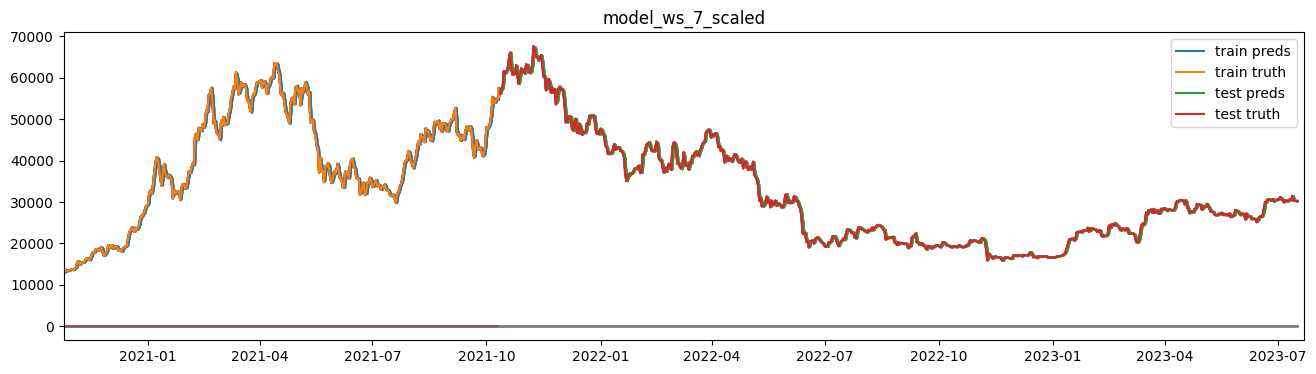

In [ ]:
plt.figure(figsize=(16,4))
for i in range(len(winsize_results)):
    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']
    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']
    y_train = winsize_results[i]['y_train']
    y_test = winsize_results[i]['y_test']

    plt.title(winsize_results[i]['modelname'])
    plt.plot(dates_train, train_preds)
    plt.plot(dates_train, y_train)
    plt.plot(dates_test, test_preds)
    plt.plot(dates_test, y_test)
plt.xlim([18560,19560])
plt.legend(['train preds', 'train truth', 'test preds', 'test truth'])
plt.show()

In [ ]:
# plt.figure()
# plt.plot(result_df['val_mae_hist'].to_numpy())
# plt.plot(np.sqrt(result_df['val_mse_hist'].to_numpy()))

#### Visualizing Performance

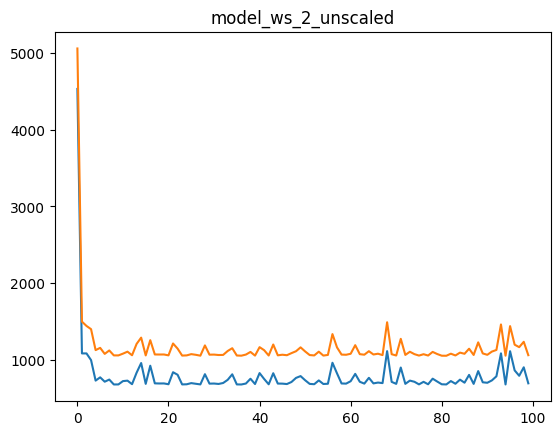

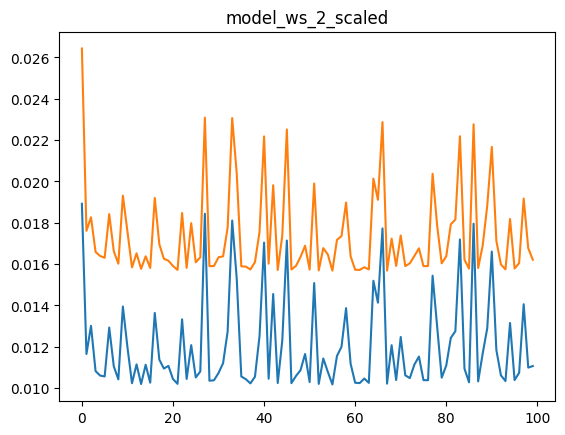

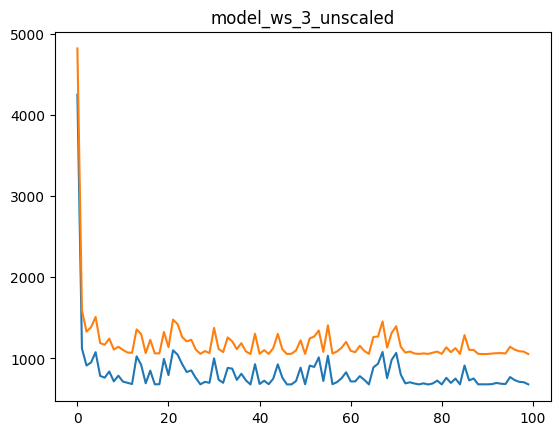

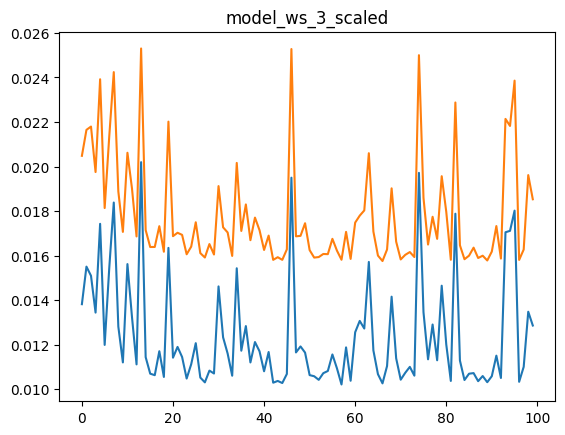

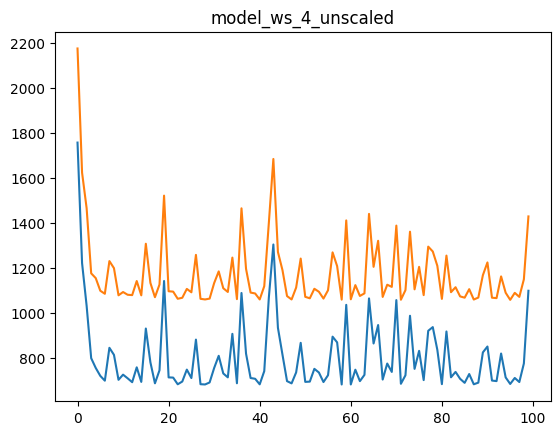

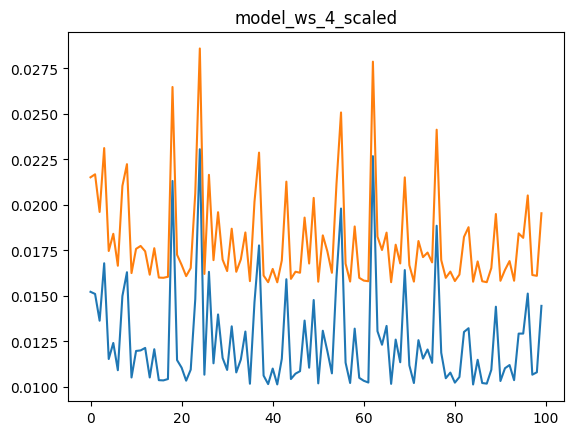

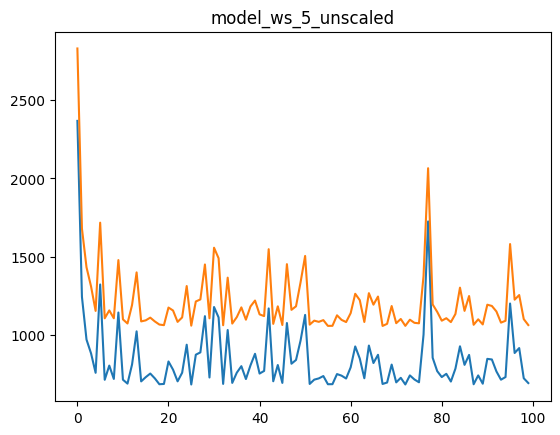

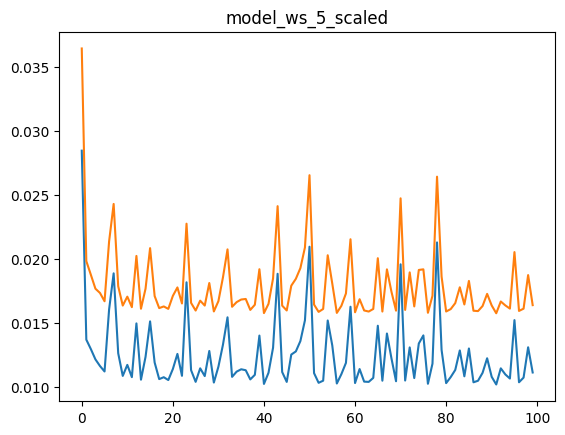

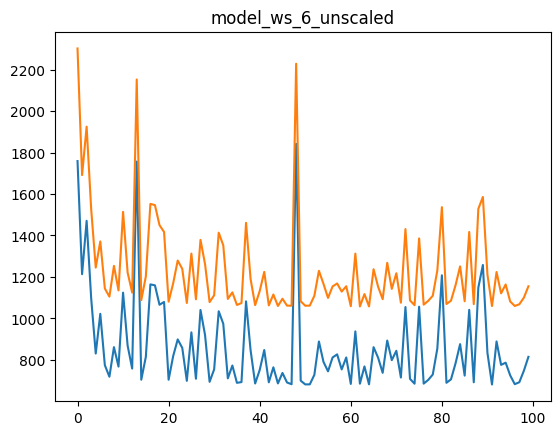

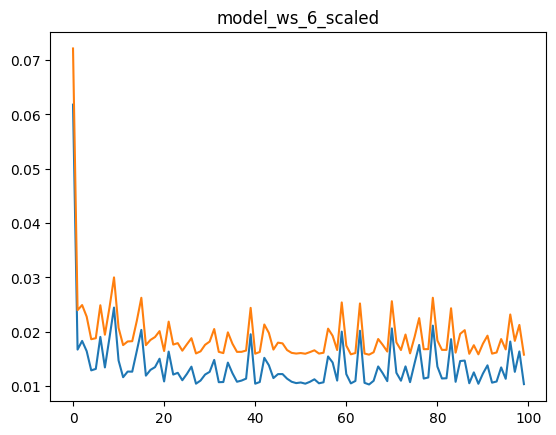

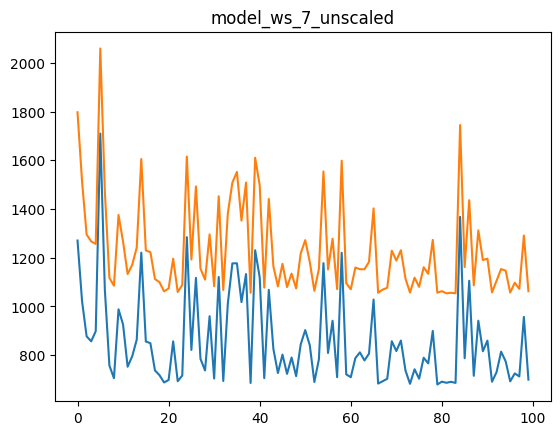

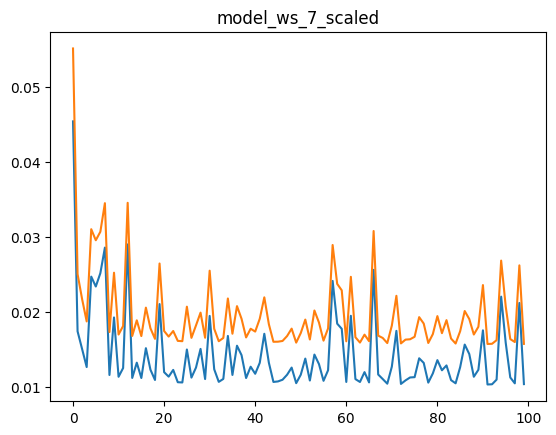

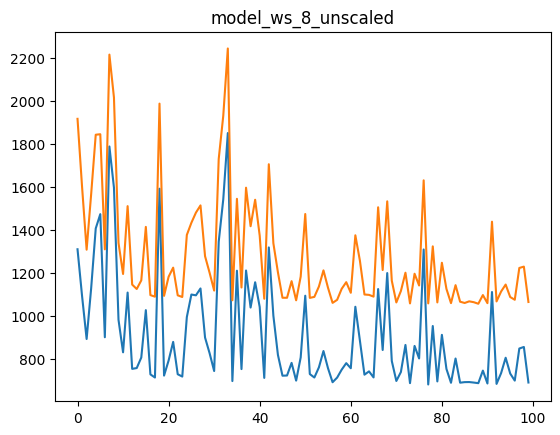

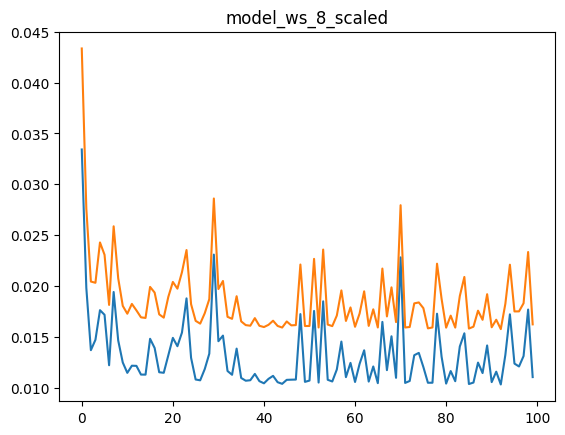

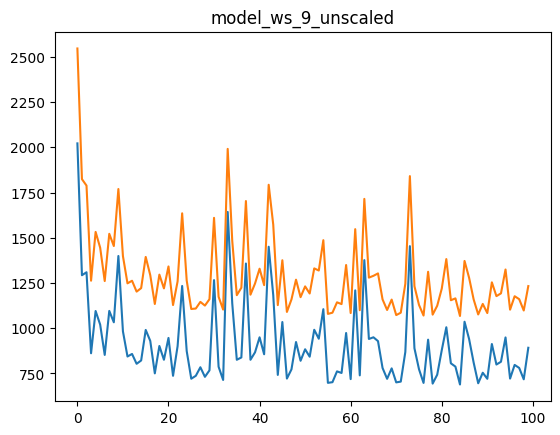

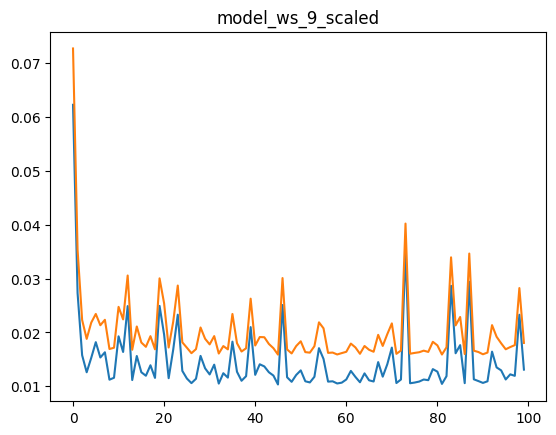

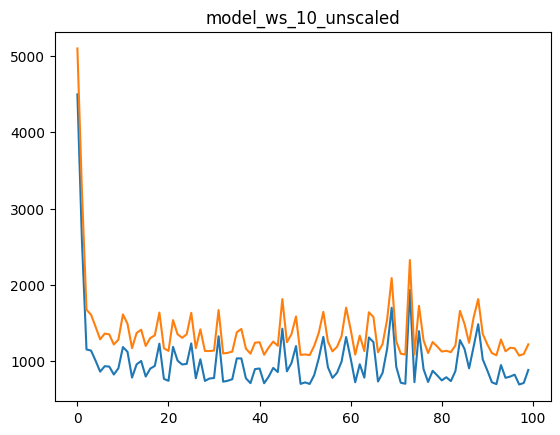

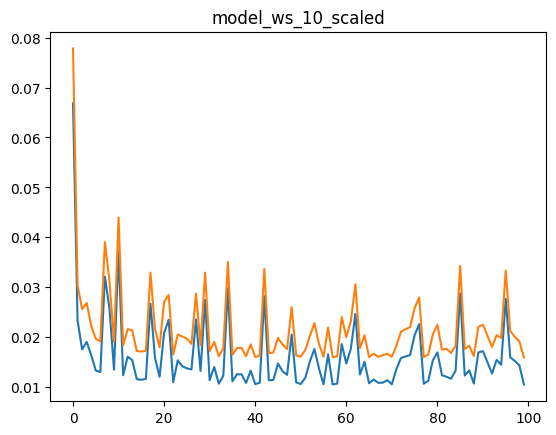

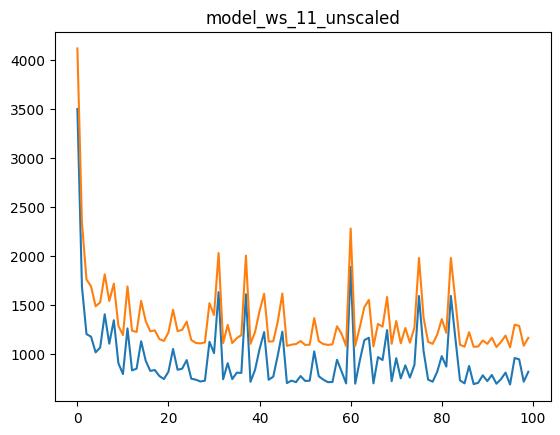

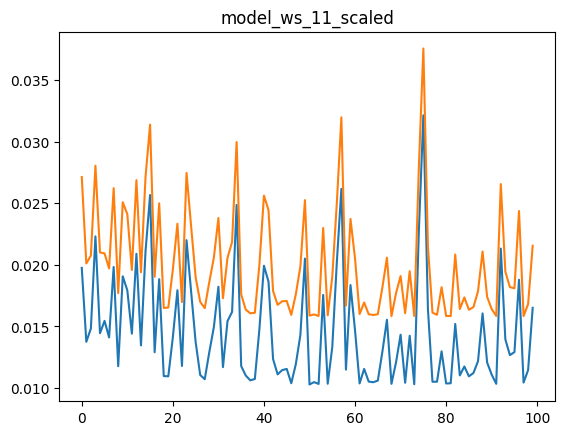

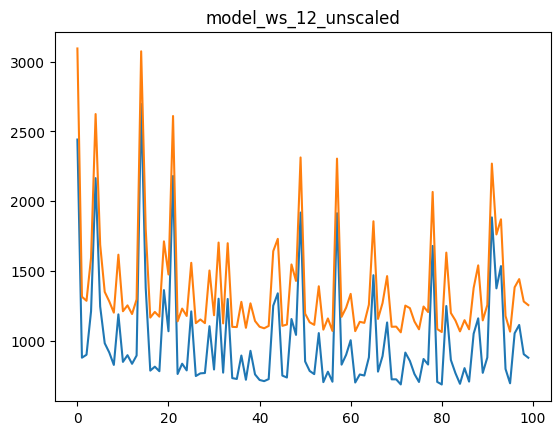

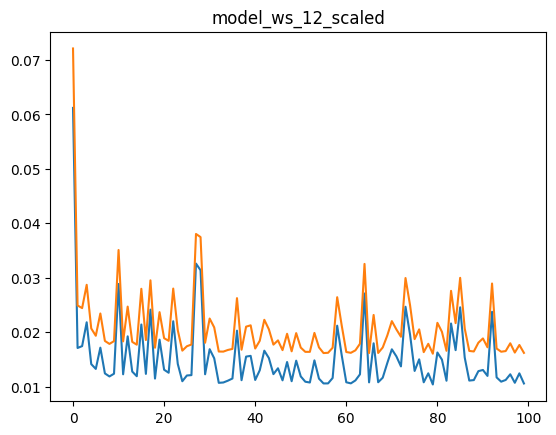

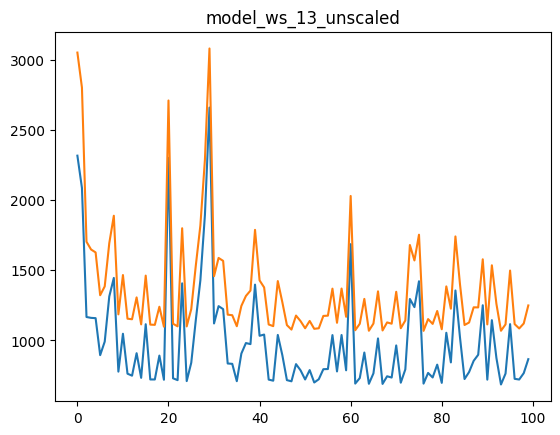

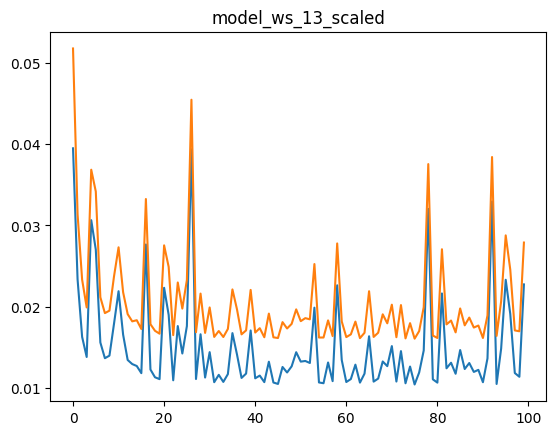

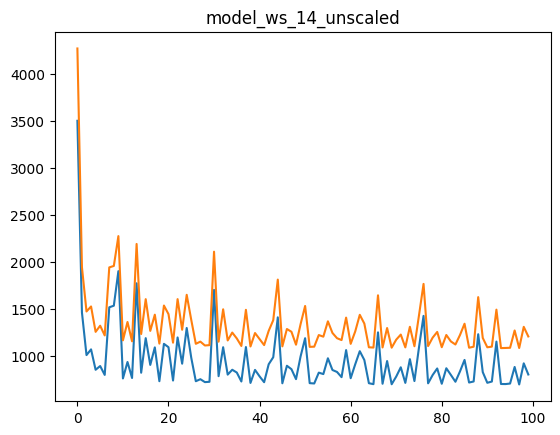

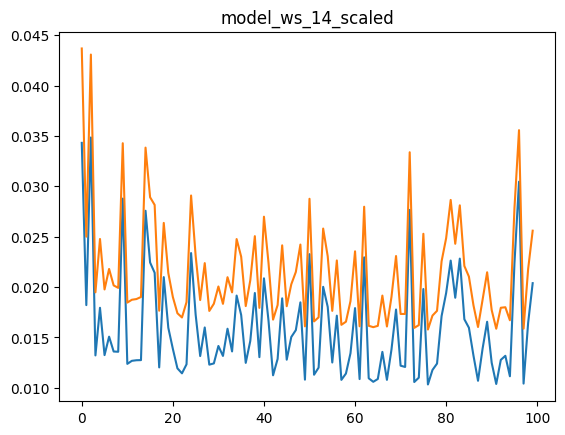

In [ ]:
for x in range(len(winsize_results)):
    plt.figure()
    plt.title(winsize_results[x]['modelname'])
    plt.plot(winsize_results[x]['history'].history['val_loss'])
    plt.plot(np.sqrt(winsize_results[x]['history'].history['val_mse']))
    plt.show()

#### Recursive Prediction

In [ ]:
for i in range(len(winsize_results)):
# for i in [2]:
    model = winsize_results[i]['model']

    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']

    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']

    X_train = winsize_results[i]['X_train']
    y_train = winsize_results[i]['y_train']
    y_test = winsize_results[i]['y_test']

    recursive_predictions = []
    recursive_dates = dates_test
    last_window = deepcopy(X_train.iloc[-1])

    # print(f"{winsize_results[i]['modelname']}")
    # print(f"shape: {last_window.shape}\n")
    # print(f"to_numpy&list: {[last_window[1:].to_numpy()]}\n")
    # if winsize_results[i]['window size'] > 2:
    #     print(f"to_numpy&list: {np.expand_dims(np.squeeze(last_window[1:]), axis=1)}\n")
    # else:
    #     print(f"[last_window[1:].to_numpy()]: {[last_window[1:].to_numpy()]}\n")
    # print(last_window[1:])
    # print(last_window[1:].shape)

    counter = 0
    start_time = time.time()

    for target_date in recursive_dates:
        if counter == 0:
            next_prediction = model.predict(np.array([last_window]), verbose=0).flatten()
        else:
            next_prediction = model.predict(np.expand_dims(np.squeeze(np.array([last_window])), axis=0), verbose=0).flatten()
        recursive_predictions.append(next_prediction)
        if counter == 0:
            if winsize_results[i]['window size'] > 2:
                last_window = np.concatenate([np.expand_dims(np.squeeze(last_window[1:]), axis=1), [next_prediction]])
            else:
                last_window = np.concatenate([[last_window[1:].to_numpy()], [next_prediction]])
        else:
            last_window = np.concatenate([last_window[1:], [next_prediction]])

        # if counter == 10:
        #     break
        if counter < 2:
            print(f"last_window: \n{last_window}\n--------------------\nnext_prediction: {next_prediction}\n********************\n")
        counter += 1
        if counter == 2:
            print(f"progress # of {len(recursive_dates)}:")
        print(f"/{counter}", end='')
        if counter %40 == 0:
            print('')
    end_time = time.time()
    total_sec = end_time - start_time
    print(f"seconds taken: {total_sec}")
    winsize_results[i]['recursive_preds'] = recursive_predictions
    winsize_results[i]['recursive_dates'] = recursive_dates

winsize_results[0]

last_window: 
[[53967.848]
 [54819.71 ]]
--------------------
next_prediction: [54819.71]
********************

/1last_window: 
[[54819.71 ]
 [53961.695]]
--------------------
next_prediction: [53961.695]
********************

progress # of 645:
/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40
/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80
/81/82/83/84/85/86/87/88/89/90/91/92/93/94/95/96/97/98/99/100/101/102/103/104/105/106/107/108/109/110/111/112/113/114/115/116/117/118/119/120
/121/122/123/124/125/126/127/128/129/130/131/132/133/134/135/136/137/138/139/140/141/142/143/144/145/146/147/148/149/150/151/152/153/154/155/156/157/158/159/160
/161/162/163/164/165/166/167/168/169/170/171/172/173/174/175/176/177/178/179/180/181/182/183/184/185/186/187/188/189/190/191/192/193/194/195/196/197/198/199/200
/201/202/203/204/205/206/207/208/209/210/211/212/213/214/21

{'modelname': 'model_ws_2_unscaled',
 'model': <keras.engine.sequential.Sequential at 0x7f355c7365e0>,
 'window size': 2,
 'horizon': 1,
 'history': <keras.callbacks.History at 0x7f34ec2ebf70>,
 'time taken': '0.0m 25.98977780342102s',
 'total time': 25.98977780342102,
 'mae': 676.5839,
 'mse': 1111112.0,
 'rmse': 1054.093,
 'mase': 0.99950814,
 'mape': 2.1109242,
 'train_dates': DatetimeIndex(['2014-09-19', '2014-09-20', '2014-09-21', '2014-09-22',
                '2014-09-23', '2014-09-24', '2014-09-25', '2014-09-26',
                '2014-09-27', '2014-09-28',
                ...
                '2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
                '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
                '2021-10-09', '2021-10-10'],
               dtype='datetime64[ns]', name='Date', length=2579, freq=None),
 'test_dates': DatetimeIndex(['2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
                '2021-10-15', '2021-10-16', '2021-10-17', 

In [ ]:
X_temp, y_temp = update_data(X_train, y_train, last_window, next_prediction, target_date)
X_temp.tail(2), y_temp.tail(2)

(                 Price+1       Price+2       Price+3       Price+4  \
 Date                                                                 
 2021-10-11  54771.578125  54968.222656  53967.847656  53805.984375   
 2023-07-17      0.553673      0.587695      0.602208      0.582462   
 
                  Price+5       Price+6       Price+7  
 Date                                                  
 2021-10-11  55361.449219  51514.812500  49112.902344  
 2023-07-17      0.553609      0.524641      0.526007  ,
 Date
 2021-10-11    57484.789062
 2023-07-17        0.526007
 Name: Price, dtype: float32)

In [ ]:
len(winsize_results)

6

In [ ]:
xrow_ws3_reshaped = winsize_results[2]['X_train'].iloc[-1].to_numpy().reshape(1,winsize_results[2]['window size'])

In [ ]:
xrow_ws3_reshaped, xrow_ws3_reshaped.shape

(array([[54968.223, 53967.848, 53805.984]], dtype=float32), (1, 3))

In [ ]:
winsize_results[2]['X_train'].iloc[-1].shape

(3,)

In [ ]:
xrow_ws2_reshaped = winsize_results[0]['X_train'].iloc[-1].to_numpy().reshape(1, winsize_results[0]['window size'])

In [ ]:
xrow_ws2_reshaped, xrow_ws2_reshaped.shape

(array([[54968.223, 53967.848]], dtype=float32), (1, 2))

In [ ]:
xitem_wsx_reshaped = winsize_results[0]['X_train'].iloc[-1][:-1].to_numpy().reshape(1,winsize_results[0]['window size']-1)

In [ ]:
xitem_wsx_reshaped, xitem_wsx_reshaped.shape

(array([[54968.223]], dtype=float32), (1, 1))

In [ ]:
winsize_results[0]['X_train'].iloc[-1][:-1].shape

(1,)

In [ ]:
yitem_reshaped = winsize_results[0]['y_train'][-1].reshape(1, 1)

In [ ]:
yitem_reshaped, yitem_reshaped.shape

(array([[54771.58]], dtype=float32), (1, 1))

In [ ]:
np.squeeze(np.concatenate([yitem_reshaped, xitem_wsx_reshaped], axis=1))

(2,)

In [ ]:
winsize_results[2]['y_train'][-1]

54771.58

In [ ]:
np.concatenate([np.expand_dims(np.array([y_train[-1]]), axis=1), [np.squeeze(X_train.iloc[-1][:-1])]], axis=1)

array([[54771.58 , 54968.223, 53967.848]], dtype=float32)

##### Recursive Pred & Continuous Training

In [ ]:
pd.Series(np.squeeze(np.concatenate([ytrain_last, xtrain_last], axis=1)))

(3,)

In [ ]:
np.expand_dims(np.squeeze(last_window[:-1]), axis=1)

array([[53775.613],
       [52761.586]], dtype=float32)

In [ ]:
last_window[:-1]

array([[53775.613],
       [52761.586]], dtype=float32)

In [ ]:
np.concatenate([[next_prediction], np.expand_dims(np.squeeze(last_window[:-1]), axis=1)])

array([[52232.402],
       [52232.402],
       [52232.402]], dtype=float32)

In [ ]:
np.concatenate([[next_prediction], last_window[:-1]])

array([[52232.402],
       [52232.402],
       [52232.402]], dtype=float32)

In [ ]:
np.concatenate([[next_prediction], [lastw[:-1].to_numpy()]])

ValueError: ignored

In [ ]:
last_window

array([[0.80557334],
       [0.81012774],
       [0.8130458 ]], dtype=float32)

In [ ]:
np.expand_dims(lastw1[:-1], axis=1)

array([[0.81012774]], dtype=float32)

In [ ]:
lastw1[:-1]

0    0.810128
dtype: float32

In [ ]:
np.expand_dims(lastw2[:-1], axis=1)

array([[0.81012774],
       [0.8130458 ]], dtype=float32)

In [ ]:
lastw2[:-1]

0    0.810128
1    0.813046
dtype: float32

In [ ]:
last_window

array([[0.8116182 ],
       [0.80557334],
       [0.81012774]], dtype=float32)

In [ ]:
last_window.reshape(1, 3)

array([[0.8116182 , 0.80557334, 0.81012774]], dtype=float32)

In [ ]:
np.expand_dims(np.squeeze(np.array([last_window])), axis=0)

array([[0.8116182 , 0.80557334, 0.81012774]], dtype=float32)

In [ ]:
xtrain_last = winsize_results[3]['X_train'].iloc[-1][:-1].to_numpy().reshape(1,winsize_results[3]['window size']-1)
ytrain_last = winsize_results[3]['y_train'][-1].reshape(1, 1)
lastw2 = pd.Series(np.squeeze(np.concatenate([ytrain_last, xtrain_last], axis=1)))

###### run function

In [ ]:
# function to update the existing dataset with the latest prediction
def update_data(train_data, label_data, last_window, next_pred, target_date):
    """
    updates the training data with last_window and target_date
    and label_data with next_pred and target_date
    """
    X_temp = deepcopy(train_data)
    new_row = {}
    cols = X_temp.columns
    for num in range(len(cols)):
        new_row[cols[num]] = last_window[num].item()
    X_temp.loc[target_date] = new_row

    y_temp = deepcopy(label_data)
    y_temp.loc[target_date] = next_pred.item()

    return X_temp, y_temp

In [ ]:
for i in range(len(winsize_results)):
# for i in [1, 3]:
    model = winsize_results[i]['model']
    modelname = winsize_results[i]['modelname']

    window_size = winsize_results[i]['window size']
    layer_num = winsize_results[i]['layer_num']
    # layer_num = 4

    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']

    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']

    X_train = winsize_results[i]['X_train']
    X_temp = deepcopy(X_train)
    y_train = winsize_results[i]['y_train']
    y_temp = deepcopy(y_train)
    y_test = winsize_results[i]['y_test']

    recursive_predictions = []
    recursive_dates = dates_test

    # last_window = deepcopy(X_train.iloc[-1])
    # last_window = pd.Series(np.concatenate([np.array([y_train[-1]]), [np.squeeze(X_train.iloc[-1][:-1])]]))

    xtrain_last = winsize_results[i]['X_train'].iloc[-1][:-1].to_numpy().reshape(1,window_size-1)
    ytrain_last = winsize_results[i]['y_train'][-1].reshape(1, 1)

    print(f"xtrain_last shape: {xtrain_last.shape}")
    print(f"ytrain_last shape: {ytrain_last.shape}")
    print(f"concat data shape: {np.concatenate([ytrain_last, xtrain_last], axis=1).shape}")

    last_window = pd.Series(np.squeeze(np.concatenate([ytrain_last, xtrain_last], axis=1)))
    last_window = np.expand_dims(last_window, axis=1)

    counter = 0
    start_time_full = time.time()
    total_len = len(recursive_dates)

    for target_date in recursive_dates[:150]:
        start_time_loop = time.time()
        # if counter == 5:
        #     next_prediction = model.predict(np.array([last_window]), verbose=0).flatten()
        #     # next_prediction = np.array([y_temp[-1]])
        # else:
        next_prediction = model.predict(last_window.reshape(1, window_size), verbose=0).flatten()
        recursive_predictions.append(next_prediction)
        print(f"\n#{counter+1}/{total_len} for {modelname}\nprediction: {next_prediction}\nmodel: {model.name}")

        # print(f"before last_window concat: {X_temp.tail(3)}")

        print("\n********************\n")
        # print(f"before update: {X_temp.tail(3)}")
        print("updating training data with last_window and next_prediction\n")

        # code to create new train data
        X_temp, y_temp = update_data(X_temp, y_temp, last_window, next_prediction, target_date)

        print(f"X last 3: \n{X_temp.tail(3)}")
        print(f"y last 3: \n{y_temp.tail(3)}")
        print("\n- building model...")

        # code to create/compile/train model on new data
        model = build_model(n=layer_num, horizon=HORIZON, model_name="model_recursion", batch_size=BATCH_SIZE)
        print(f"- compiling model {model.name}...")
        model.compile(loss="mae",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["mae", "mse"])

        print(f"- fitting model {model.name} on updated data")
        history_rec = model.fit(X_temp, y_temp,
                                    epochs=20,
                                    batch_size=BATCH_SIZE,
                                    verbose=0,
                                    # callbacks=[
                                        # tf.keras.callbacks.EarlyStopping(monitor="mae", patience=3)
                                        # create_model_checkpoint(model.name)
                                        # ]
                                    )
        print("- fitting complete, proceeding with predictions")
        print("\n********************\n")

        # print(f"C last_window pre concat: \n{last_window}\nshape: {last_window.shape}")
        last_window = np.concatenate([[next_prediction], last_window[:-1]])
        # print(f"C last_window post concat: \n{last_window}\nshape: {last_window.shape}")

        if counter < 2:
            print(f"last_window: \n{last_window}\n--------------------\nnext_prediction: {next_prediction}\n********************\n")
        end_time_loop = time.time()
        counter += 1
        # if counter == 2:
        #     print(f"progress # of {len(recursive_dates)}:")
        # print(f"{counter}", end='')
        # if counter %40 == 0:
        #     print('')
        loop_time = end_time_loop - start_time_loop
        print(f"time for loop: {round(loop_time, 2)}s")
        print("\n|--------------------------------------------------|")
        # if counter == 2:
        #     break
    end_time_full = time.time()
    total_sec_full = end_time_full - start_time_full
    full_mins = int(total_sec_full//60)
    full_sec = int(total_sec_full%60)
    print(f"\n\nTime taken for {modelname}: {full_mins}m {full_sec}s")
    winsize_results[i]['recursive_preds'] = recursive_predictions
    winsize_results[i]['recursive_dates'] = recursive_dates

# winsize_results[0]

xtrain_last shape: (1, 1)
ytrain_last shape: (1, 1)
concat data shape: (1, 2)

#1/645 for model_ws_2_unscaled
prediction: [54699.336]
model: model_ws_2_unscaled

********************

updating training data with last_window and next_prediction

X last 3: 
                 Close+1       Close+2
Date                                  
2021-10-09  53967.847656  53805.984375
2021-10-10  54968.222656  53967.847656
2021-10-11  54771.578125  54968.222656
y last 3: 
Date
2021-10-09    54968.222656
2021-10-10    54771.578125
2021-10-11    54699.335938
Name: Close, dtype: float32

- building model...
- compiling model model_recursion...
- fitting model model_recursion on updated data
- fitting complete, proceeding with predictions

********************

last_window: 
[[54699.336]
 [54771.58 ]]
--------------------
next_prediction: [54699.336]
********************

time for loop: 3.38s

|--------------------------------------------------|

#2/645 for model_ws_2_unscaled
prediction: [54190.84]
mode


#5/645 for model_ws_2_unscaled
prediction: [56468.047]
model: model_recursion

********************

updating training data with last_window and next_prediction

X last 3: 
                 Close+1       Close+2
Date                                  
2021-10-13  54190.839844  54699.335938
2021-10-14  56271.664062  54190.839844
2021-10-15  55659.175781  56271.664062
y last 3: 
Date
2021-10-13    56271.664062
2021-10-14    55659.175781
2021-10-15    56468.046875
Name: Close, dtype: float32

- building model...
- compiling model model_recursion...
- fitting model model_recursion on updated data
- fitting complete, proceeding with predictions

********************

time for loop: 3.35s

|--------------------------------------------------|


Streaming output truncated to the last 5000 lines.
y last 3: 
Date
2022-03-04    70085.382812
2022-03-05    72159.671875
2022-03-06    73481.023438
Name: Close, dtype: float32

- building model...
- compiling model model_recursion...
- fitting model model_recursion on updated data
- fitting complete, proceeding with predictions

********************

time for loop: 5.12s

|--------------------------------------------------|

#147/644 for model_ws_6_unscaled
prediction: [71563.164]
model: model_recursion

********************

updating training data with last_window and next_prediction

X last 3: 
                 Close+1       Close+2       Close+3       Close+4  \
Date                                                                 
2022-03-05  70085.382812  69020.937500  69103.757812  69729.656250   
2022-03-06  72159.671875  70085.382812  69020.937500  69103.757812   
2022-03-07  73481.023438  72159.671875  70085.382812  69020.937500   

                 Close+5       Close+6  
Date

In [ ]:
np.expand_dims(np.squeeze(winsize_results[0]['recursive_preds']), axis=0)

array([[54819.71 , 53961.695, 54682.234, 53945.55 , 54554.176, 53920.906,
        54434.16 , 53889.027, 54321.016, 53851.008, 54213.74 , 53807.76 ,
        54111.48 , 53760.08 , 54013.51 , 53708.63 , 53919.22 , 53653.99 ,
        53828.066, 53596.64 , 53739.61 , 53537.   , 53653.46 , 53475.418,
        53569.297, 53412.2  , 53486.84 , 53347.598, 53405.85 , 53281.832,
        53326.133, 53215.09 , 53247.508, 53147.53 , 53169.824, 53079.293,
        53092.965, 53010.49 , 53016.824, 52941.215, 52941.305, 52871.56 ,
        52866.332, 52801.586, 52791.84 , 52731.363, 52717.77 , 52660.94 ,
        52644.074, 52590.363, 52570.715, 52519.668, 52497.656, 52448.887,
        52424.863, 52378.047, 52352.32 , 52307.168, 52279.996, 52236.273,
        52207.88 , 52165.38 , 52135.95 , 52094.504, 52064.195, 52023.656,
        51992.605, 51952.84 , 51921.168, 51882.074, 51849.88 , 51811.36 ,
        51778.727, 51740.707, 51707.707, 51670.113, 51636.812, 51599.594,
        51566.04 , 51529.152, 51495.38

In [ ]:
# shape testing

# for i in range(len(winsize_results)):
#     scaling = winsize_results[i]['modelname'][-9:]
#     print(scaling)
#     rec_preds = np.expand_dims(np.squeeze(winsize_results[i]['recursive_preds']), axis=0)
#     if scaling == "_unscaled":
#         print(rec_preds.reshape(1, 100,1).shape)
#         print(np.array(winsize_results[i]['recursive_preds']).shape)
#     else:
#         print((scaler.inverse_transform(rec_preds)).shape)
#         print(scaler.inverse_transform(np.array(winsize_results[i]['recursive_preds'])).shape)
#     print(type(winsize_results[i]['recursive_preds']))
#     print(type(np.squeeze(winsize_results[i]['recursive_preds'])), np.squeeze(winsize_results[i]['recursive_preds']).shape)
#     print(type(np.expand_dims(np.squeeze(winsize_results[i]['recursive_preds']), axis=0)), np.expand_dims(np.squeeze(winsize_results[i]['recursive_preds']), axis=0).shape)
#     print(type(np.squeeze(scaler.inverse_transform(rec_preds))), np.squeeze(scaler.inverse_transform(rec_preds)).shape)


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_prices.index, y=btc_prices['Price'],
                        mode='lines',
                        name='ground truth'))
for i in range(len(winsize_results)):
    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']
    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']
    rec_dates = winsize_results[i]['recursive_dates']
    # rec_preds = np.expand_dims(np.squeeze(winsize_results[i]['recursive_preds']), axis=0)
    rec_preds = np.array(winsize_results[i]['recursive_preds'])
    scaling = "unscaled"
    if winsize_results[i]['modelname'][-9:] != "_unscaled":
        test_preds = np.squeeze(scaler.inverse_transform(np.expand_dims(test_preds, axis=1)))
        rec_preds = np.squeeze(scaler.inverse_transform(rec_preds))
        scaling = "scaled"
    else:
        rec_preds = np.squeeze(rec_preds)

    # fig.add_trace(go.Scatter(x=dates_test, y=test_preds,
    #                         mode='lines',
    #                         name=f'preds ws {winsize_results[i]["window size"]} {scaling}'))
    fig.add_trace(go.Scatter(x=rec_dates, y=rec_preds,
                             mode='lines',
                             name=f'recursive_pred {winsize_results[i]["window size"]} {scaling}'))
    # fig.add_trace(go.Scatter(x=dates_test, y=y_test,
    #                         mode='lines',
    #                         name='y_test'))
fig.update_layout(width=1400, height=700, title="recursive predictions")
from pathlib import Path
Path("plotly/").mkdir(exist_ok=True)
fig.write_html("plotly/continuous_train_plot.html")
fig.show(renderer="colab")

In [ ]:
btc_prices.head()

Price
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_prices.index, y=btc_prices['Price'],
                        mode='lines',
                        name='ground truth'))
for i in range(len(winsize_results)):
    train_preds = winsize_results[i]['train_preds']
    test_preds = winsize_results[i]['test_preds']
    dates_train = winsize_results[i]['train_dates']
    dates_test = winsize_results[i]['test_dates']
    rec_dates = winsize_results[i]['recursive_dates']
    rec_preds = np.expand_dims(np.squeeze(winsize_results[i]['recursive_preds']), axis=0)
    scaling = "unscaled"
    if winsize_results[i]['modelname'][-9:] != "_unscaled":
        test_preds = np.squeeze(scaler.inverse_transform(np.expand_dims(test_preds, axis=1)))
        rec_preds = np.squeeze(scaler.inverse_transform(rec_preds))
        scaling = "scaled"

    fig.add_trace(go.Scatter(x=dates_test, y=test_preds,
                            mode='lines',
                            name=f'preds ws {winsize_results[i]["window size"]} {scaling}'))
    fig.add_trace(go.Scatter(x=rec_dates, y=rec_preds,
                             mode='lines',
                             name=f'recursive_pred {winsize_results[i]["window size"]} {scaling}'))
    # fig.add_trace(go.Scatter(x=dates_test, y=y_test,
    #                         mode='lines',
    #                         name='y_test'))
fig.update_layout(width=1400, height=700, title="recursive predictions")
fig.show(renderer="colab")

In [ ]:
# for i in range(len(winsize_results)):
# # for i in [2]:
#     model = winsize_results[i]['model']

#     train_preds = winsize_results[i]['train_preds']
#     test_preds = winsize_results[i]['test_preds']

#     dates_train = winsize_results[i]['train_dates']
#     dates_test = winsize_results[i]['test_dates']

#     X_train = winsize_results[i]['X_train']
#     y_train = winsize_results[i]['y_train']
#     y_test = winsize_results[i]['y_test']

#     recursive_predictions = []
#     recursive_dates = dates_test
#     last_window = deepcopy(X_train.iloc[-1])

#     # print(f"{winsize_results[i]['modelname']}")
#     # print(f"shape: {last_window.shape}\n")
#     # print(f"to_numpy&list: {[last_window[1:].to_numpy()]}\n")
#     # if winsize_results[i]['window size'] > 2:
#     #     print(f"to_numpy&list: {np.expand_dims(np.squeeze(last_window[1:]), axis=1)}\n")
#     # else:
#     #     print(f"[last_window[1:].to_numpy()]: {[last_window[1:].to_numpy()]}\n")
#     # print(last_window[1:])
#     # print(last_window[1:].shape)

#     counter = 0
#     start_time = time.time()

#     for target_date in recursive_dates:
#         if counter == 0:
#             next_prediction = model.predict(np.array([last_window]), verbose=0).flatten()
#         else:
#             next_prediction = model.predict(np.expand_dims(np.squeeze(np.array([last_window])), axis=0), verbose=0).flatten()
#         recursive_predictions.append(next_prediction)
#         if counter == 0:
#             if winsize_results[i]['window size'] > 2:
#                 last_window = np.concatenate([np.expand_dims(np.squeeze(last_window[1:]), axis=1), [next_prediction]])
#             else:
#                 last_window = np.concatenate([[last_window[1:].to_numpy()], [next_prediction]])
#         else:
#             last_window = np.concatenate([last_window[1:], [next_prediction]])

#         # if counter == 10:
#         #     break
#         if counter < 2:
#             print(f"last_window: \n{last_window}\n--------------------\nnext_prediction: {next_prediction}\n********************\n")
#         counter += 1
#         if counter == 2:
#             print(f"progress # of {len(recursive_dates)}:")
#         print(f"/{counter}", end='')
#         if counter %40 == 0:
#             print('')
#     end_time = time.time()
#     total_sec = end_time - start_time
#     print(f"seconds taken: {total_sec}")

#     plt.figure(figsize=(12, 4))
#     plt.plot(dates_train, train_preds)
#     plt.plot(dates_train, y_train)
#     plt.plot(dates_test, test_preds)
#     plt.plot(dates_test, y_test)
#     plt.plot(recursive_dates, recursive_predictions)
#     plt.xlim([18560,19560])
#     plt.title(winsize_results[i]['modelname'])
#     plt.legend(['train preds',
#                 'train truth',
#                 'test preds',
#                 'test truth',
#                 'recursive preds'])
#     plt.show()

### Create Windowed Dataset With timeseries_dataset_from_array()

In [ ]:
btc_prices

Price
Date                    
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
...                  ...
2023-07-15  30295.806641
2023-07-16  30249.132813
2023-07-17  30145.888672
2023-07-18           NaN
2023-07-19  29893.376953

[3228 rows x 1 columns]

In [ ]:
column_indices

{'Price': 0}

In [ ]:
column_indices = {name: i for i, name in enumerate(btc_prices.columns)}

n = len(btc_prices)
train_df = btc_prices[:int(n*0.8)]
test_df = btc_prices[int(n*0.8):]

num_features = btc_prices.shape[1]

In [ ]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, test_df=test_df,
                #  val_df = val_df
                 label_columns=None):
        # store the raw data
        self.train_df = train_df
        # self.val_df = val_df
        self.test_df = test_df

        # work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # work out th ewindow parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f"total window size: {self.total_window_size}",
            f"input indices: {self.input_indices}",
            f"label indices: {self.label_indices}",
            f"label column name(s): {self.label_columns}"
        ])


In [ ]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1, label_columns=["Price"])
w1

total window size: 6
input indices: [0 1 2 3 4]
label indices: [5]
label column name(s): ['Price']

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # slicing doesn't preserve static shape information, so set the shapes
    # manually. this way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [ ]:
WindowGenerator.split_window = split_window

In [ ]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[1:1+w1.total_window_size]),
                           np.array(train_df[2:2+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 6, 1)
Inputs shape: (3, 5, 1)
Labels shape: (3, 1, 1)


In [ ]:
X_train

Price+1       Price+2       Price+3       Price+4  \
Date                                                                 
2014-09-24    435.790985    402.152008    398.821014    408.903992   
2014-09-25    423.204987    435.790985    402.152008    398.821014   
2014-09-26    411.574005    423.204987    435.790985    402.152008   
2014-09-27    404.424988    411.574005    423.204987    435.790985   
2014-09-28    399.519989    404.424988    411.574005    423.204987   
...                  ...           ...           ...           ...   
2021-10-07  55361.449219  51514.812500  49112.902344  48199.953125   
2021-10-08  53805.984375  55361.449219  51514.812500  49112.902344   
2021-10-09  53967.847656  53805.984375  55361.449219  51514.812500   
2021-10-10  54968.222656  53967.847656  53805.984375  55361.449219   
2021-10-11  54771.578125  54968.222656  53967.847656  53805.984375   

                 Price+5       Price+6       Price+7  
Date                                                  
2014-09-24    394.795990    424.440002    457.334015  
2014-09-25    408.903992    394.795990    424.440002  
2014-09-26    398.821014    408.903992    394.795990  
2014-09-27    402.152008    398.821014    408.903992  
2014-09-28    435.790985    402.152008    398.821014  
...                  ...           ...           ...  
2021-10-07  47711.488281  48116.941406  43790.894531  
2021-10-08  48199.953125  47711.488281  48116.941406  
2021-10-09  49112.902344  48199.953125  47711.488281  
2021-10-10  51514.812500  49112.902344  48199.953125  
2021-10-11  55361.449219  51514.812500  49112.902344  

[2575 rows x 7 columns]

In [ ]:
train_df

Price
Date                    
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
...                  ...
2021-10-07  53805.984375
2021-10-08  53967.847656
2021-10-09  54968.222656
2021-10-10  54771.578125
2021-10-11  57484.789063

[2582 rows x 1 columns]

In [ ]:
example_window

<tf.Tensor: shape=(3, 6, 1), dtype=float64, numpy=
array([[[457.334015],
        [424.440002],
        [394.79599 ],
        [408.903992],
        [398.821014],
        [402.152008]],

       [[424.440002],
        [394.79599 ],
        [408.903992],
        [398.821014],
        [402.152008],
        [435.790985]],

       [[394.79599 ],
        [408.903992],
        [398.821014],
        [402.152008],
        [435.790985],
        [423.204987]]])>

In [ ]:
example_inputs

<tf.Tensor: shape=(3, 5, 1), dtype=float64, numpy=
array([[[457.334015],
        [424.440002],
        [394.79599 ],
        [408.903992],
        [398.821014]],

       [[424.440002],
        [394.79599 ],
        [408.903992],
        [398.821014],
        [402.152008]],

       [[394.79599 ],
        [408.903992],
        [398.821014],
        [402.152008],
        [435.790985]]])>

In [ ]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-0.6543212 ]],

       [[-0.65185562]],

       [[-0.65277812]]])>

In [ ]:
X_train, X_test, y_train, y_test, train_dates, test_dates = create_ts_datasets(df=btc_prices, target_col="Price", window_size=WINDOW_SIZE)


--------------------
Creating windowed columns
--------------------


--------------------
Creating X & y data
--------------------


--------------------
splitting into train/test datasets at ratio 0.8
--------------------

X_train 2575 rows: 
               Price+1     Price+2     Price+3     Price+4     Price+5  \
Date                                                                     
2014-09-24  435.790985  402.152008  398.821014  408.903992  394.795990   
2014-09-25  423.204987  435.790985  402.152008  398.821014  408.903992   
2014-09-26  411.574005  423.204987  435.790985  402.152008  398.821014   
2014-09-27  404.424988  411.574005  423.204987  435.790985  402.152008   
2014-09-28  399.519989  404.424988  411.574005  423.204987  435.790985   

               Price+6     Price+7  
Date                                
2014-09-24  424.440002  457.334015  
2014-09-25  394.795990  424.440002  
2014-09-26  408.903992  394.795990  
2014-09-27  398.821014  408.903992  
2014-09-28  4

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_data = tf.keras.utils.timeseries_dataset_from_array(data=X_train,
                                                          targets=y_train,
                                                          sequence_length=len(X_train.columns),
                                                          sequence_stride=1,
                                                          shuffle=False,
                                                          batch_size=None)

test_data = tf.keras.utils.timeseries_dataset_from_array(data=X_test,
                                                         targets=y_test,
                                                         sequence_length=len(X_test.columns),
                                                         sequence_stride=1,
                                                         shuffle=False,
                                                         batch_size=None)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>)

In [ ]:
train_data = train_data.batch(128)
test_data = test_data.batch(128)

In [ ]:
X_train

Price+1       Price+2       Price+3       Price+4  \
Date                                                                 
2014-09-24    435.790985    402.152008    398.821014    408.903992   
2014-09-25    423.204987    435.790985    402.152008    398.821014   
2014-09-26    411.574005    423.204987    435.790985    402.152008   
2014-09-27    404.424988    411.574005    423.204987    435.790985   
2014-09-28    399.519989    404.424988    411.574005    423.204987   
...                  ...           ...           ...           ...   
2021-10-07  55361.449219  51514.812500  49112.902344  48199.953125   
2021-10-08  53805.984375  55361.449219  51514.812500  49112.902344   
2021-10-09  53967.847656  53805.984375  55361.449219  51514.812500   
2021-10-10  54968.222656  53967.847656  53805.984375  55361.449219   
2021-10-11  54771.578125  54968.222656  53967.847656  53805.984375   

                 Price+5       Price+6       Price+7  
Date                                                  
2014-09-24    394.795990    424.440002    457.334015  
2014-09-25    408.903992    394.795990    424.440002  
2014-09-26    398.821014    408.903992    394.795990  
2014-09-27    402.152008    398.821014    408.903992  
2014-09-28    435.790985    402.152008    398.821014  
...                  ...           ...           ...  
2021-10-07  47711.488281  48116.941406  43790.894531  
2021-10-08  48199.953125  47711.488281  48116.941406  
2021-10-09  49112.902344  48199.953125  47711.488281  
2021-10-10  51514.812500  49112.902344  48199.953125  
2021-10-11  55361.449219  51514.812500  49112.902344  

[2575 rows x 7 columns]

In [ ]:
next_batch = train_data.as_numpy_iterator()
for i in next_batch:
    print(i[0][0])

[[435.791 402.152 398.821 408.904 394.796 424.44  457.334]
 [423.205 435.791 402.152 398.821 408.904 394.796 424.44 ]
 [411.574 423.205 435.791 402.152 398.821 408.904 394.796]
 [404.425 411.574 423.205 435.791 402.152 398.821 408.904]
 [399.52  404.425 411.574 423.205 435.791 402.152 398.821]
 [377.181 399.52  404.425 411.574 423.205 435.791 402.152]
 [375.467 377.181 399.52  404.425 411.574 423.205 435.791]]
[[233.513 233.915 263.475 273.473 253.718 247.847 232.879]
 [226.425 233.513 233.915 263.475 273.473 253.718 247.847]
 [217.464 226.425 233.513 233.915 263.475 273.473 253.718]
 [226.972 217.464 226.425 233.513 233.915 263.475 273.473]
 [238.229 226.972 217.464 226.425 233.513 233.915 263.475]
 [227.268 238.229 226.972 217.464 226.425 233.513 233.915]
 [226.853 227.268 238.229 226.972 217.464 226.425 233.513]]
[[225.619 224.952 224.324 225.874 225.803 222.926 230.19 ]
 [222.881 225.619 224.952 224.324 225.874 225.803 222.926]
 [228.489 222.881 225.619 224.952 224.324 225.874 225.

In [ ]:
model_1_ds = tf.keras.Sequential([
    layers.Dense(BATCH_SIZE, activation="relu"),
    layers.Dense(BATCH_SIZE, activation="relu"),
    layers.Dense(BATCH_SIZE, activation="relu"),
    layers.Dense(HORIZON)
], name="model_1_dataset")

model_1_ds.compile(loss="mae",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["mse"])

In [ ]:
history_1_ds = model_1_ds.fit(train_data,
                              epochs=100,
                              batch_size=BATCH_SIZE,
                              validation_data=test_data,
                              callbacks=[create_model_checkpoint(model_1_ds.name)])

Epoch 1/100
19/21 [==========================>...] - ETA: 0s - loss: 1925.8156 - mse: 17325820.0000

2023-07-23 21:31:58.234276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [644,7]
	 [[{{node Placeholder/_0}}]]
2023-07-23 21:31:58.234750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype float and shape [644]
	 [[{{node Placeholder/_20}}]]
2023-07-23 21:31:58.589899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:31:58.807875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:31:58.827596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:31:58.841979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:31:58.987467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:31:59.015429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:31:59.040091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:31:59.071483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tenso

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:31:59.161306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 3s 81ms/step - loss: 2178.5405 - mse: 20040030.0000 - val_loss: 5483.4624 - val_mse: 65010524.0000
Epoch 2/100
21/21 [==============================] - 0s 20ms/step - loss: 2282.6270 - mse: 22883108.0000 - val_loss: 5678.6187 - val_mse: 68102152.0000
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 2971.9211 - mse: 28402520.0000

2023-07-23 21:32:00.568397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:00.634057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:00.648459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:00.785357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:00.800757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:00.936522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:00.962278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:00.984766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:01.008246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:01.089940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 1s 69ms/step - loss: 2971.9211 - mse: 28402520.0000 - val_loss: 5397.8633 - val_mse: 60367872.0000
Epoch 4/100
17/21 [=======================>......] - ETA: 0s - loss: 1225.0394 - mse: 4603497.0000

2023-07-23 21:32:03.113494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:03.173180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:03.187316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:03.323108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:03.335116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:03.476730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:03.501892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:03.529266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:03.552407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:03.630232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 3s 161ms/step - loss: 2303.8972 - mse: 21463992.0000 - val_loss: 5174.4019 - val_mse: 58404012.0000
Epoch 5/100
20/21 [===========================>..] - ETA: 0s - loss: 2119.3052 - mse: 20123378.0000

2023-07-23 21:32:06.460670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:06.532222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:06.553054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:06.900883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:06.930823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:06.959424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 2

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:07.087692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 2s 80ms/step - loss: 2127.9832 - mse: 20163860.0000 - val_loss: 5121.7407 - val_mse: 58028480.0000
Epoch 6/100
17/21 [=======================>......] - ETA: 0s - loss: 985.9858 - mse: 3184725.2500

2023-07-23 21:32:08.116021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:08.186750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:08.205370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:08.345017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:08.367218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:08.380950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:08.535074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:08.566037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:08.599975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:08.635625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tenso

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:08.736908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 2s 77ms/step - loss: 2081.7415 - mse: 19862474.0000 - val_loss: 5082.9243 - val_mse: 57905872.0000
Epoch 7/100
21/21 [==============================] - 0s 20ms/step - loss: 2095.7480 - mse: 19954668.0000 - val_loss: 5084.8286 - val_mse: 57898556.0000
Epoch 8/100
21/21 [==============================] - 0s 21ms/step - loss: 2111.3547 - mse: 20057240.0000 - val_loss: 5088.7075 - val_mse: 57874768.0000
Epoch 9/100
21/21 [==============================] - 0s 20ms/step - loss: 2109.2896 - mse: 20046102.0000 - val_loss: 5091.4678 - val_mse: 57900812.0000
Epoch 10/100
17/21 [=======================>......] - ETA: 0s - loss: 1012.0721 - mse: 3328309.2500

2023-07-23 21:32:11.194529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:11.261692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:11.281102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:11.418649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:11.440866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:11.452854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:11.590077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:11.618766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:11.645754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:11.668098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:11.750393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 2s 74ms/step - loss: 2114.1687 - mse: 20128498.0000 - val_loss: 5062.7690 - val_mse: 58299836.0000
Epoch 11/100
21/21 [==============================] - 0s 21ms/step - loss: 2213.4026 - mse: 20794268.0000 - val_loss: 5121.8882 - val_mse: 58009920.0000
Epoch 12/100
21/21 [==============================] - 0s 20ms/step - loss: 2164.9006 - mse: 20451118.0000 - val_loss: 5071.8857 - val_mse: 57788432.0000
Epoch 13/100
21/21 [==============================] - 0s 21ms/step - loss: 2197.6943 - mse: 20613594.0000 - val_loss: 5147.1318 - val_mse: 58111892.0000
Epoch 14/100
21/21 [==============================] - 0s 21ms/step - loss: 2104.7078 - mse: 19982548.0000 - val_loss: 5112.0298 - val_mse: 57918968.0000
Epoch 15/100
21/21 [==============================] - 0s 20ms/step - loss: 2062.3713 - mse: 19705798.0000 - val_loss: 5083.2231 - val_mse: 57819524.0000
Epoch 16/100
21/21 [==============================] - 0s 21ms/step - loss: 2056.5146 - mse: 196

2023-07-23 21:32:24.564584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:24.624847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:24.640188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:24.772629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:24.783679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:24.914876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:24.941936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:24.967231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:24.991128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:25.076721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 1s 70ms/step - loss: 2063.1128 - mse: 19710442.0000 - val_loss: 5061.7856 - val_mse: 58369800.0000
Epoch 35/100
21/21 [==============================] - ETA: 0s - loss: 2144.1875 - mse: 20424406.0000

2023-07-23 21:32:26.027478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:26.091743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:26.108788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:26.241866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:26.253044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:26.388366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:26.414018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:26.438383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:26.463946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:26.565175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 1s 72ms/step - loss: 2144.1875 - mse: 20424406.0000 - val_loss: 5061.4097 - val_mse: 58357280.0000
Epoch 36/100
21/21 [==============================] - 1s 24ms/step - loss: 2319.7468 - mse: 21521872.0000 - val_loss: 5206.6958 - val_mse: 58565780.0000
Epoch 37/100
21/21 [==============================] - 0s 19ms/step - loss: 2137.6626 - mse: 20209034.0000 - val_loss: 5109.9663 - val_mse: 57925532.0000
Epoch 38/100
21/21 [==============================] - 0s 21ms/step - loss: 2091.3342 - mse: 19892094.0000 - val_loss: 5094.7065 - val_mse: 57866124.0000
Epoch 39/100
21/21 [==============================] - 0s 21ms/step - loss: 2073.2661 - mse: 19772822.0000 - val_loss: 5096.2559 - val_mse: 57868380.0000
Epoch 40/100
21/21 [==============================] - 0s 21ms/step - loss: 2045.3035 - mse: 19588116.0000 - val_loss: 5071.9609 - val_mse: 57811244.0000
Epoch 41/100
21/21 [==============================] - 0s 20ms/step - loss: 2054.0342 - mse: 196

2023-07-23 21:32:35.029058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:35.107709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:35.123651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:35.246877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:35.265609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:35.276770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:35.413834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:35.438277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:35.467117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:35.490055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:35.569666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 1s 72ms/step - loss: 2057.8447 - mse: 19666670.0000 - val_loss: 5053.3589 - val_mse: 58043956.0000
Epoch 52/100
21/21 [==============================] - 0s 21ms/step - loss: 2115.8582 - mse: 20037914.0000 - val_loss: 5098.1860 - val_mse: 57820120.0000
Epoch 53/100
21/21 [==============================] - 0s 21ms/step - loss: 2087.4265 - mse: 19843640.0000 - val_loss: 5090.1689 - val_mse: 57795764.0000
Epoch 54/100
21/21 [==============================] - 0s 22ms/step - loss: 2069.6426 - mse: 19727996.0000 - val_loss: 5097.6499 - val_mse: 57823304.0000
Epoch 55/100
21/21 [==============================] - 0s 20ms/step - loss: 2033.0734 - mse: 19488146.0000 - val_loss: 5063.6929 - val_mse: 57765224.0000
Epoch 56/100
21/21 [==============================] - 0s 21ms/step - loss: 2050.1931 - mse: 19598588.0000 - val_loss: 5070.8223 - val_mse: 57747420.0000
Epoch 57/100
21/21 [==============================] - 0s 22ms/step - loss: 2055.1560 - mse: 196

2023-07-23 21:32:47.126276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:47.190382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:47.209181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:47.335845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node dense_74_input}}]]
2023-07-23 21:32:47.357685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:47.369897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:47.511037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,7]
	 [[{{node inputs}}]]
2023-07-23 21:32:47.537420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


2023-07-23 21:32:47.563752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
2023-07-23 21:32:47.587862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,128]
	 [[{{node inputs}}]]
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33107387c0>, 139857296638320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331079fd00>, 139857296638240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310571490>, 139857296314976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33105003a0>, 139857296314576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f331050f250>, 139867733977568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310522160>, 139867733978128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f3310535040>, 139857296317376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f33104bcee0>, 139861715377968), {}).
2023-07-23 21:32:47.667408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_dense_74_input' with dtype float and shape [?,?,7]
	 [[{{node serving_default_dense_74_input}}]]


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_1_dataset/assets


21/21 [==============================] - 1s 71ms/step - loss: 2053.4370 - mse: 19626900.0000 - val_loss: 5050.6660 - val_mse: 58047296.0000
Epoch 74/100
21/21 [==============================] - 0s 22ms/step - loss: 2130.3862 - mse: 20129468.0000 - val_loss: 5094.1060 - val_mse: 57762700.0000
Epoch 75/100
21/21 [==============================] - 1s 24ms/step - loss: 2093.7571 - mse: 19882862.0000 - val_loss: 5103.1001 - val_mse: 57823496.0000
Epoch 76/100
21/21 [==============================] - 0s 20ms/step - loss: 2056.6150 - mse: 19642740.0000 - val_loss: 5088.7241 - val_mse: 57773188.0000
Epoch 77/100
21/21 [==============================] - 0s 20ms/step - loss: 2032.7531 - mse: 19486708.0000 - val_loss: 5065.7725 - val_mse: 57736488.0000
Epoch 78/100
21/21 [==============================] - 0s 21ms/step - loss: 2043.6794 - mse: 19554642.0000 - val_loss: 5073.0093 - val_mse: 57721724.0000
Epoch 79/100
21/21 [==============================] - 0s 21ms/step - loss: 2039.2766 - mse: 195

In [ ]:
y_preds = model_1_ds.predict(X_test)

21/21 [==============================] - 0s 2ms/step


In [ ]:
y_pred_unscaled = scaler.inverse_transform(y_preds)

In [ ]:
y_test[:10]

Date
2021-10-12    56041.058594
2021-10-13    57401.097656
2021-10-14    57321.523438
2021-10-15    61593.949219
2021-10-16    60892.179688
2021-10-17    61553.617188
2021-10-18    62026.078125
2021-10-19    64261.992188
2021-10-20    65992.835938
2021-10-21    62210.171875
Name: Price, dtype: float32

In [ ]:
y_pred_unscaled[:10]

array([[48614.082],
       [49565.742],
       [49762.582],
       [50076.652],
       [51415.363],
       [51601.55 ],
       [52905.902],
       [53202.305],
       [54600.277],
       [55160.773]], dtype=float32)

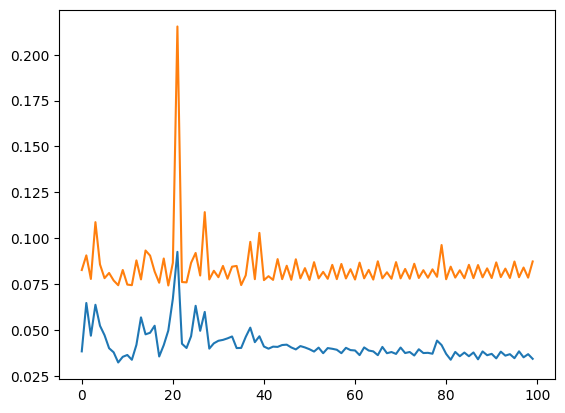

In [ ]:
plt.plot(history_1_ds.history['loss'])
plt.plot(history_1_ds.history['val_loss'])

In [ ]:
history_rmse = np.sqrt(np.squeeze(scaler.inverse_transform(np.expand_dims(history_1_ds.history['mse'], axis=1))))
history_val_rmse = np.sqrt(np.squeeze(scaler.inverse_transform(np.expand_dims(history_1_ds.history['val_mse'], axis=1))))

In [ ]:
# plt.plot(history_mse)

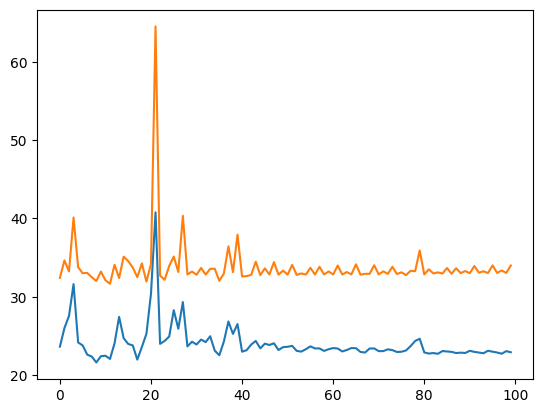

In [ ]:
plt.plot(history_rmse)
plt.plot(history_val_rmse)

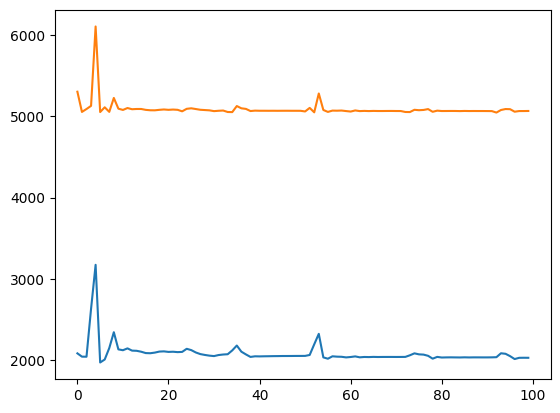

In [ ]:
plt.plot(history_1_ds.history['loss'])
plt.plot(history_1_ds.history['val_loss'])

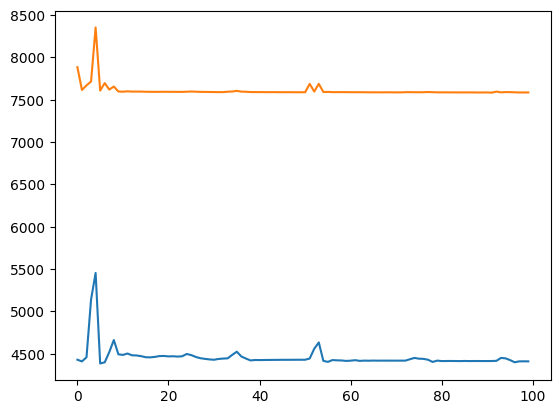

In [ ]:
plt.plot(np.sqrt(history_1_ds.history['mse']))
plt.plot(np.sqrt(history_1_ds.history['val_mse']))